In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 151706 images
Dataset type val label type: species


Loaded 37931 images
Dataset type test label type: species


Loaded 78017 images
Dataset type test label type: species


Loaded 81589 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

2:3 8vaux52z


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                              | 0/1186 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                     | 1/1186 [00:00<15:41,  1.26it/s]

  0%|▎                                                                                                                                                     | 2/1186 [00:00<08:26,  2.34it/s]

  0%|▍                                                                                                                                                     | 3/1186 [00:01<06:06,  3.23it/s]

  0%|▌                                                                                                                                                     | 4/1186 [00:01<05:01,  3.92it/s]

  0%|▋                                                                                                                                                     | 5/1186 [00:01<04:25,  4.46it/s]

  1%|▊                                                                                                                                                     | 6/1186 [00:01<04:03,  4.85it/s]

  1%|▉                                                                                                                                                     | 7/1186 [00:01<03:49,  5.14it/s]

  1%|█                                                                                                                                                     | 8/1186 [00:01<03:40,  5.35it/s]

  1%|█▏                                                                                                                                                    | 9/1186 [00:02<03:33,  5.50it/s]

  1%|█▎                                                                                                                                                   | 10/1186 [00:02<03:29,  5.61it/s]

  1%|█▍                                                                                                                                                   | 11/1186 [00:02<03:26,  5.69it/s]

  1%|█▌                                                                                                                                                   | 12/1186 [00:02<03:24,  5.74it/s]

  1%|█▋                                                                                                                                                   | 13/1186 [00:02<03:23,  5.78it/s]

  1%|█▊                                                                                                                                                   | 14/1186 [00:03<03:22,  5.80it/s]

  1%|█▉                                                                                                                                                   | 15/1186 [00:03<03:21,  5.80it/s]

  1%|██                                                                                                                                                   | 16/1186 [00:03<03:21,  5.82it/s]

  1%|██▏                                                                                                                                                  | 17/1186 [00:03<03:20,  5.83it/s]

  2%|██▎                                                                                                                                                  | 18/1186 [00:03<03:19,  5.84it/s]

  2%|██▍                                                                                                                                                  | 19/1186 [00:03<03:19,  5.85it/s]

  2%|██▌                                                                                                                                                  | 20/1186 [00:04<03:19,  5.86it/s]

  2%|██▋                                                                                                                                                  | 21/1186 [00:04<03:18,  5.86it/s]

  2%|██▊                                                                                                                                                  | 22/1186 [00:04<03:18,  5.86it/s]

  2%|██▉                                                                                                                                                  | 23/1186 [00:04<03:18,  5.86it/s]

  2%|███                                                                                                                                                  | 24/1186 [00:04<03:18,  5.85it/s]

  2%|███▏                                                                                                                                                 | 25/1186 [00:04<03:18,  5.85it/s]

  2%|███▎                                                                                                                                                 | 26/1186 [00:05<03:18,  5.85it/s]

  2%|███▍                                                                                                                                                 | 27/1186 [00:05<03:17,  5.86it/s]

  2%|███▌                                                                                                                                                 | 28/1186 [00:05<03:17,  5.86it/s]

  2%|███▋                                                                                                                                                 | 29/1186 [00:05<03:17,  5.86it/s]

  3%|███▊                                                                                                                                                 | 30/1186 [00:05<03:17,  5.86it/s]

  3%|███▉                                                                                                                                                 | 31/1186 [00:05<03:17,  5.86it/s]

  3%|████                                                                                                                                                 | 32/1186 [00:06<03:16,  5.86it/s]

  3%|████▏                                                                                                                                                | 33/1186 [00:06<03:16,  5.86it/s]

  3%|████▎                                                                                                                                                | 34/1186 [00:06<03:16,  5.86it/s]

  3%|████▍                                                                                                                                                | 35/1186 [00:06<03:16,  5.86it/s]

  3%|████▌                                                                                                                                                | 36/1186 [00:06<03:16,  5.86it/s]

  3%|████▋                                                                                                                                                | 37/1186 [00:06<03:16,  5.86it/s]

  3%|████▊                                                                                                                                                | 38/1186 [00:07<03:15,  5.86it/s]

  3%|████▉                                                                                                                                                | 39/1186 [00:07<03:15,  5.86it/s]

  3%|█████                                                                                                                                                | 40/1186 [00:07<03:15,  5.86it/s]

  3%|█████▏                                                                                                                                               | 41/1186 [00:07<03:15,  5.85it/s]

  4%|█████▎                                                                                                                                               | 42/1186 [00:07<03:15,  5.86it/s]

  4%|█████▍                                                                                                                                               | 43/1186 [00:07<03:15,  5.86it/s]

  4%|█████▌                                                                                                                                               | 44/1186 [00:08<03:14,  5.86it/s]

  4%|█████▋                                                                                                                                               | 45/1186 [00:08<03:14,  5.86it/s]

  4%|█████▊                                                                                                                                               | 46/1186 [00:08<03:14,  5.86it/s]

  4%|█████▉                                                                                                                                               | 47/1186 [00:08<03:14,  5.86it/s]

  4%|██████                                                                                                                                               | 48/1186 [00:08<03:14,  5.86it/s]

  4%|██████▏                                                                                                                                              | 49/1186 [00:08<03:14,  5.86it/s]

  4%|██████▎                                                                                                                                              | 50/1186 [00:09<03:13,  5.86it/s]

  4%|██████▍                                                                                                                                              | 51/1186 [00:09<03:13,  5.86it/s]

  4%|██████▌                                                                                                                                              | 52/1186 [00:09<03:13,  5.86it/s]

  4%|██████▋                                                                                                                                              | 53/1186 [00:09<03:13,  5.86it/s]

  5%|██████▊                                                                                                                                              | 54/1186 [00:09<03:13,  5.86it/s]

  5%|██████▉                                                                                                                                              | 55/1186 [00:10<03:13,  5.86it/s]

  5%|███████                                                                                                                                              | 56/1186 [00:10<03:12,  5.86it/s]

  5%|███████▏                                                                                                                                             | 57/1186 [00:10<03:12,  5.86it/s]

  5%|███████▎                                                                                                                                             | 58/1186 [00:10<03:12,  5.86it/s]

  5%|███████▍                                                                                                                                             | 59/1186 [00:10<03:12,  5.86it/s]

  5%|███████▌                                                                                                                                             | 60/1186 [00:10<03:12,  5.86it/s]

  5%|███████▋                                                                                                                                             | 61/1186 [00:11<03:11,  5.86it/s]

  5%|███████▊                                                                                                                                             | 62/1186 [00:11<03:11,  5.86it/s]

  5%|███████▉                                                                                                                                             | 63/1186 [00:11<03:11,  5.86it/s]

  5%|████████                                                                                                                                             | 64/1186 [00:11<03:11,  5.86it/s]

  5%|████████▏                                                                                                                                            | 65/1186 [00:11<03:11,  5.86it/s]

  6%|████████▎                                                                                                                                            | 66/1186 [00:11<03:11,  5.86it/s]

  6%|████████▍                                                                                                                                            | 67/1186 [00:12<03:10,  5.86it/s]

  6%|████████▌                                                                                                                                            | 68/1186 [00:12<03:10,  5.86it/s]

  6%|████████▋                                                                                                                                            | 69/1186 [00:12<03:10,  5.86it/s]

  6%|████████▊                                                                                                                                            | 70/1186 [00:12<03:10,  5.86it/s]

  6%|████████▉                                                                                                                                            | 71/1186 [00:12<03:10,  5.86it/s]

  6%|█████████                                                                                                                                            | 72/1186 [00:12<03:09,  5.86it/s]

  6%|█████████▏                                                                                                                                           | 73/1186 [00:13<03:09,  5.86it/s]

  6%|█████████▎                                                                                                                                           | 74/1186 [00:13<03:09,  5.86it/s]

  6%|█████████▍                                                                                                                                           | 75/1186 [00:13<03:09,  5.87it/s]

  6%|█████████▌                                                                                                                                           | 76/1186 [00:13<03:09,  5.86it/s]

  6%|█████████▋                                                                                                                                           | 77/1186 [00:13<03:08,  5.87it/s]

  7%|█████████▊                                                                                                                                           | 78/1186 [00:13<03:08,  5.88it/s]

  7%|█████████▉                                                                                                                                           | 79/1186 [00:14<03:07,  5.89it/s]

  7%|██████████                                                                                                                                           | 80/1186 [00:14<03:07,  5.89it/s]

  7%|██████████▏                                                                                                                                          | 81/1186 [00:14<03:07,  5.90it/s]

  7%|██████████▎                                                                                                                                          | 82/1186 [00:14<03:07,  5.90it/s]

  7%|██████████▍                                                                                                                                          | 83/1186 [00:14<03:07,  5.89it/s]

  7%|██████████▌                                                                                                                                          | 84/1186 [00:14<03:07,  5.88it/s]

  7%|██████████▋                                                                                                                                          | 85/1186 [00:15<03:07,  5.88it/s]

  7%|██████████▊                                                                                                                                          | 86/1186 [00:15<03:07,  5.88it/s]

  7%|██████████▉                                                                                                                                          | 87/1186 [00:15<03:07,  5.87it/s]

  7%|███████████                                                                                                                                          | 88/1186 [00:15<03:07,  5.87it/s]

  8%|███████████▏                                                                                                                                         | 89/1186 [00:15<03:06,  5.87it/s]

  8%|███████████▎                                                                                                                                         | 90/1186 [00:15<03:06,  5.86it/s]

  8%|███████████▍                                                                                                                                         | 91/1186 [00:16<03:06,  5.86it/s]

  8%|███████████▌                                                                                                                                         | 92/1186 [00:16<03:06,  5.86it/s]

  8%|███████████▋                                                                                                                                         | 93/1186 [00:16<03:06,  5.86it/s]

  8%|███████████▊                                                                                                                                         | 94/1186 [00:16<03:06,  5.86it/s]

  8%|███████████▉                                                                                                                                         | 95/1186 [00:16<03:06,  5.86it/s]

  8%|████████████                                                                                                                                         | 96/1186 [00:16<03:05,  5.86it/s]

  8%|████████████▏                                                                                                                                        | 97/1186 [00:17<03:05,  5.86it/s]

  8%|████████████▎                                                                                                                                        | 98/1186 [00:17<03:05,  5.86it/s]

  8%|████████████▍                                                                                                                                        | 99/1186 [00:17<03:05,  5.86it/s]

  8%|████████████▍                                                                                                                                       | 100/1186 [00:17<03:05,  5.86it/s]

  9%|████████████▌                                                                                                                                       | 101/1186 [00:17<03:05,  5.86it/s]

  9%|████████████▋                                                                                                                                       | 102/1186 [00:18<03:04,  5.87it/s]

  9%|████████████▊                                                                                                                                       | 103/1186 [00:18<03:04,  5.87it/s]

  9%|████████████▉                                                                                                                                       | 104/1186 [00:18<03:04,  5.86it/s]

  9%|█████████████                                                                                                                                       | 105/1186 [00:18<03:04,  5.86it/s]

  9%|█████████████▏                                                                                                                                      | 106/1186 [00:18<03:04,  5.86it/s]

  9%|█████████████▎                                                                                                                                      | 107/1186 [00:18<03:04,  5.86it/s]

  9%|█████████████▍                                                                                                                                      | 108/1186 [00:19<03:03,  5.86it/s]

  9%|█████████████▌                                                                                                                                      | 109/1186 [00:19<03:03,  5.86it/s]

  9%|█████████████▋                                                                                                                                      | 110/1186 [00:19<03:03,  5.86it/s]

  9%|█████████████▊                                                                                                                                      | 111/1186 [00:19<03:03,  5.86it/s]

  9%|█████████████▉                                                                                                                                      | 112/1186 [00:19<03:03,  5.86it/s]

 10%|██████████████                                                                                                                                      | 113/1186 [00:19<03:03,  5.86it/s]

 10%|██████████████▏                                                                                                                                     | 114/1186 [00:20<03:02,  5.86it/s]

 10%|██████████████▎                                                                                                                                     | 115/1186 [00:20<03:02,  5.86it/s]

 10%|██████████████▍                                                                                                                                     | 116/1186 [00:20<03:02,  5.86it/s]

 10%|██████████████▌                                                                                                                                     | 117/1186 [00:20<03:02,  5.86it/s]

 10%|██████████████▋                                                                                                                                     | 118/1186 [00:20<03:02,  5.86it/s]

 10%|██████████████▊                                                                                                                                     | 119/1186 [00:20<03:02,  5.86it/s]

 10%|██████████████▉                                                                                                                                     | 120/1186 [00:21<03:01,  5.86it/s]

 10%|███████████████                                                                                                                                     | 121/1186 [00:21<03:01,  5.86it/s]

 10%|███████████████▏                                                                                                                                    | 122/1186 [00:21<03:01,  5.86it/s]

 10%|███████████████▎                                                                                                                                    | 123/1186 [00:21<03:01,  5.86it/s]

 10%|███████████████▍                                                                                                                                    | 124/1186 [00:21<03:01,  5.87it/s]

 11%|███████████████▌                                                                                                                                    | 125/1186 [00:21<03:01,  5.86it/s]

 11%|███████████████▋                                                                                                                                    | 126/1186 [00:22<03:00,  5.86it/s]

 11%|███████████████▊                                                                                                                                    | 127/1186 [00:22<03:00,  5.86it/s]

 11%|███████████████▉                                                                                                                                    | 128/1186 [00:22<03:00,  5.86it/s]

 11%|████████████████                                                                                                                                    | 129/1186 [00:22<03:00,  5.86it/s]

 11%|████████████████▏                                                                                                                                   | 130/1186 [00:22<03:00,  5.86it/s]

 11%|████████████████▎                                                                                                                                   | 131/1186 [00:22<02:59,  5.86it/s]

 11%|████████████████▍                                                                                                                                   | 132/1186 [00:23<02:59,  5.86it/s]

 11%|████████████████▌                                                                                                                                   | 133/1186 [00:23<02:59,  5.87it/s]

 11%|████████████████▋                                                                                                                                   | 134/1186 [00:23<02:58,  5.88it/s]

 11%|████████████████▊                                                                                                                                   | 135/1186 [00:23<02:58,  5.89it/s]

 11%|████████████████▉                                                                                                                                   | 136/1186 [00:23<02:58,  5.90it/s]

 12%|█████████████████                                                                                                                                   | 137/1186 [00:23<02:57,  5.90it/s]

 12%|█████████████████▏                                                                                                                                  | 138/1186 [00:24<02:57,  5.90it/s]

 12%|█████████████████▎                                                                                                                                  | 139/1186 [00:24<02:57,  5.89it/s]

 12%|█████████████████▍                                                                                                                                  | 140/1186 [00:24<02:57,  5.89it/s]

 12%|█████████████████▌                                                                                                                                  | 141/1186 [00:24<02:57,  5.88it/s]

 12%|█████████████████▋                                                                                                                                  | 142/1186 [00:24<02:57,  5.87it/s]

 12%|█████████████████▊                                                                                                                                  | 143/1186 [00:25<02:57,  5.87it/s]

 12%|█████████████████▉                                                                                                                                  | 144/1186 [00:25<02:57,  5.87it/s]

 12%|██████████████████                                                                                                                                  | 145/1186 [00:25<02:57,  5.87it/s]

 12%|██████████████████▏                                                                                                                                 | 146/1186 [00:25<02:57,  5.86it/s]

 12%|██████████████████▎                                                                                                                                 | 147/1186 [00:25<02:57,  5.86it/s]

 12%|██████████████████▍                                                                                                                                 | 148/1186 [00:25<02:57,  5.86it/s]

 13%|██████████████████▌                                                                                                                                 | 149/1186 [00:26<02:56,  5.86it/s]

 13%|██████████████████▋                                                                                                                                 | 150/1186 [00:26<02:56,  5.86it/s]

 13%|██████████████████▊                                                                                                                                 | 151/1186 [00:26<02:56,  5.86it/s]

 13%|██████████████████▉                                                                                                                                 | 152/1186 [00:26<02:56,  5.86it/s]

 13%|███████████████████                                                                                                                                 | 153/1186 [00:26<02:56,  5.86it/s]

 13%|███████████████████▏                                                                                                                                | 154/1186 [00:26<02:56,  5.86it/s]

 13%|███████████████████▎                                                                                                                                | 155/1186 [00:27<02:55,  5.86it/s]

 13%|███████████████████▍                                                                                                                                | 156/1186 [00:27<02:55,  5.86it/s]

 13%|███████████████████▌                                                                                                                                | 157/1186 [00:27<02:55,  5.86it/s]

 13%|███████████████████▋                                                                                                                                | 158/1186 [00:27<02:55,  5.86it/s]

 13%|███████████████████▊                                                                                                                                | 159/1186 [00:27<02:55,  5.87it/s]

 13%|███████████████████▉                                                                                                                                | 160/1186 [00:27<02:55,  5.86it/s]

 14%|████████████████████                                                                                                                                | 161/1186 [00:28<02:54,  5.86it/s]

 14%|████████████████████▏                                                                                                                               | 162/1186 [00:28<02:54,  5.86it/s]

 14%|████████████████████▎                                                                                                                               | 163/1186 [00:28<02:54,  5.86it/s]

 14%|████████████████████▍                                                                                                                               | 164/1186 [00:28<02:54,  5.87it/s]

 14%|████████████████████▌                                                                                                                               | 165/1186 [00:28<02:54,  5.86it/s]

 14%|████████████████████▋                                                                                                                               | 166/1186 [00:28<02:53,  5.86it/s]

 14%|████████████████████▊                                                                                                                               | 167/1186 [00:29<02:53,  5.86it/s]

 14%|████████████████████▉                                                                                                                               | 168/1186 [00:29<02:53,  5.86it/s]

 14%|█████████████████████                                                                                                                               | 169/1186 [00:29<02:53,  5.86it/s]

 14%|█████████████████████▏                                                                                                                              | 170/1186 [00:29<02:53,  5.86it/s]

 14%|█████████████████████▎                                                                                                                              | 171/1186 [00:29<02:53,  5.86it/s]

 15%|█████████████████████▍                                                                                                                              | 172/1186 [00:29<02:52,  5.86it/s]

 15%|█████████████████████▌                                                                                                                              | 173/1186 [00:30<02:52,  5.86it/s]

 15%|█████████████████████▋                                                                                                                              | 174/1186 [00:30<02:52,  5.86it/s]

 15%|█████████████████████▊                                                                                                                              | 175/1186 [00:30<02:52,  5.86it/s]

 15%|█████████████████████▉                                                                                                                              | 176/1186 [00:30<02:52,  5.86it/s]

 15%|██████████████████████                                                                                                                              | 177/1186 [00:30<02:52,  5.86it/s]

 15%|██████████████████████▏                                                                                                                             | 178/1186 [00:30<02:51,  5.86it/s]

 15%|██████████████████████▎                                                                                                                             | 179/1186 [00:31<02:51,  5.87it/s]

 15%|██████████████████████▍                                                                                                                             | 180/1186 [00:31<02:51,  5.86it/s]

 15%|██████████████████████▌                                                                                                                             | 181/1186 [00:31<02:51,  5.86it/s]

 15%|██████████████████████▋                                                                                                                             | 182/1186 [00:31<02:51,  5.86it/s]

 15%|██████████████████████▊                                                                                                                             | 183/1186 [00:31<02:51,  5.86it/s]

 16%|██████████████████████▉                                                                                                                             | 184/1186 [00:31<02:50,  5.86it/s]

 16%|███████████████████████                                                                                                                             | 185/1186 [00:32<02:50,  5.86it/s]

 16%|███████████████████████▏                                                                                                                            | 186/1186 [00:32<02:50,  5.86it/s]

 16%|███████████████████████▎                                                                                                                            | 187/1186 [00:32<02:50,  5.87it/s]

 16%|███████████████████████▍                                                                                                                            | 188/1186 [00:32<02:50,  5.86it/s]

 16%|███████████████████████▌                                                                                                                            | 189/1186 [00:32<02:49,  5.88it/s]

 16%|███████████████████████▋                                                                                                                            | 190/1186 [00:33<02:49,  5.88it/s]

 16%|███████████████████████▊                                                                                                                            | 191/1186 [00:33<02:48,  5.89it/s]

 16%|███████████████████████▉                                                                                                                            | 192/1186 [00:33<02:48,  5.89it/s]

 16%|████████████████████████                                                                                                                            | 193/1186 [00:33<02:48,  5.90it/s]

 16%|████████████████████████▏                                                                                                                           | 194/1186 [00:33<02:48,  5.90it/s]

 16%|████████████████████████▎                                                                                                                           | 195/1186 [00:33<02:48,  5.89it/s]

 17%|████████████████████████▍                                                                                                                           | 196/1186 [00:34<02:48,  5.88it/s]

 17%|████████████████████████▌                                                                                                                           | 197/1186 [00:34<02:48,  5.88it/s]

 17%|████████████████████████▋                                                                                                                           | 198/1186 [00:34<02:48,  5.87it/s]

 17%|████████████████████████▊                                                                                                                           | 199/1186 [00:34<02:48,  5.87it/s]

 17%|████████████████████████▉                                                                                                                           | 200/1186 [00:34<02:48,  5.87it/s]

 17%|█████████████████████████                                                                                                                           | 201/1186 [00:34<02:47,  5.87it/s]

 17%|█████████████████████████▏                                                                                                                          | 202/1186 [00:35<02:47,  5.86it/s]

 17%|█████████████████████████▎                                                                                                                          | 203/1186 [00:35<02:47,  5.86it/s]

 17%|█████████████████████████▍                                                                                                                          | 204/1186 [00:35<02:47,  5.86it/s]

 17%|█████████████████████████▌                                                                                                                          | 205/1186 [00:35<02:47,  5.86it/s]

 17%|█████████████████████████▋                                                                                                                          | 206/1186 [00:35<02:47,  5.86it/s]

 17%|█████████████████████████▊                                                                                                                          | 207/1186 [00:35<02:46,  5.87it/s]

 18%|█████████████████████████▉                                                                                                                          | 208/1186 [00:36<02:46,  5.87it/s]

 18%|██████████████████████████                                                                                                                          | 209/1186 [00:36<02:46,  5.86it/s]

 18%|██████████████████████████▏                                                                                                                         | 210/1186 [00:36<02:46,  5.86it/s]

 18%|██████████████████████████▎                                                                                                                         | 211/1186 [00:36<02:46,  5.86it/s]

 18%|██████████████████████████▍                                                                                                                         | 212/1186 [00:36<02:46,  5.86it/s]

 18%|██████████████████████████▌                                                                                                                         | 213/1186 [00:36<02:45,  5.86it/s]

 18%|██████████████████████████▋                                                                                                                         | 214/1186 [00:37<02:45,  5.86it/s]

 18%|██████████████████████████▊                                                                                                                         | 215/1186 [00:37<02:45,  5.86it/s]

 18%|██████████████████████████▉                                                                                                                         | 216/1186 [00:37<02:45,  5.86it/s]

 18%|███████████████████████████                                                                                                                         | 217/1186 [00:37<02:45,  5.86it/s]

 18%|███████████████████████████▏                                                                                                                        | 218/1186 [00:37<02:45,  5.86it/s]

 18%|███████████████████████████▎                                                                                                                        | 219/1186 [00:37<02:45,  5.86it/s]

 19%|███████████████████████████▍                                                                                                                        | 220/1186 [00:38<02:44,  5.86it/s]

 19%|███████████████████████████▌                                                                                                                        | 221/1186 [00:38<02:44,  5.86it/s]

 19%|███████████████████████████▋                                                                                                                        | 222/1186 [00:38<02:44,  5.86it/s]

 19%|███████████████████████████▊                                                                                                                        | 223/1186 [00:38<02:44,  5.85it/s]

 19%|███████████████████████████▉                                                                                                                        | 224/1186 [00:38<02:44,  5.86it/s]

 19%|████████████████████████████                                                                                                                        | 225/1186 [00:38<02:43,  5.86it/s]

 19%|████████████████████████████▏                                                                                                                       | 226/1186 [00:39<02:43,  5.86it/s]

 19%|████████████████████████████▎                                                                                                                       | 227/1186 [00:39<02:43,  5.86it/s]

 19%|████████████████████████████▍                                                                                                                       | 228/1186 [00:39<02:43,  5.86it/s]

 19%|████████████████████████████▌                                                                                                                       | 229/1186 [00:39<02:43,  5.86it/s]

 19%|████████████████████████████▋                                                                                                                       | 230/1186 [00:39<02:43,  5.86it/s]

 19%|████████████████████████████▊                                                                                                                       | 231/1186 [00:40<02:42,  5.86it/s]

 20%|████████████████████████████▉                                                                                                                       | 232/1186 [00:40<02:42,  5.86it/s]

 20%|█████████████████████████████                                                                                                                       | 233/1186 [00:40<02:42,  5.86it/s]

 20%|█████████████████████████████▏                                                                                                                      | 234/1186 [00:40<02:42,  5.86it/s]

 20%|█████████████████████████████▎                                                                                                                      | 235/1186 [00:40<02:42,  5.86it/s]

 20%|█████████████████████████████▍                                                                                                                      | 236/1186 [00:40<02:41,  5.86it/s]

 20%|█████████████████████████████▌                                                                                                                      | 237/1186 [00:41<02:42,  5.86it/s]

 20%|█████████████████████████████▋                                                                                                                      | 238/1186 [00:41<02:41,  5.86it/s]

 20%|█████████████████████████████▊                                                                                                                      | 239/1186 [00:41<02:41,  5.86it/s]

 20%|█████████████████████████████▉                                                                                                                      | 240/1186 [00:41<02:41,  5.86it/s]

 20%|██████████████████████████████                                                                                                                      | 241/1186 [00:41<02:41,  5.87it/s]

 20%|██████████████████████████████▏                                                                                                                     | 242/1186 [00:41<02:40,  5.87it/s]

 20%|██████████████████████████████▎                                                                                                                     | 243/1186 [00:42<02:40,  5.87it/s]

 21%|██████████████████████████████▍                                                                                                                     | 244/1186 [00:42<02:40,  5.86it/s]

 21%|██████████████████████████████▌                                                                                                                     | 245/1186 [00:42<02:40,  5.86it/s]

 21%|██████████████████████████████▋                                                                                                                     | 246/1186 [00:42<02:40,  5.86it/s]

 21%|██████████████████████████████▊                                                                                                                     | 247/1186 [00:42<02:40,  5.86it/s]

 21%|██████████████████████████████▉                                                                                                                     | 248/1186 [00:42<02:39,  5.87it/s]

 21%|███████████████████████████████                                                                                                                     | 249/1186 [00:43<02:39,  5.86it/s]

 21%|███████████████████████████████▏                                                                                                                    | 250/1186 [00:43<02:39,  5.86it/s]

 21%|███████████████████████████████▎                                                                                                                    | 251/1186 [00:43<02:39,  5.86it/s]

 21%|███████████████████████████████▍                                                                                                                    | 252/1186 [00:43<02:39,  5.86it/s]

 21%|███████████████████████████████▌                                                                                                                    | 253/1186 [00:43<02:39,  5.86it/s]

 21%|███████████████████████████████▋                                                                                                                    | 254/1186 [00:43<02:39,  5.86it/s]

 22%|███████████████████████████████▊                                                                                                                    | 255/1186 [00:44<02:38,  5.86it/s]

 22%|███████████████████████████████▉                                                                                                                    | 256/1186 [00:44<02:38,  5.86it/s]

 22%|████████████████████████████████                                                                                                                    | 257/1186 [00:44<02:38,  5.86it/s]

 22%|████████████████████████████████▏                                                                                                                   | 258/1186 [00:44<02:38,  5.86it/s]

 22%|████████████████████████████████▎                                                                                                                   | 259/1186 [00:44<02:38,  5.86it/s]

 22%|████████████████████████████████▍                                                                                                                   | 260/1186 [00:44<02:38,  5.86it/s]

 22%|████████████████████████████████▌                                                                                                                   | 261/1186 [00:45<02:37,  5.86it/s]

 22%|████████████████████████████████▋                                                                                                                   | 262/1186 [00:45<02:37,  5.86it/s]

 22%|████████████████████████████████▊                                                                                                                   | 263/1186 [00:45<02:37,  5.86it/s]

 22%|████████████████████████████████▉                                                                                                                   | 264/1186 [00:45<02:37,  5.86it/s]

 22%|█████████████████████████████████                                                                                                                   | 265/1186 [00:45<02:36,  5.87it/s]

 22%|█████████████████████████████████▏                                                                                                                  | 266/1186 [00:45<02:36,  5.87it/s]

 23%|█████████████████████████████████▎                                                                                                                  | 267/1186 [00:46<02:36,  5.86it/s]

 23%|█████████████████████████████████▍                                                                                                                  | 268/1186 [00:46<02:36,  5.86it/s]

 23%|█████████████████████████████████▌                                                                                                                  | 269/1186 [00:46<02:36,  5.86it/s]

 23%|█████████████████████████████████▋                                                                                                                  | 270/1186 [00:46<02:36,  5.86it/s]

 23%|█████████████████████████████████▊                                                                                                                  | 271/1186 [00:46<02:36,  5.86it/s]

 23%|█████████████████████████████████▉                                                                                                                  | 272/1186 [00:47<02:35,  5.87it/s]

 23%|██████████████████████████████████                                                                                                                  | 273/1186 [00:47<02:35,  5.87it/s]

 23%|██████████████████████████████████▏                                                                                                                 | 274/1186 [00:47<02:35,  5.86it/s]

 23%|██████████████████████████████████▎                                                                                                                 | 275/1186 [00:47<02:35,  5.86it/s]

 23%|██████████████████████████████████▍                                                                                                                 | 276/1186 [00:47<02:35,  5.86it/s]

 23%|██████████████████████████████████▌                                                                                                                 | 277/1186 [00:47<02:35,  5.86it/s]

 23%|██████████████████████████████████▋                                                                                                                 | 278/1186 [00:48<02:34,  5.86it/s]

 24%|██████████████████████████████████▊                                                                                                                 | 279/1186 [00:48<02:34,  5.86it/s]

 24%|██████████████████████████████████▉                                                                                                                 | 280/1186 [00:48<02:34,  5.87it/s]

 24%|███████████████████████████████████                                                                                                                 | 281/1186 [00:48<02:34,  5.86it/s]

 24%|███████████████████████████████████▏                                                                                                                | 282/1186 [00:48<02:34,  5.86it/s]

 24%|███████████████████████████████████▎                                                                                                                | 283/1186 [00:48<02:34,  5.86it/s]

 24%|███████████████████████████████████▍                                                                                                                | 284/1186 [00:49<02:33,  5.86it/s]

 24%|███████████████████████████████████▌                                                                                                                | 285/1186 [00:49<02:33,  5.86it/s]

 24%|███████████████████████████████████▋                                                                                                                | 286/1186 [00:49<02:33,  5.86it/s]

 24%|███████████████████████████████████▊                                                                                                                | 287/1186 [00:49<02:33,  5.86it/s]

 24%|███████████████████████████████████▉                                                                                                                | 288/1186 [00:49<02:33,  5.86it/s]

 24%|████████████████████████████████████                                                                                                                | 289/1186 [00:49<02:32,  5.86it/s]

 24%|████████████████████████████████████▏                                                                                                               | 290/1186 [00:50<02:32,  5.86it/s]

 25%|████████████████████████████████████▎                                                                                                               | 291/1186 [00:50<02:32,  5.86it/s]

 25%|████████████████████████████████████▍                                                                                                               | 292/1186 [00:50<02:32,  5.86it/s]

 25%|████████████████████████████████████▌                                                                                                               | 293/1186 [00:50<02:32,  5.86it/s]

 25%|████████████████████████████████████▋                                                                                                               | 294/1186 [00:50<02:32,  5.86it/s]

 25%|████████████████████████████████████▊                                                                                                               | 295/1186 [00:50<02:32,  5.86it/s]

 25%|████████████████████████████████████▉                                                                                                               | 296/1186 [00:51<02:31,  5.86it/s]

 25%|█████████████████████████████████████                                                                                                               | 297/1186 [00:51<02:31,  5.86it/s]

 25%|█████████████████████████████████████▏                                                                                                              | 298/1186 [00:51<02:31,  5.87it/s]

 25%|█████████████████████████████████████▎                                                                                                              | 299/1186 [00:51<02:31,  5.87it/s]

 25%|█████████████████████████████████████▍                                                                                                              | 300/1186 [00:51<02:31,  5.87it/s]

 25%|█████████████████████████████████████▌                                                                                                              | 301/1186 [00:51<02:31,  5.86it/s]

 25%|█████████████████████████████████████▋                                                                                                              | 302/1186 [00:52<02:30,  5.86it/s]

 26%|█████████████████████████████████████▊                                                                                                              | 303/1186 [00:52<02:30,  5.86it/s]

 26%|█████████████████████████████████████▉                                                                                                              | 304/1186 [00:52<02:30,  5.86it/s]

 26%|██████████████████████████████████████                                                                                                              | 305/1186 [00:52<02:30,  5.86it/s]

 26%|██████████████████████████████████████▏                                                                                                             | 306/1186 [00:52<02:30,  5.87it/s]

 26%|██████████████████████████████████████▎                                                                                                             | 307/1186 [00:52<02:29,  5.86it/s]

 26%|██████████████████████████████████████▍                                                                                                             | 308/1186 [00:53<02:29,  5.86it/s]

 26%|██████████████████████████████████████▌                                                                                                             | 309/1186 [00:53<02:29,  5.86it/s]

 26%|██████████████████████████████████████▋                                                                                                             | 310/1186 [00:53<02:29,  5.86it/s]

 26%|██████████████████████████████████████▊                                                                                                             | 311/1186 [00:53<02:29,  5.86it/s]

 26%|██████████████████████████████████████▉                                                                                                             | 312/1186 [00:53<02:29,  5.86it/s]

 26%|███████████████████████████████████████                                                                                                             | 313/1186 [00:53<02:28,  5.86it/s]

 26%|███████████████████████████████████████▏                                                                                                            | 314/1186 [00:54<02:28,  5.86it/s]

 27%|███████████████████████████████████████▎                                                                                                            | 315/1186 [00:54<02:28,  5.86it/s]

 27%|███████████████████████████████████████▍                                                                                                            | 316/1186 [00:54<02:28,  5.86it/s]

 27%|███████████████████████████████████████▌                                                                                                            | 317/1186 [00:54<02:28,  5.86it/s]

 27%|███████████████████████████████████████▋                                                                                                            | 318/1186 [00:54<02:28,  5.86it/s]

 27%|███████████████████████████████████████▊                                                                                                            | 319/1186 [00:55<02:27,  5.86it/s]

 27%|███████████████████████████████████████▉                                                                                                            | 320/1186 [00:55<02:27,  5.86it/s]

 27%|████████████████████████████████████████                                                                                                            | 321/1186 [00:55<02:27,  5.86it/s]

 27%|████████████████████████████████████████▏                                                                                                           | 322/1186 [00:55<02:27,  5.86it/s]

 27%|████████████████████████████████████████▎                                                                                                           | 323/1186 [00:55<02:27,  5.86it/s]

 27%|████████████████████████████████████████▍                                                                                                           | 324/1186 [00:55<02:27,  5.86it/s]

 27%|████████████████████████████████████████▌                                                                                                           | 325/1186 [00:56<02:26,  5.86it/s]

 27%|████████████████████████████████████████▋                                                                                                           | 326/1186 [00:56<02:26,  5.86it/s]

 28%|████████████████████████████████████████▊                                                                                                           | 327/1186 [00:56<02:26,  5.86it/s]

 28%|████████████████████████████████████████▉                                                                                                           | 328/1186 [00:56<02:26,  5.86it/s]

 28%|█████████████████████████████████████████                                                                                                           | 329/1186 [00:56<02:26,  5.86it/s]

 28%|█████████████████████████████████████████▏                                                                                                          | 330/1186 [00:56<02:26,  5.86it/s]

 28%|█████████████████████████████████████████▎                                                                                                          | 331/1186 [00:57<02:25,  5.86it/s]

 28%|█████████████████████████████████████████▍                                                                                                          | 332/1186 [00:57<02:25,  5.86it/s]

 28%|█████████████████████████████████████████▌                                                                                                          | 333/1186 [00:57<02:25,  5.86it/s]

 28%|█████████████████████████████████████████▋                                                                                                          | 334/1186 [00:57<02:25,  5.86it/s]

 28%|█████████████████████████████████████████▊                                                                                                          | 335/1186 [00:57<02:25,  5.85it/s]

 28%|█████████████████████████████████████████▉                                                                                                          | 336/1186 [00:57<02:25,  5.85it/s]

 28%|██████████████████████████████████████████                                                                                                          | 337/1186 [00:58<02:24,  5.86it/s]

 28%|██████████████████████████████████████████▏                                                                                                         | 338/1186 [00:58<02:24,  5.86it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 339/1186 [00:58<02:24,  5.86it/s]

 29%|██████████████████████████████████████████▍                                                                                                         | 340/1186 [00:58<02:24,  5.86it/s]

 29%|██████████████████████████████████████████▌                                                                                                         | 341/1186 [00:58<02:24,  5.86it/s]

 29%|██████████████████████████████████████████▋                                                                                                         | 342/1186 [00:58<02:24,  5.86it/s]

 29%|██████████████████████████████████████████▊                                                                                                         | 343/1186 [00:59<02:23,  5.86it/s]

 29%|██████████████████████████████████████████▉                                                                                                         | 344/1186 [00:59<02:23,  5.86it/s]

 29%|███████████████████████████████████████████                                                                                                         | 345/1186 [00:59<02:23,  5.86it/s]

 29%|███████████████████████████████████████████▏                                                                                                        | 346/1186 [00:59<02:23,  5.87it/s]

 29%|███████████████████████████████████████████▎                                                                                                        | 347/1186 [00:59<02:22,  5.87it/s]

 29%|███████████████████████████████████████████▍                                                                                                        | 348/1186 [00:59<02:22,  5.87it/s]

 29%|███████████████████████████████████████████▌                                                                                                        | 349/1186 [01:00<02:22,  5.86it/s]

 30%|███████████████████████████████████████████▋                                                                                                        | 350/1186 [01:00<02:22,  5.86it/s]

 30%|███████████████████████████████████████████▊                                                                                                        | 351/1186 [01:00<02:22,  5.86it/s]

 30%|███████████████████████████████████████████▉                                                                                                        | 352/1186 [01:00<02:22,  5.86it/s]

 30%|████████████████████████████████████████████                                                                                                        | 353/1186 [01:00<02:22,  5.86it/s]

 30%|████████████████████████████████████████████▏                                                                                                       | 354/1186 [01:00<02:21,  5.86it/s]

 30%|████████████████████████████████████████████▎                                                                                                       | 355/1186 [01:01<02:21,  5.86it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 356/1186 [01:01<02:21,  5.85it/s]

 30%|████████████████████████████████████████████▌                                                                                                       | 357/1186 [01:01<02:21,  5.85it/s]

 30%|████████████████████████████████████████████▋                                                                                                       | 358/1186 [01:01<02:21,  5.86it/s]

 30%|████████████████████████████████████████████▊                                                                                                       | 359/1186 [01:01<02:21,  5.86it/s]

 30%|████████████████████████████████████████████▉                                                                                                       | 360/1186 [01:02<02:20,  5.86it/s]

 30%|█████████████████████████████████████████████                                                                                                       | 361/1186 [01:02<02:20,  5.86it/s]

 31%|█████████████████████████████████████████████▏                                                                                                      | 362/1186 [01:02<02:20,  5.85it/s]

 31%|█████████████████████████████████████████████▎                                                                                                      | 363/1186 [01:02<02:20,  5.86it/s]

 31%|█████████████████████████████████████████████▍                                                                                                      | 364/1186 [01:02<02:20,  5.86it/s]

 31%|█████████████████████████████████████████████▌                                                                                                      | 365/1186 [01:02<02:20,  5.86it/s]

 31%|█████████████████████████████████████████████▋                                                                                                      | 366/1186 [01:03<02:19,  5.86it/s]

 31%|█████████████████████████████████████████████▊                                                                                                      | 367/1186 [01:03<02:19,  5.86it/s]

 31%|█████████████████████████████████████████████▉                                                                                                      | 368/1186 [01:03<02:19,  5.86it/s]

 31%|██████████████████████████████████████████████                                                                                                      | 369/1186 [01:03<02:19,  5.86it/s]

 31%|██████████████████████████████████████████████▏                                                                                                     | 370/1186 [01:03<02:19,  5.86it/s]

 31%|██████████████████████████████████████████████▎                                                                                                     | 371/1186 [01:03<02:19,  5.86it/s]

 31%|██████████████████████████████████████████████▍                                                                                                     | 372/1186 [01:04<02:18,  5.86it/s]

 31%|██████████████████████████████████████████████▌                                                                                                     | 373/1186 [01:04<02:18,  5.86it/s]

 32%|██████████████████████████████████████████████▋                                                                                                     | 374/1186 [01:04<02:18,  5.87it/s]

 32%|██████████████████████████████████████████████▊                                                                                                     | 375/1186 [01:04<02:18,  5.87it/s]

 32%|██████████████████████████████████████████████▉                                                                                                     | 376/1186 [01:04<02:18,  5.86it/s]

 32%|███████████████████████████████████████████████                                                                                                     | 377/1186 [01:04<02:18,  5.86it/s]

 32%|███████████████████████████████████████████████▏                                                                                                    | 378/1186 [01:05<02:17,  5.86it/s]

 32%|███████████████████████████████████████████████▎                                                                                                    | 379/1186 [01:05<02:17,  5.86it/s]

 32%|███████████████████████████████████████████████▍                                                                                                    | 380/1186 [01:05<02:17,  5.86it/s]

 32%|███████████████████████████████████████████████▌                                                                                                    | 381/1186 [01:05<02:17,  5.86it/s]

 32%|███████████████████████████████████████████████▋                                                                                                    | 382/1186 [01:05<02:17,  5.86it/s]

 32%|███████████████████████████████████████████████▊                                                                                                    | 383/1186 [01:05<02:17,  5.85it/s]

 32%|███████████████████████████████████████████████▉                                                                                                    | 384/1186 [01:06<02:16,  5.86it/s]

 32%|████████████████████████████████████████████████                                                                                                    | 385/1186 [01:06<02:16,  5.86it/s]

 33%|████████████████████████████████████████████████▏                                                                                                   | 386/1186 [01:06<02:16,  5.86it/s]

 33%|████████████████████████████████████████████████▎                                                                                                   | 387/1186 [01:06<02:16,  5.86it/s]

 33%|████████████████████████████████████████████████▍                                                                                                   | 388/1186 [01:06<02:16,  5.86it/s]

 33%|████████████████████████████████████████████████▌                                                                                                   | 389/1186 [01:06<02:15,  5.86it/s]

 33%|████████████████████████████████████████████████▋                                                                                                   | 390/1186 [01:07<02:15,  5.86it/s]

 33%|████████████████████████████████████████████████▊                                                                                                   | 391/1186 [01:07<02:15,  5.86it/s]

 33%|████████████████████████████████████████████████▉                                                                                                   | 392/1186 [01:07<02:15,  5.86it/s]

 33%|█████████████████████████████████████████████████                                                                                                   | 393/1186 [01:07<02:15,  5.86it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                  | 394/1186 [01:07<02:15,  5.84it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 395/1186 [01:07<02:15,  5.85it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                  | 396/1186 [01:08<02:14,  5.86it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                  | 397/1186 [01:08<02:14,  5.85it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                  | 398/1186 [01:08<02:14,  5.85it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                  | 399/1186 [01:08<02:14,  5.86it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                  | 400/1186 [01:08<02:14,  5.86it/s]

 34%|██████████████████████████████████████████████████                                                                                                  | 401/1186 [01:09<02:13,  5.86it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                 | 402/1186 [01:09<02:13,  5.85it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                 | 403/1186 [01:09<02:13,  5.86it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                 | 404/1186 [01:09<02:13,  5.86it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                 | 405/1186 [01:09<02:13,  5.86it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                 | 406/1186 [01:09<02:13,  5.86it/s]

 34%|██████████████████████████████████████████████████▊                                                                                                 | 407/1186 [01:10<02:12,  5.86it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                 | 408/1186 [01:10<02:12,  5.86it/s]

 34%|███████████████████████████████████████████████████                                                                                                 | 409/1186 [01:10<02:12,  5.86it/s]

 35%|███████████████████████████████████████████████████▏                                                                                                | 410/1186 [01:10<02:12,  5.86it/s]

 35%|███████████████████████████████████████████████████▎                                                                                                | 411/1186 [01:10<02:12,  5.86it/s]

 35%|███████████████████████████████████████████████████▍                                                                                                | 412/1186 [01:10<02:12,  5.86it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                | 413/1186 [01:11<02:11,  5.86it/s]

 35%|███████████████████████████████████████████████████▋                                                                                                | 414/1186 [01:11<02:11,  5.86it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                | 415/1186 [01:11<02:11,  5.86it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                | 416/1186 [01:11<02:11,  5.86it/s]

 35%|████████████████████████████████████████████████████                                                                                                | 417/1186 [01:11<02:11,  5.85it/s]

 35%|████████████████████████████████████████████████████▏                                                                                               | 418/1186 [01:11<02:11,  5.85it/s]

 35%|████████████████████████████████████████████████████▎                                                                                               | 419/1186 [01:12<02:11,  5.85it/s]

 35%|████████████████████████████████████████████████████▍                                                                                               | 420/1186 [01:12<02:10,  5.86it/s]

 35%|████████████████████████████████████████████████████▌                                                                                               | 421/1186 [01:12<02:10,  5.86it/s]

 36%|████████████████████████████████████████████████████▋                                                                                               | 422/1186 [01:12<02:10,  5.86it/s]

 36%|████████████████████████████████████████████████████▊                                                                                               | 423/1186 [01:12<02:10,  5.86it/s]

 36%|████████████████████████████████████████████████████▉                                                                                               | 424/1186 [01:12<02:09,  5.86it/s]

 36%|█████████████████████████████████████████████████████                                                                                               | 425/1186 [01:13<02:09,  5.86it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                              | 426/1186 [01:13<02:09,  5.86it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                              | 427/1186 [01:13<02:09,  5.86it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                              | 428/1186 [01:13<02:09,  5.86it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                              | 429/1186 [01:13<02:09,  5.86it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                              | 430/1186 [01:13<02:08,  5.86it/s]

 36%|█████████████████████████████████████████████████████▊                                                                                              | 431/1186 [01:14<02:08,  5.86it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                              | 432/1186 [01:14<02:08,  5.86it/s]

 37%|██████████████████████████████████████████████████████                                                                                              | 433/1186 [01:14<02:08,  5.86it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                             | 434/1186 [01:14<02:08,  5.86it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                             | 435/1186 [01:14<02:08,  5.86it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                             | 436/1186 [01:14<02:08,  5.86it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                             | 437/1186 [01:15<02:07,  5.86it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                             | 438/1186 [01:15<02:07,  5.86it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                             | 439/1186 [01:15<02:07,  5.86it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                             | 440/1186 [01:15<02:07,  5.86it/s]

 37%|███████████████████████████████████████████████████████                                                                                             | 441/1186 [01:15<02:07,  5.86it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                            | 442/1186 [01:16<02:06,  5.86it/s]

 37%|███████████████████████████████████████████████████████▎                                                                                            | 443/1186 [01:16<02:06,  5.86it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                            | 444/1186 [01:16<02:06,  5.86it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                            | 445/1186 [01:16<02:06,  5.86it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                            | 446/1186 [01:16<02:06,  5.86it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                            | 447/1186 [01:16<02:06,  5.86it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                            | 448/1186 [01:17<02:05,  5.86it/s]

 38%|████████████████████████████████████████████████████████                                                                                            | 449/1186 [01:17<02:05,  5.86it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                           | 450/1186 [01:17<02:05,  5.86it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                           | 451/1186 [01:17<02:05,  5.86it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                           | 452/1186 [01:17<02:05,  5.86it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                           | 453/1186 [01:17<02:05,  5.85it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                           | 454/1186 [01:18<02:05,  5.85it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                           | 455/1186 [01:18<02:04,  5.86it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                           | 456/1186 [01:18<02:04,  5.86it/s]

 39%|█████████████████████████████████████████████████████████                                                                                           | 457/1186 [01:18<02:04,  5.86it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                          | 458/1186 [01:18<02:04,  5.85it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                          | 459/1186 [01:18<02:04,  5.85it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                          | 460/1186 [01:19<02:03,  5.86it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                          | 461/1186 [01:19<02:03,  5.86it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                          | 462/1186 [01:19<02:03,  5.86it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                          | 463/1186 [01:19<02:03,  5.86it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                          | 464/1186 [01:19<02:03,  5.86it/s]

 39%|██████████████████████████████████████████████████████████                                                                                          | 465/1186 [01:19<02:03,  5.85it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                         | 466/1186 [01:20<02:03,  5.85it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                         | 467/1186 [01:20<02:02,  5.85it/s]

 39%|██████████████████████████████████████████████████████████▍                                                                                         | 468/1186 [01:20<02:02,  5.86it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                         | 469/1186 [01:20<02:02,  5.86it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                         | 470/1186 [01:20<02:02,  5.86it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                         | 471/1186 [01:20<02:02,  5.86it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                         | 472/1186 [01:21<02:02,  5.85it/s]

 40%|███████████████████████████████████████████████████████████                                                                                         | 473/1186 [01:21<02:02,  5.84it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                        | 474/1186 [01:21<02:01,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                        | 475/1186 [01:21<02:01,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▍                                                                                        | 476/1186 [01:21<02:01,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                        | 477/1186 [01:21<02:01,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▋                                                                                        | 478/1186 [01:22<02:00,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▊                                                                                        | 479/1186 [01:22<02:00,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▉                                                                                        | 480/1186 [01:22<02:00,  5.85it/s]

 41%|████████████████████████████████████████████████████████████                                                                                        | 481/1186 [01:22<02:00,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                       | 482/1186 [01:22<02:00,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                       | 483/1186 [01:23<02:00,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                       | 484/1186 [01:23<01:59,  5.86it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                       | 485/1186 [01:23<01:59,  5.86it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                       | 486/1186 [01:23<01:59,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                       | 487/1186 [01:23<01:59,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                       | 488/1186 [01:23<01:59,  5.85it/s]

 41%|█████████████████████████████████████████████████████████████                                                                                       | 489/1186 [01:24<01:59,  5.85it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                      | 490/1186 [01:24<01:58,  5.86it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                      | 491/1186 [01:24<01:58,  5.86it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                      | 492/1186 [01:24<01:58,  5.86it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                      | 493/1186 [01:24<01:58,  5.85it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                      | 494/1186 [01:24<01:58,  5.85it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                      | 495/1186 [01:25<01:58,  5.85it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                      | 496/1186 [01:25<01:57,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                      | 497/1186 [01:25<01:57,  5.86it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                     | 498/1186 [01:25<01:57,  5.86it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                     | 499/1186 [01:25<01:57,  5.86it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                     | 500/1186 [01:25<01:57,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████▌                                                                                     | 501/1186 [01:26<01:57,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████▋                                                                                     | 502/1186 [01:26<01:56,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                     | 503/1186 [01:26<01:56,  5.86it/s]

 42%|██████████████████████████████████████████████████████████████▉                                                                                     | 504/1186 [01:26<01:56,  5.86it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                     | 505/1186 [01:26<01:56,  5.86it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                    | 506/1186 [01:26<01:56,  5.86it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                    | 507/1186 [01:27<01:56,  5.85it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                    | 508/1186 [01:27<01:55,  5.85it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                    | 509/1186 [01:27<01:55,  5.86it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                    | 510/1186 [01:27<01:55,  5.85it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                    | 511/1186 [01:27<01:55,  5.85it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                    | 512/1186 [01:27<01:55,  5.85it/s]

 43%|████████████████████████████████████████████████████████████████                                                                                    | 513/1186 [01:28<01:55,  5.85it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                   | 514/1186 [01:28<01:54,  5.85it/s]

 43%|████████████████████████████████████████████████████████████████▎                                                                                   | 515/1186 [01:28<01:54,  5.85it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                   | 516/1186 [01:28<01:54,  5.86it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                   | 517/1186 [01:28<01:54,  5.86it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                   | 518/1186 [01:28<01:54,  5.86it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                   | 519/1186 [01:29<01:53,  5.85it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                   | 520/1186 [01:29<01:53,  5.85it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                   | 521/1186 [01:29<01:53,  5.86it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                  | 522/1186 [01:29<01:53,  5.86it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                  | 523/1186 [01:29<01:53,  5.86it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                  | 524/1186 [01:30<01:52,  5.86it/s]

 44%|█████████████████████████████████████████████████████████████████▌                                                                                  | 525/1186 [01:30<01:52,  5.86it/s]

 44%|█████████████████████████████████████████████████████████████████▋                                                                                  | 526/1186 [01:30<01:52,  5.85it/s]

 44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 527/1186 [01:30<01:52,  5.85it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                  | 528/1186 [01:30<01:52,  5.86it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                  | 529/1186 [01:30<01:52,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                 | 530/1186 [01:31<01:52,  5.86it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                 | 531/1186 [01:31<01:51,  5.86it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                 | 532/1186 [01:31<01:51,  5.86it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                 | 533/1186 [01:31<01:51,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                 | 534/1186 [01:31<01:51,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                 | 535/1186 [01:31<01:51,  5.86it/s]

 45%|██████████████████████████████████████████████████████████████████▉                                                                                 | 536/1186 [01:32<01:51,  5.86it/s]

 45%|███████████████████████████████████████████████████████████████████                                                                                 | 537/1186 [01:32<01:50,  5.86it/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                | 538/1186 [01:32<01:50,  5.86it/s]

 45%|███████████████████████████████████████████████████████████████████▎                                                                                | 539/1186 [01:32<01:50,  5.86it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                                | 540/1186 [01:32<01:50,  5.85it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                                | 541/1186 [01:32<01:50,  5.86it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                                | 542/1186 [01:33<01:49,  5.86it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                                | 543/1186 [01:33<01:49,  5.86it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                                | 544/1186 [01:33<01:49,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                                | 545/1186 [01:33<01:49,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                               | 546/1186 [01:33<01:49,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                               | 547/1186 [01:33<01:49,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▍                                                                               | 548/1186 [01:34<01:49,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▌                                                                               | 549/1186 [01:34<01:48,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                               | 550/1186 [01:34<01:48,  5.86it/s]

 46%|████████████████████████████████████████████████████████████████████▊                                                                               | 551/1186 [01:34<01:48,  5.86it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                               | 552/1186 [01:34<01:48,  5.86it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                               | 553/1186 [01:34<01:48,  5.86it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                              | 554/1186 [01:35<01:48,  5.85it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                              | 555/1186 [01:35<01:47,  5.85it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                              | 556/1186 [01:35<01:47,  5.85it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                              | 557/1186 [01:35<01:47,  5.86it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                              | 558/1186 [01:35<01:47,  5.86it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                              | 559/1186 [01:35<01:47,  5.86it/s]

 47%|█████████████████████████████████████████████████████████████████████▉                                                                              | 560/1186 [01:36<01:46,  5.86it/s]

 47%|██████████████████████████████████████████████████████████████████████                                                                              | 561/1186 [01:36<01:46,  5.85it/s]

 47%|██████████████████████████████████████████████████████████████████████▏                                                                             | 562/1186 [01:36<01:46,  5.85it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                             | 563/1186 [01:36<01:46,  5.86it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                             | 564/1186 [01:36<01:46,  5.86it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                             | 565/1186 [01:37<01:45,  5.86it/s]

 48%|██████████████████████████████████████████████████████████████████████▋                                                                             | 566/1186 [01:37<01:45,  5.86it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                             | 567/1186 [01:37<01:45,  5.86it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                             | 568/1186 [01:37<01:45,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                             | 569/1186 [01:37<01:45,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                            | 570/1186 [01:37<01:45,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                            | 571/1186 [01:38<01:45,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████████▍                                                                            | 572/1186 [01:38<01:44,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████████▌                                                                            | 573/1186 [01:38<01:44,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                            | 574/1186 [01:38<01:44,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▊                                                                            | 575/1186 [01:38<01:44,  5.86it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                            | 576/1186 [01:38<01:43,  5.88it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                            | 577/1186 [01:39<01:43,  5.89it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                           | 578/1186 [01:39<01:43,  5.90it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                           | 579/1186 [01:39<01:42,  5.90it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                           | 580/1186 [01:39<01:42,  5.89it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                           | 581/1186 [01:39<01:42,  5.88it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                           | 582/1186 [01:39<01:42,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████████▊                                                                           | 583/1186 [01:40<01:42,  5.86it/s]

 49%|████████████████████████████████████████████████████████████████████████▉                                                                           | 584/1186 [01:40<01:42,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████████                                                                           | 585/1186 [01:40<01:42,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████████▏                                                                          | 586/1186 [01:40<01:42,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████████████████▎                                                                          | 587/1186 [01:40<01:42,  5.85it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                          | 588/1186 [01:40<01:42,  5.85it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                          | 589/1186 [01:41<01:41,  5.86it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                          | 590/1186 [01:41<01:41,  5.86it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                          | 591/1186 [01:41<01:41,  5.86it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                          | 592/1186 [01:41<01:41,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 593/1186 [01:41<01:41,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 594/1186 [01:41<01:41,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                         | 595/1186 [01:42<01:40,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████▎                                                                         | 596/1186 [01:42<01:40,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████▍                                                                         | 597/1186 [01:42<01:40,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                         | 598/1186 [01:42<01:40,  5.86it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                         | 599/1186 [01:42<01:40,  5.86it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                         | 600/1186 [01:42<01:39,  5.86it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                         | 601/1186 [01:43<01:39,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                         | 602/1186 [01:43<01:39,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                        | 603/1186 [01:43<01:39,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                        | 604/1186 [01:43<01:39,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                        | 605/1186 [01:43<01:39,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████▌                                                                        | 606/1186 [01:44<01:38,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                        | 607/1186 [01:44<01:38,  5.87it/s]

 51%|███████████████████████████████████████████████████████████████████████████▊                                                                        | 608/1186 [01:44<01:38,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████▉                                                                        | 609/1186 [01:44<01:38,  5.86it/s]

 51%|████████████████████████████████████████████████████████████████████████████                                                                        | 610/1186 [01:44<01:38,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                       | 611/1186 [01:44<01:38,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                       | 612/1186 [01:45<01:37,  5.87it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                       | 613/1186 [01:45<01:37,  5.87it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                       | 614/1186 [01:45<01:37,  5.87it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                       | 615/1186 [01:45<01:37,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                       | 616/1186 [01:45<01:37,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                       | 617/1186 [01:45<01:37,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                       | 618/1186 [01:46<01:36,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                      | 619/1186 [01:46<01:36,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▎                                                                      | 620/1186 [01:46<01:36,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                      | 621/1186 [01:46<01:36,  5.87it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                      | 622/1186 [01:46<01:36,  5.86it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                      | 623/1186 [01:46<01:36,  5.86it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                      | 624/1186 [01:47<01:35,  5.86it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                      | 625/1186 [01:47<01:35,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                      | 626/1186 [01:47<01:35,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▏                                                                     | 627/1186 [01:47<01:35,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                     | 628/1186 [01:47<01:35,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                     | 629/1186 [01:47<01:34,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                     | 630/1186 [01:48<01:34,  5.88it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                     | 631/1186 [01:48<01:34,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▊                                                                     | 632/1186 [01:48<01:33,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                     | 633/1186 [01:48<01:33,  5.90it/s]

 53%|███████████████████████████████████████████████████████████████████████████████                                                                     | 634/1186 [01:48<01:33,  5.90it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                    | 635/1186 [01:48<01:33,  5.90it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                    | 636/1186 [01:49<01:33,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                    | 637/1186 [01:49<01:33,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                    | 638/1186 [01:49<01:33,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                    | 639/1186 [01:49<01:33,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                    | 640/1186 [01:49<01:32,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                    | 641/1186 [01:49<01:32,  5.87it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                    | 642/1186 [01:50<01:32,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▏                                                                   | 643/1186 [01:50<01:32,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▎                                                                   | 644/1186 [01:50<01:32,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▍                                                                   | 645/1186 [01:50<01:32,  5.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▌                                                                   | 646/1186 [01:50<01:32,  5.85it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                   | 647/1186 [01:50<01:32,  5.85it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                   | 648/1186 [01:51<01:31,  5.85it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                   | 649/1186 [01:51<01:31,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                   | 650/1186 [01:51<01:31,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▏                                                                  | 651/1186 [01:51<01:31,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                  | 652/1186 [01:51<01:31,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                  | 653/1186 [01:52<01:30,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                  | 654/1186 [01:52<01:30,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▋                                                                  | 655/1186 [01:52<01:30,  5.85it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                  | 656/1186 [01:52<01:30,  5.85it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                  | 657/1186 [01:52<01:30,  5.86it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████                                                                  | 658/1186 [01:52<01:30,  5.86it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 659/1186 [01:53<01:29,  5.86it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                 | 660/1186 [01:53<01:29,  5.86it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▍                                                                 | 661/1186 [01:53<01:29,  5.86it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                 | 662/1186 [01:53<01:29,  5.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▋                                                                 | 663/1186 [01:53<01:29,  5.86it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                 | 664/1186 [01:53<01:29,  5.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                 | 665/1186 [01:54<01:28,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                 | 666/1186 [01:54<01:28,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▏                                                                | 667/1186 [01:54<01:28,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                | 668/1186 [01:54<01:28,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                | 669/1186 [01:54<01:28,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▌                                                                | 670/1186 [01:54<01:28,  5.86it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                                | 671/1186 [01:55<01:27,  5.86it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                                | 672/1186 [01:55<01:27,  5.86it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                                | 673/1186 [01:55<01:27,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████                                                                | 674/1186 [01:55<01:27,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                               | 675/1186 [01:55<01:27,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                               | 676/1186 [01:55<01:27,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                               | 677/1186 [01:56<01:26,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                               | 678/1186 [01:56<01:26,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▋                                                               | 679/1186 [01:56<01:26,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▊                                                               | 680/1186 [01:56<01:26,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▉                                                               | 681/1186 [01:56<01:26,  5.86it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                               | 682/1186 [01:56<01:26,  5.86it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                              | 683/1186 [01:57<01:25,  5.86it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                              | 684/1186 [01:57<01:25,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▍                                                              | 685/1186 [01:57<01:25,  5.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▌                                                              | 686/1186 [01:57<01:24,  5.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                              | 687/1186 [01:57<01:24,  5.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                              | 688/1186 [01:57<01:24,  5.90it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                              | 689/1186 [01:58<01:24,  5.90it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████                                                              | 690/1186 [01:58<01:24,  5.89it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                             | 691/1186 [01:58<01:24,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                             | 692/1186 [01:58<01:24,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▍                                                             | 693/1186 [01:58<01:23,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                             | 694/1186 [01:59<01:23,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                             | 695/1186 [01:59<01:23,  5.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                             | 696/1186 [01:59<01:23,  5.86it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                             | 697/1186 [01:59<01:23,  5.86it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████                                                             | 698/1186 [01:59<01:23,  5.86it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                            | 699/1186 [01:59<01:23,  5.86it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                            | 700/1186 [02:00<01:22,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                            | 701/1186 [02:00<01:22,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▌                                                            | 702/1186 [02:00<01:22,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▋                                                            | 703/1186 [02:00<01:22,  5.86it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▊                                                            | 704/1186 [02:00<01:22,  5.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                            | 705/1186 [02:00<01:22,  5.85it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                            | 706/1186 [02:01<01:21,  5.85it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 707/1186 [02:01<01:21,  5.86it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 708/1186 [02:01<01:21,  5.86it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 709/1186 [02:01<01:21,  5.85it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 710/1186 [02:01<01:21,  5.85it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 711/1186 [02:01<01:21,  5.85it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 712/1186 [02:02<01:20,  5.86it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 713/1186 [02:02<01:20,  5.86it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████                                                           | 714/1186 [02:02<01:20,  5.86it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 715/1186 [02:02<01:20,  5.86it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 716/1186 [02:02<01:20,  5.86it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 717/1186 [02:02<01:19,  5.86it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 718/1186 [02:03<01:19,  5.86it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 719/1186 [02:03<01:19,  5.86it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 720/1186 [02:03<01:19,  5.86it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 721/1186 [02:03<01:19,  5.86it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████                                                          | 722/1186 [02:03<01:19,  5.86it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 723/1186 [02:03<01:18,  5.87it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 724/1186 [02:04<01:18,  5.87it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 725/1186 [02:04<01:18,  5.86it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 726/1186 [02:04<01:18,  5.86it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 727/1186 [02:04<01:18,  5.84it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 728/1186 [02:04<01:18,  5.85it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 729/1186 [02:04<01:18,  5.86it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                         | 730/1186 [02:05<01:17,  5.86it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 731/1186 [02:05<01:17,  5.87it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 732/1186 [02:05<01:17,  5.87it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 733/1186 [02:05<01:17,  5.87it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 734/1186 [02:05<01:16,  5.87it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 735/1186 [02:06<01:16,  5.87it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 736/1186 [02:06<01:16,  5.87it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 737/1186 [02:06<01:16,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████                                                        | 738/1186 [02:06<01:16,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 739/1186 [02:06<01:16,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 740/1186 [02:06<01:15,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 741/1186 [02:07<01:15,  5.87it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 742/1186 [02:07<01:15,  5.87it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 743/1186 [02:07<01:15,  5.87it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 744/1186 [02:07<01:15,  5.87it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 745/1186 [02:07<01:15,  5.87it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████                                                       | 746/1186 [02:07<01:14,  5.87it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 747/1186 [02:08<01:14,  5.87it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 748/1186 [02:08<01:14,  5.87it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 749/1186 [02:08<01:14,  5.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 750/1186 [02:08<01:14,  5.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 751/1186 [02:08<01:14,  5.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 752/1186 [02:08<01:14,  5.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 753/1186 [02:09<01:13,  5.86it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                      | 754/1186 [02:09<01:13,  5.86it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 755/1186 [02:09<01:13,  5.86it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 756/1186 [02:09<01:13,  5.87it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 757/1186 [02:09<01:13,  5.87it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 758/1186 [02:09<01:13,  5.86it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 759/1186 [02:10<01:12,  5.86it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 760/1186 [02:10<01:12,  5.86it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 761/1186 [02:10<01:12,  5.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████                                                     | 762/1186 [02:10<01:12,  5.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 763/1186 [02:10<01:12,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 764/1186 [02:10<01:11,  5.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 765/1186 [02:11<01:11,  5.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 766/1186 [02:11<01:11,  5.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 767/1186 [02:11<01:11,  5.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 768/1186 [02:11<01:11,  5.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 769/1186 [02:11<01:11,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 770/1186 [02:11<01:10,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 771/1186 [02:12<01:10,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 772/1186 [02:12<01:10,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 773/1186 [02:12<01:10,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 774/1186 [02:12<01:10,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 775/1186 [02:12<01:10,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 776/1186 [02:12<01:09,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 777/1186 [02:13<01:09,  5.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 778/1186 [02:13<01:09,  5.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 779/1186 [02:13<01:09,  5.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 780/1186 [02:13<01:09,  5.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 781/1186 [02:13<01:09,  5.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 782/1186 [02:14<01:08,  5.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 783/1186 [02:14<01:08,  5.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 784/1186 [02:14<01:08,  5.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 785/1186 [02:14<01:08,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 786/1186 [02:14<01:08,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 787/1186 [02:14<01:08,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 788/1186 [02:15<01:07,  5.87it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 789/1186 [02:15<01:07,  5.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 790/1186 [02:15<01:07,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 791/1186 [02:15<01:07,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 792/1186 [02:15<01:07,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 793/1186 [02:15<01:07,  5.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 794/1186 [02:16<01:06,  5.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 795/1186 [02:16<01:06,  5.87it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 796/1186 [02:16<01:06,  5.87it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 797/1186 [02:16<01:06,  5.87it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 798/1186 [02:16<01:06,  5.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 799/1186 [02:16<01:05,  5.87it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 800/1186 [02:17<01:05,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 801/1186 [02:17<01:05,  5.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 802/1186 [02:17<01:05,  5.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 803/1186 [02:17<01:05,  5.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 804/1186 [02:17<01:05,  5.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 805/1186 [02:17<01:04,  5.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 806/1186 [02:18<01:04,  5.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 807/1186 [02:18<01:04,  5.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 808/1186 [02:18<01:04,  5.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 809/1186 [02:18<01:04,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 810/1186 [02:18<01:04,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 811/1186 [02:18<01:03,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 812/1186 [02:19<01:03,  5.87it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 813/1186 [02:19<01:03,  5.87it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 814/1186 [02:19<01:03,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 815/1186 [02:19<01:03,  5.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 816/1186 [02:19<01:03,  5.87it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 817/1186 [02:19<01:02,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 818/1186 [02:20<01:02,  5.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 819/1186 [02:20<01:02,  5.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 820/1186 [02:20<01:02,  5.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 821/1186 [02:20<01:02,  5.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 822/1186 [02:20<01:02,  5.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 823/1186 [02:21<01:01,  5.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 824/1186 [02:21<01:01,  5.87it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 825/1186 [02:21<01:01,  5.87it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 826/1186 [02:21<01:01,  5.87it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 827/1186 [02:21<01:01,  5.87it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 828/1186 [02:21<01:00,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 829/1186 [02:22<01:00,  5.87it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 830/1186 [02:22<01:00,  5.87it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 831/1186 [02:22<01:00,  5.87it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 832/1186 [02:22<01:00,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 833/1186 [02:22<01:00,  5.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 834/1186 [02:22<01:00,  5.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 835/1186 [02:23<00:59,  5.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 836/1186 [02:23<00:59,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 837/1186 [02:23<00:59,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 838/1186 [02:23<00:59,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 839/1186 [02:23<00:59,  5.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 840/1186 [02:23<00:58,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 841/1186 [02:24<00:58,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 842/1186 [02:24<00:58,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 843/1186 [02:24<00:58,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 844/1186 [02:24<00:58,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 845/1186 [02:24<00:58,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 846/1186 [02:24<00:57,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 847/1186 [02:25<00:57,  5.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 848/1186 [02:25<00:57,  5.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 849/1186 [02:25<00:57,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 850/1186 [02:25<00:57,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 851/1186 [02:25<00:57,  5.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 852/1186 [02:25<00:56,  5.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 853/1186 [02:26<00:56,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 854/1186 [02:26<00:56,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 855/1186 [02:26<00:56,  5.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 856/1186 [02:26<00:56,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 857/1186 [02:26<00:56,  5.86it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 858/1186 [02:26<00:55,  5.86it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 859/1186 [02:27<00:55,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 860/1186 [02:27<00:55,  5.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 861/1186 [02:27<00:55,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 862/1186 [02:27<00:55,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 863/1186 [02:27<00:55,  5.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 864/1186 [02:28<00:54,  5.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 865/1186 [02:28<00:54,  5.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 866/1186 [02:28<00:54,  5.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 867/1186 [02:28<00:54,  5.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 868/1186 [02:28<00:54,  5.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 869/1186 [02:28<00:54,  5.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 870/1186 [02:29<00:53,  5.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 871/1186 [02:29<00:53,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 872/1186 [02:29<00:53,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 873/1186 [02:29<00:53,  5.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 874/1186 [02:29<00:53,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 875/1186 [02:29<00:53,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 876/1186 [02:30<00:52,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 877/1186 [02:30<00:52,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 878/1186 [02:30<00:52,  5.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 879/1186 [02:30<00:52,  5.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 880/1186 [02:30<00:52,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 881/1186 [02:30<00:52,  5.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 882/1186 [02:31<00:51,  5.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 883/1186 [02:31<00:51,  5.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 884/1186 [02:31<00:51,  5.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 885/1186 [02:31<00:51,  5.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 886/1186 [02:31<00:51,  5.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 887/1186 [02:31<00:50,  5.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 888/1186 [02:32<00:50,  5.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 889/1186 [02:32<00:50,  5.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 890/1186 [02:32<00:50,  5.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 891/1186 [02:32<00:50,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 892/1186 [02:32<00:50,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 893/1186 [02:32<00:49,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 894/1186 [02:33<00:49,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 895/1186 [02:33<00:49,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 896/1186 [02:33<00:49,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 897/1186 [02:33<00:49,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 898/1186 [02:33<00:49,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 899/1186 [02:33<00:48,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 900/1186 [02:34<00:48,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 901/1186 [02:34<00:48,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 902/1186 [02:34<00:48,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 903/1186 [02:34<00:48,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 904/1186 [02:34<00:48,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 905/1186 [02:34<00:47,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 906/1186 [02:35<00:47,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 907/1186 [02:35<00:47,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 908/1186 [02:35<00:47,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 909/1186 [02:35<00:47,  5.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 910/1186 [02:35<00:47,  5.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 911/1186 [02:36<00:46,  5.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 912/1186 [02:36<00:46,  5.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 913/1186 [02:36<00:46,  5.86it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 914/1186 [02:36<00:46,  5.86it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 915/1186 [02:36<00:46,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 916/1186 [02:36<00:46,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 917/1186 [02:37<00:45,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 918/1186 [02:37<00:45,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 919/1186 [02:37<00:45,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 920/1186 [02:37<00:45,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 921/1186 [02:37<00:45,  5.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 922/1186 [02:37<00:45,  5.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 923/1186 [02:38<00:44,  5.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 924/1186 [02:38<00:44,  5.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 925/1186 [02:38<00:44,  5.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 926/1186 [02:38<00:44,  5.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 927/1186 [02:38<00:44,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 928/1186 [02:38<00:43,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 929/1186 [02:39<00:43,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 930/1186 [02:39<00:43,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 931/1186 [02:39<00:43,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 932/1186 [02:39<00:43,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 933/1186 [02:39<00:43,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 934/1186 [02:39<00:42,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 935/1186 [02:40<00:42,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 936/1186 [02:40<00:42,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 937/1186 [02:40<00:42,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 938/1186 [02:40<00:42,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 939/1186 [02:40<00:42,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 940/1186 [02:40<00:41,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 941/1186 [02:41<00:41,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 942/1186 [02:41<00:41,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 943/1186 [02:41<00:41,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 944/1186 [02:41<00:41,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 945/1186 [02:41<00:41,  5.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 946/1186 [02:41<00:40,  5.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 947/1186 [02:42<00:40,  5.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 948/1186 [02:42<00:40,  5.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 949/1186 [02:42<00:40,  5.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 950/1186 [02:42<00:40,  5.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 951/1186 [02:42<00:40,  5.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 952/1186 [02:43<00:39,  5.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 953/1186 [02:43<00:39,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 954/1186 [02:43<00:39,  5.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 955/1186 [02:43<00:39,  5.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 956/1186 [02:43<00:39,  5.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 957/1186 [02:43<00:39,  5.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 958/1186 [02:44<00:38,  5.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 959/1186 [02:44<00:38,  5.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 960/1186 [02:44<00:38,  5.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 961/1186 [02:44<00:38,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 962/1186 [02:44<00:38,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 963/1186 [02:44<00:38,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 964/1186 [02:45<00:37,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 965/1186 [02:45<00:37,  5.86it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 966/1186 [02:45<00:37,  5.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 967/1186 [02:45<00:37,  5.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 968/1186 [02:45<00:37,  5.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 969/1186 [02:45<00:37,  5.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 970/1186 [02:46<00:36,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 971/1186 [02:46<00:36,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 972/1186 [02:46<00:36,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 973/1186 [02:46<00:36,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 974/1186 [02:46<00:36,  5.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 975/1186 [02:46<00:36,  5.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 976/1186 [02:47<00:35,  5.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 977/1186 [02:47<00:35,  5.86it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 978/1186 [02:47<00:35,  5.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 979/1186 [02:47<00:35,  5.87it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 980/1186 [02:47<00:35,  5.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 981/1186 [02:47<00:34,  5.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 982/1186 [02:48<00:34,  5.87it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 983/1186 [02:48<00:34,  5.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 984/1186 [02:48<00:34,  5.87it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 985/1186 [02:48<00:34,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 986/1186 [02:48<00:34,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 987/1186 [02:48<00:33,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 988/1186 [02:49<00:33,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 989/1186 [02:49<00:33,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 990/1186 [02:49<00:33,  5.87it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 991/1186 [02:49<00:33,  5.87it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 992/1186 [02:49<00:33,  5.87it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 993/1186 [02:50<00:32,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 994/1186 [02:50<00:32,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 995/1186 [02:50<00:32,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 996/1186 [02:50<00:32,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 997/1186 [02:50<00:32,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 998/1186 [02:50<00:32,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 999/1186 [02:51<00:31,  5.87it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1000/1186 [02:51<00:31,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1001/1186 [02:51<00:31,  5.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1002/1186 [02:51<00:31,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1003/1186 [02:51<00:31,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1004/1186 [02:51<00:31,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1005/1186 [02:52<00:30,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1006/1186 [02:52<00:30,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1007/1186 [02:52<00:30,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1008/1186 [02:52<00:30,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1009/1186 [02:52<00:30,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1010/1186 [02:52<00:30,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1011/1186 [02:53<00:29,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1012/1186 [02:53<00:29,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1013/1186 [02:53<00:29,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1014/1186 [02:53<00:29,  5.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1015/1186 [02:53<00:29,  5.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1016/1186 [02:53<00:28,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1017/1186 [02:54<00:28,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1018/1186 [02:54<00:28,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1019/1186 [02:54<00:28,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1020/1186 [02:54<00:28,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1021/1186 [02:54<00:28,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1022/1186 [02:54<00:27,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1023/1186 [02:55<00:27,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1024/1186 [02:55<00:27,  5.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1025/1186 [02:55<00:27,  5.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1026/1186 [02:55<00:27,  5.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1027/1186 [02:55<00:27,  5.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1028/1186 [02:55<00:26,  5.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1029/1186 [02:56<00:26,  5.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1030/1186 [02:56<00:26,  5.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1031/1186 [02:56<00:26,  5.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1032/1186 [02:56<00:26,  5.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1033/1186 [02:56<00:26,  5.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1034/1186 [02:56<00:25,  5.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1035/1186 [02:57<00:25,  5.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1036/1186 [02:57<00:25,  5.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1037/1186 [02:57<00:25,  5.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1038/1186 [02:57<00:25,  5.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1039/1186 [02:57<00:25,  5.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1040/1186 [02:58<00:24,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1041/1186 [02:58<00:24,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1042/1186 [02:58<00:24,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1043/1186 [02:58<00:24,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1044/1186 [02:58<00:24,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1045/1186 [02:58<00:24,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1046/1186 [02:59<00:23,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1047/1186 [02:59<00:23,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1048/1186 [02:59<00:23,  5.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1049/1186 [02:59<00:23,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1050/1186 [02:59<00:23,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1051/1186 [02:59<00:23,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1052/1186 [03:00<00:22,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1053/1186 [03:00<00:22,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1054/1186 [03:00<00:22,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1055/1186 [03:00<00:22,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1056/1186 [03:00<00:22,  5.87it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1057/1186 [03:00<00:22,  5.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1058/1186 [03:01<00:21,  5.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1059/1186 [03:01<00:21,  5.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1060/1186 [03:01<00:21,  5.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1061/1186 [03:01<00:21,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1062/1186 [03:01<00:21,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1063/1186 [03:01<00:20,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1064/1186 [03:02<00:20,  5.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1065/1186 [03:02<00:20,  5.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1066/1186 [03:02<00:20,  5.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1067/1186 [03:02<00:20,  5.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1068/1186 [03:02<00:20,  5.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1069/1186 [03:02<00:19,  5.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1070/1186 [03:03<00:19,  5.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1071/1186 [03:03<00:19,  5.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1072/1186 [03:03<00:19,  5.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1073/1186 [03:03<00:19,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1074/1186 [03:03<00:19,  5.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1075/1186 [03:03<00:18,  5.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1076/1186 [03:04<00:18,  5.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1077/1186 [03:04<00:18,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1078/1186 [03:04<00:18,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1079/1186 [03:04<00:18,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1080/1186 [03:04<00:18,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1081/1186 [03:05<00:17,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1082/1186 [03:05<00:17,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1083/1186 [03:05<00:17,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1084/1186 [03:05<00:17,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1085/1186 [03:05<00:17,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1086/1186 [03:05<00:17,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1087/1186 [03:06<00:16,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1088/1186 [03:06<00:16,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1089/1186 [03:06<00:16,  5.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1090/1186 [03:06<00:16,  5.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1091/1186 [03:06<00:16,  5.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1092/1186 [03:06<00:16,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1093/1186 [03:07<00:15,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1094/1186 [03:07<00:15,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1095/1186 [03:07<00:15,  5.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1096/1186 [03:07<00:15,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1097/1186 [03:07<00:15,  5.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1098/1186 [03:07<00:15,  5.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1099/1186 [03:08<00:14,  5.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1100/1186 [03:08<00:14,  5.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1101/1186 [03:08<00:14,  5.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1102/1186 [03:08<00:14,  5.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1103/1186 [03:08<00:14,  5.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1104/1186 [03:08<00:13,  5.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1105/1186 [03:09<00:13,  5.86it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1106/1186 [03:09<00:13,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1107/1186 [03:09<00:13,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1108/1186 [03:09<00:13,  5.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1109/1186 [03:09<00:13,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1110/1186 [03:09<00:12,  5.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1111/1186 [03:10<00:12,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1112/1186 [03:10<00:12,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1113/1186 [03:10<00:12,  5.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1114/1186 [03:10<00:12,  5.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1115/1186 [03:10<00:12,  5.73it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1116/1186 [03:10<00:12,  5.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1117/1186 [03:11<00:11,  5.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1118/1186 [03:11<00:11,  5.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1119/1186 [03:11<00:11,  5.83it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1120/1186 [03:11<00:11,  5.84it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1121/1186 [03:11<00:11,  5.85it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1122/1186 [03:12<00:10,  5.85it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1123/1186 [03:12<00:10,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1124/1186 [03:12<00:10,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1125/1186 [03:12<00:10,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1126/1186 [03:12<00:10,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1127/1186 [03:12<00:10,  5.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1128/1186 [03:13<00:09,  5.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1129/1186 [03:13<00:09,  5.86it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1130/1186 [03:13<00:09,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1131/1186 [03:13<00:09,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1132/1186 [03:13<00:09,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1133/1186 [03:13<00:09,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1134/1186 [03:14<00:08,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1135/1186 [03:14<00:08,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1136/1186 [03:14<00:08,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1137/1186 [03:14<00:08,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1138/1186 [03:14<00:08,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1139/1186 [03:14<00:08,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1140/1186 [03:15<00:07,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1141/1186 [03:15<00:07,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1142/1186 [03:15<00:07,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1143/1186 [03:15<00:07,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1144/1186 [03:15<00:07,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1145/1186 [03:15<00:06,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1146/1186 [03:16<00:06,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1147/1186 [03:16<00:06,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1148/1186 [03:16<00:06,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1149/1186 [03:16<00:06,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1150/1186 [03:16<00:06,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1151/1186 [03:16<00:05,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1152/1186 [03:17<00:05,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1153/1186 [03:17<00:05,  5.86it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1154/1186 [03:17<00:05,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1155/1186 [03:17<00:05,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1156/1186 [03:17<00:05,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1157/1186 [03:17<00:04,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1158/1186 [03:18<00:04,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1159/1186 [03:18<00:04,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1160/1186 [03:18<00:04,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1161/1186 [03:18<00:04,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1162/1186 [03:18<00:04,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1163/1186 [03:18<00:03,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1164/1186 [03:19<00:03,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1165/1186 [03:19<00:03,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1166/1186 [03:19<00:03,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1167/1186 [03:19<00:03,  5.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1168/1186 [03:19<00:03,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1169/1186 [03:20<00:02,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1170/1186 [03:20<00:02,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1171/1186 [03:20<00:02,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1172/1186 [03:20<00:02,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1173/1186 [03:20<00:02,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1174/1186 [03:20<00:02,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1175/1186 [03:21<00:01,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1176/1186 [03:21<00:01,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1177/1186 [03:21<00:01,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1178/1186 [03:21<00:01,  5.81it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1179/1186 [03:21<00:01,  5.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1180/1186 [03:21<00:01,  5.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1181/1186 [03:22<00:00,  5.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1182/1186 [03:22<00:00,  5.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1183/1186 [03:22<00:00,  5.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1184/1186 [03:22<00:00,  5.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1185/1186 [03:22<00:00,  5.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [03:22<00:00,  5.85it/s]

train - OK


  0%|                                                                                                                                                               | 0/297 [00:00<?, ?it/s]

  0%|▌                                                                                                                                                      | 1/297 [00:00<02:26,  2.02it/s]

  1%|█                                                                                                                                                      | 2/297 [00:00<01:29,  3.28it/s]

  1%|█▌                                                                                                                                                     | 3/297 [00:00<01:11,  4.11it/s]

  1%|██                                                                                                                                                     | 4/297 [00:01<01:02,  4.66it/s]

  2%|██▌                                                                                                                                                    | 5/297 [00:01<00:58,  5.03it/s]

  2%|███                                                                                                                                                    | 6/297 [00:01<00:55,  5.28it/s]

  2%|███▌                                                                                                                                                   | 7/297 [00:01<00:53,  5.46it/s]

  3%|████                                                                                                                                                   | 8/297 [00:01<00:51,  5.57it/s]

  3%|████▌                                                                                                                                                  | 9/297 [00:01<00:50,  5.66it/s]

  3%|█████                                                                                                                                                 | 10/297 [00:02<00:50,  5.72it/s]

  4%|█████▌                                                                                                                                                | 11/297 [00:02<00:49,  5.76it/s]

  4%|██████                                                                                                                                                | 12/297 [00:02<00:49,  5.79it/s]

  4%|██████▌                                                                                                                                               | 13/297 [00:02<00:48,  5.80it/s]

  5%|███████                                                                                                                                               | 14/297 [00:02<00:48,  5.82it/s]

  5%|███████▌                                                                                                                                              | 15/297 [00:02<00:48,  5.83it/s]

  5%|████████                                                                                                                                              | 16/297 [00:03<00:48,  5.84it/s]

  6%|████████▌                                                                                                                                             | 17/297 [00:03<00:47,  5.84it/s]

  6%|█████████                                                                                                                                             | 18/297 [00:03<00:47,  5.85it/s]

  6%|█████████▌                                                                                                                                            | 19/297 [00:03<00:47,  5.85it/s]

  7%|██████████                                                                                                                                            | 20/297 [00:03<00:47,  5.85it/s]

  7%|██████████▌                                                                                                                                           | 21/297 [00:03<00:47,  5.86it/s]

  7%|███████████                                                                                                                                           | 22/297 [00:04<00:47,  5.85it/s]

  8%|███████████▌                                                                                                                                          | 23/297 [00:04<00:46,  5.85it/s]

  8%|████████████                                                                                                                                          | 24/297 [00:04<00:46,  5.86it/s]

  8%|████████████▋                                                                                                                                         | 25/297 [00:04<00:46,  5.86it/s]

  9%|█████████████▏                                                                                                                                        | 26/297 [00:04<00:46,  5.86it/s]

  9%|█████████████▋                                                                                                                                        | 27/297 [00:04<00:46,  5.86it/s]

  9%|██████████████▏                                                                                                                                       | 28/297 [00:05<00:45,  5.86it/s]

 10%|██████████████▋                                                                                                                                       | 29/297 [00:05<00:45,  5.86it/s]

 10%|███████████████▏                                                                                                                                      | 30/297 [00:05<00:45,  5.86it/s]

 10%|███████████████▋                                                                                                                                      | 31/297 [00:05<00:45,  5.86it/s]

 11%|████████████████▏                                                                                                                                     | 32/297 [00:05<00:45,  5.86it/s]

 11%|████████████████▋                                                                                                                                     | 33/297 [00:05<00:45,  5.86it/s]

 11%|█████████████████▏                                                                                                                                    | 34/297 [00:06<00:44,  5.86it/s]

 12%|█████████████████▋                                                                                                                                    | 35/297 [00:06<00:44,  5.86it/s]

 12%|██████████████████▏                                                                                                                                   | 36/297 [00:06<00:44,  5.85it/s]

 12%|██████████████████▋                                                                                                                                   | 37/297 [00:06<00:44,  5.86it/s]

 13%|███████████████████▏                                                                                                                                  | 38/297 [00:06<00:44,  5.86it/s]

 13%|███████████████████▋                                                                                                                                  | 39/297 [00:06<00:44,  5.86it/s]

 13%|████████████████████▏                                                                                                                                 | 40/297 [00:07<00:43,  5.86it/s]

 14%|████████████████████▋                                                                                                                                 | 41/297 [00:07<00:43,  5.86it/s]

 14%|█████████████████████▏                                                                                                                                | 42/297 [00:07<00:43,  5.86it/s]

 14%|█████████████████████▋                                                                                                                                | 43/297 [00:07<00:43,  5.85it/s]

 15%|██████████████████████▏                                                                                                                               | 44/297 [00:07<00:43,  5.85it/s]

 15%|██████████████████████▋                                                                                                                               | 45/297 [00:08<00:43,  5.86it/s]

 15%|███████████████████████▏                                                                                                                              | 46/297 [00:08<00:42,  5.86it/s]

 16%|███████████████████████▋                                                                                                                              | 47/297 [00:08<00:42,  5.86it/s]

 16%|████████████████████████▏                                                                                                                             | 48/297 [00:08<00:42,  5.86it/s]

 16%|████████████████████████▋                                                                                                                             | 49/297 [00:08<00:42,  5.86it/s]

 17%|█████████████████████████▎                                                                                                                            | 50/297 [00:08<00:42,  5.86it/s]

 17%|█████████████████████████▊                                                                                                                            | 51/297 [00:09<00:41,  5.86it/s]

 18%|██████████████████████████▎                                                                                                                           | 52/297 [00:09<00:41,  5.86it/s]

 18%|██████████████████████████▊                                                                                                                           | 53/297 [00:09<00:41,  5.86it/s]

 18%|███████████████████████████▎                                                                                                                          | 54/297 [00:09<00:41,  5.86it/s]

 19%|███████████████████████████▊                                                                                                                          | 55/297 [00:09<00:41,  5.86it/s]

 19%|████████████████████████████▎                                                                                                                         | 56/297 [00:09<00:41,  5.86it/s]

 19%|████████████████████████████▊                                                                                                                         | 57/297 [00:10<00:40,  5.85it/s]

 20%|█████████████████████████████▎                                                                                                                        | 58/297 [00:10<00:40,  5.86it/s]

 20%|█████████████████████████████▊                                                                                                                        | 59/297 [00:10<00:40,  5.84it/s]

 20%|██████████████████████████████▎                                                                                                                       | 60/297 [00:10<00:40,  5.84it/s]

 21%|██████████████████████████████▊                                                                                                                       | 61/297 [00:10<00:40,  5.85it/s]

 21%|███████████████████████████████▎                                                                                                                      | 62/297 [00:10<00:40,  5.85it/s]

 21%|███████████████████████████████▊                                                                                                                      | 63/297 [00:11<00:40,  5.85it/s]

 22%|████████████████████████████████▎                                                                                                                     | 64/297 [00:11<00:39,  5.84it/s]

 22%|████████████████████████████████▊                                                                                                                     | 65/297 [00:11<00:39,  5.85it/s]

 22%|█████████████████████████████████▎                                                                                                                    | 66/297 [00:11<00:39,  5.85it/s]

 23%|█████████████████████████████████▊                                                                                                                    | 67/297 [00:11<00:39,  5.85it/s]

 23%|██████████████████████████████████▎                                                                                                                   | 68/297 [00:11<00:39,  5.86it/s]

 23%|██████████████████████████████████▊                                                                                                                   | 69/297 [00:12<00:38,  5.86it/s]

 24%|███████████████████████████████████▎                                                                                                                  | 70/297 [00:12<00:38,  5.86it/s]

 24%|███████████████████████████████████▊                                                                                                                  | 71/297 [00:12<00:38,  5.85it/s]

 24%|████████████████████████████████████▎                                                                                                                 | 72/297 [00:12<00:38,  5.85it/s]

 25%|████████████████████████████████████▊                                                                                                                 | 73/297 [00:12<00:38,  5.86it/s]

 25%|█████████████████████████████████████▎                                                                                                                | 74/297 [00:12<00:38,  5.86it/s]

 25%|█████████████████████████████████████▉                                                                                                                | 75/297 [00:13<00:37,  5.86it/s]

 26%|██████████████████████████████████████▍                                                                                                               | 76/297 [00:13<00:37,  5.86it/s]

 26%|██████████████████████████████████████▉                                                                                                               | 77/297 [00:13<00:37,  5.85it/s]

 26%|███████████████████████████████████████▍                                                                                                              | 78/297 [00:13<00:37,  5.84it/s]

 27%|███████████████████████████████████████▉                                                                                                              | 79/297 [00:13<00:37,  5.85it/s]

 27%|████████████████████████████████████████▍                                                                                                             | 80/297 [00:13<00:37,  5.85it/s]

 27%|████████████████████████████████████████▉                                                                                                             | 81/297 [00:14<00:36,  5.85it/s]

 28%|█████████████████████████████████████████▍                                                                                                            | 82/297 [00:14<00:36,  5.85it/s]

 28%|█████████████████████████████████████████▉                                                                                                            | 83/297 [00:14<00:36,  5.84it/s]

 28%|██████████████████████████████████████████▍                                                                                                           | 84/297 [00:14<00:36,  5.85it/s]

 29%|██████████████████████████████████████████▉                                                                                                           | 85/297 [00:14<00:36,  5.84it/s]

 29%|███████████████████████████████████████████▍                                                                                                          | 86/297 [00:15<00:36,  5.84it/s]

 29%|███████████████████████████████████████████▉                                                                                                          | 87/297 [00:15<00:35,  5.84it/s]

 30%|████████████████████████████████████████████▍                                                                                                         | 88/297 [00:15<00:35,  5.85it/s]

 30%|████████████████████████████████████████████▉                                                                                                         | 89/297 [00:15<00:35,  5.85it/s]

 30%|█████████████████████████████████████████████▍                                                                                                        | 90/297 [00:15<00:35,  5.85it/s]

 31%|█████████████████████████████████████████████▉                                                                                                        | 91/297 [00:15<00:35,  5.85it/s]

 31%|██████████████████████████████████████████████▍                                                                                                       | 92/297 [00:16<00:35,  5.84it/s]

 31%|██████████████████████████████████████████████▉                                                                                                       | 93/297 [00:16<00:34,  5.84it/s]

 32%|███████████████████████████████████████████████▍                                                                                                      | 94/297 [00:16<00:34,  5.84it/s]

 32%|███████████████████████████████████████████████▉                                                                                                      | 95/297 [00:16<00:34,  5.84it/s]

 32%|████████████████████████████████████████████████▍                                                                                                     | 96/297 [00:16<00:34,  5.84it/s]

 33%|████████████████████████████████████████████████▉                                                                                                     | 97/297 [00:16<00:34,  5.84it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                    | 98/297 [00:17<00:34,  5.85it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 99/297 [00:17<00:33,  5.84it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                  | 100/297 [00:17<00:33,  5.84it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                  | 101/297 [00:17<00:33,  5.84it/s]

 34%|███████████████████████████████████████████████████▏                                                                                                 | 102/297 [00:17<00:33,  5.84it/s]

 35%|███████████████████████████████████████████████████▋                                                                                                 | 103/297 [00:17<00:33,  5.84it/s]

 35%|████████████████████████████████████████████████████▏                                                                                                | 104/297 [00:18<00:33,  5.85it/s]

 35%|████████████████████████████████████████████████████▋                                                                                                | 105/297 [00:18<00:32,  5.85it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                               | 106/297 [00:18<00:32,  5.84it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                               | 107/297 [00:18<00:32,  5.84it/s]

 36%|██████████████████████████████████████████████████████▏                                                                                              | 108/297 [00:18<00:32,  5.84it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                              | 109/297 [00:18<00:32,  5.84it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                             | 110/297 [00:19<00:31,  5.84it/s]

 37%|███████████████████████████████████████████████████████▋                                                                                             | 111/297 [00:19<00:31,  5.84it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                            | 112/297 [00:19<00:31,  5.85it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                            | 113/297 [00:19<00:31,  5.84it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                           | 114/297 [00:19<00:31,  5.84it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 115/297 [00:19<00:31,  5.84it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                          | 116/297 [00:20<00:30,  5.85it/s]

 39%|██████████████████████████████████████████████████████████▋                                                                                          | 117/297 [00:20<00:30,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 118/297 [00:20<00:30,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▋                                                                                         | 119/297 [00:20<00:30,  5.85it/s]

 40%|████████████████████████████████████████████████████████████▏                                                                                        | 120/297 [00:20<00:30,  5.84it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                        | 121/297 [00:21<00:30,  5.84it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                       | 122/297 [00:21<00:29,  5.84it/s]

 41%|█████████████████████████████████████████████████████████████▋                                                                                       | 123/297 [00:21<00:29,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                      | 124/297 [00:21<00:29,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████▋                                                                                      | 125/297 [00:21<00:29,  5.85it/s]

 42%|███████████████████████████████████████████████████████████████▏                                                                                     | 126/297 [00:21<00:29,  5.85it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                     | 127/297 [00:22<00:29,  5.84it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                    | 128/297 [00:22<00:28,  5.84it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                    | 129/297 [00:22<00:28,  5.85it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                   | 130/297 [00:22<00:28,  5.85it/s]

 44%|█████████████████████████████████████████████████████████████████▋                                                                                   | 131/297 [00:22<00:28,  5.85it/s]

 44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 132/297 [00:22<00:28,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                  | 133/297 [00:23<00:28,  5.85it/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                 | 134/297 [00:23<00:27,  5.84it/s]

 45%|███████████████████████████████████████████████████████████████████▋                                                                                 | 135/297 [00:23<00:27,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                                | 136/297 [00:23<00:27,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                                | 137/297 [00:23<00:27,  5.85it/s]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                               | 138/297 [00:23<00:27,  5.85it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                               | 139/297 [00:24<00:27,  5.85it/s]

 47%|██████████████████████████████████████████████████████████████████████▏                                                                              | 140/297 [00:24<00:26,  5.85it/s]

 47%|██████████████████████████████████████████████████████████████████████▋                                                                              | 141/297 [00:24<00:26,  5.84it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                             | 142/297 [00:24<00:26,  5.84it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                             | 143/297 [00:24<00:26,  5.84it/s]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                            | 144/297 [00:24<00:26,  5.85it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                            | 145/297 [00:25<00:25,  5.85it/s]

 49%|█████████████████████████████████████████████████████████████████████████▏                                                                           | 146/297 [00:25<00:25,  5.85it/s]

 49%|█████████████████████████████████████████████████████████████████████████▋                                                                           | 147/297 [00:25<00:25,  5.85it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                          | 148/297 [00:25<00:25,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████▊                                                                          | 149/297 [00:25<00:25,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                         | 150/297 [00:25<00:25,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▊                                                                         | 151/297 [00:26<00:24,  5.85it/s]

 51%|████████████████████████████████████████████████████████████████████████████▎                                                                        | 152/297 [00:26<00:24,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                        | 153/297 [00:26<00:24,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▎                                                                       | 154/297 [00:26<00:24,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                       | 155/297 [00:26<00:24,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                      | 156/297 [00:26<00:24,  5.85it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▊                                                                      | 157/297 [00:27<00:23,  5.85it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                     | 158/297 [00:27<00:23,  5.85it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                     | 159/297 [00:27<00:23,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▎                                                                    | 160/297 [00:27<00:23,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                    | 161/297 [00:27<00:23,  5.85it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                   | 162/297 [00:28<00:23,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                   | 163/297 [00:28<00:22,  5.85it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                  | 164/297 [00:28<00:22,  5.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 165/297 [00:28<00:22,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                 | 166/297 [00:28<00:22,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                 | 167/297 [00:28<00:22,  5.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                                | 168/297 [00:29<00:21,  5.87it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▊                                                                | 169/297 [00:29<00:21,  5.86it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▎                                                               | 170/297 [00:29<00:21,  5.86it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                               | 171/297 [00:29<00:21,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                              | 172/297 [00:29<00:21,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▊                                                              | 173/297 [00:29<00:21,  5.87it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                             | 174/297 [00:30<00:20,  5.86it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▊                                                             | 175/297 [00:30<00:20,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 176/297 [00:30<00:20,  5.86it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 177/297 [00:30<00:20,  5.86it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 178/297 [00:30<00:20,  5.86it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 179/297 [00:30<00:20,  5.86it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 180/297 [00:31<00:19,  5.86it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 181/297 [00:31<00:19,  5.86it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 182/297 [00:31<00:19,  5.87it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 183/297 [00:31<00:19,  5.86it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 184/297 [00:31<00:19,  5.86it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 185/297 [00:31<00:19,  5.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 186/297 [00:32<00:18,  5.87it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 187/297 [00:32<00:18,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 188/297 [00:32<00:18,  5.87it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 189/297 [00:32<00:18,  5.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 190/297 [00:32<00:18,  5.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 191/297 [00:32<00:18,  5.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 192/297 [00:33<00:17,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 193/297 [00:33<00:17,  5.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 194/297 [00:33<00:17,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 195/297 [00:33<00:17,  5.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 196/297 [00:33<00:17,  5.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 197/297 [00:33<00:17,  5.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 198/297 [00:34<00:16,  5.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 199/297 [00:34<00:16,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 200/297 [00:34<00:16,  5.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 201/297 [00:34<00:16,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 202/297 [00:34<00:16,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 203/297 [00:35<00:15,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 204/297 [00:35<00:15,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 205/297 [00:35<00:15,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 206/297 [00:35<00:15,  5.91it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 207/297 [00:35<00:15,  5.91it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 208/297 [00:35<00:15,  5.92it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 209/297 [00:36<00:14,  5.92it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 210/297 [00:36<00:14,  5.93it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 211/297 [00:36<00:14,  5.92it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 212/297 [00:36<00:14,  5.92it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 213/297 [00:36<00:14,  5.91it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 214/297 [00:36<00:14,  5.91it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 215/297 [00:37<00:13,  5.90it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 216/297 [00:37<00:13,  5.90it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 217/297 [00:37<00:13,  5.89it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 218/297 [00:37<00:13,  5.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 219/297 [00:37<00:13,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 220/297 [00:37<00:13,  5.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 221/297 [00:38<00:12,  5.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 222/297 [00:38<00:12,  5.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 223/297 [00:38<00:12,  5.86it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 224/297 [00:38<00:12,  5.86it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 225/297 [00:38<00:12,  5.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 226/297 [00:38<00:12,  5.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 227/297 [00:39<00:11,  5.85it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 228/297 [00:39<00:11,  5.85it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 229/297 [00:39<00:11,  5.85it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 230/297 [00:39<00:11,  5.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 231/297 [00:39<00:11,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 232/297 [00:39<00:11,  5.85it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 233/297 [00:40<00:10,  5.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 234/297 [00:40<00:10,  5.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 235/297 [00:40<00:10,  5.84it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 236/297 [00:40<00:10,  5.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 237/297 [00:40<00:10,  5.85it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 238/297 [00:40<00:10,  5.85it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 239/297 [00:41<00:09,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 240/297 [00:41<00:09,  5.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 241/297 [00:41<00:09,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 242/297 [00:41<00:09,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 243/297 [00:41<00:09,  5.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 244/297 [00:41<00:09,  5.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 245/297 [00:42<00:08,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 246/297 [00:42<00:08,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 247/297 [00:42<00:08,  5.85it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 248/297 [00:42<00:08,  5.85it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 249/297 [00:42<00:08,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 250/297 [00:43<00:08,  5.85it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 251/297 [00:43<00:07,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 252/297 [00:43<00:07,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 253/297 [00:43<00:07,  5.86it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 254/297 [00:43<00:07,  5.86it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 255/297 [00:43<00:07,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 256/297 [00:44<00:06,  5.86it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 257/297 [00:44<00:06,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 258/297 [00:44<00:06,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 259/297 [00:44<00:06,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 260/297 [00:44<00:06,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 261/297 [00:44<00:06,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 262/297 [00:45<00:05,  5.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 263/297 [00:45<00:05,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 264/297 [00:45<00:05,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 265/297 [00:45<00:05,  5.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 266/297 [00:45<00:05,  5.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 267/297 [00:45<00:05,  5.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 268/297 [00:46<00:04,  5.86it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 269/297 [00:46<00:04,  5.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 270/297 [00:46<00:04,  5.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 271/297 [00:46<00:04,  5.86it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 272/297 [00:46<00:04,  5.86it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 273/297 [00:46<00:04,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 274/297 [00:47<00:03,  5.86it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 275/297 [00:47<00:03,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 276/297 [00:47<00:03,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 277/297 [00:47<00:03,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 278/297 [00:47<00:03,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 279/297 [00:47<00:03,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 280/297 [00:48<00:02,  5.86it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 281/297 [00:48<00:02,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 282/297 [00:48<00:02,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 283/297 [00:48<00:02,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 284/297 [00:48<00:02,  5.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 285/297 [00:48<00:02,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 286/297 [00:49<00:01,  5.86it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 287/297 [00:49<00:01,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 288/297 [00:49<00:01,  5.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 289/297 [00:49<00:01,  5.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 290/297 [00:49<00:01,  5.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 291/297 [00:50<00:01,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 292/297 [00:50<00:00,  5.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 293/297 [00:50<00:00,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 294/297 [00:50<00:00,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 295/297 [00:50<00:00,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 296/297 [00:50<00:00,  5.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:51<00:00,  5.81it/s]

val - OK


  0%|                                                                                                                                                               | 0/610 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                      | 1/610 [00:00<05:32,  1.83it/s]

  0%|▍                                                                                                                                                      | 2/610 [00:00<03:18,  3.07it/s]

  0%|▋                                                                                                                                                      | 3/610 [00:00<02:34,  3.92it/s]

  1%|▉                                                                                                                                                      | 4/610 [00:01<02:14,  4.51it/s]

  1%|█▏                                                                                                                                                     | 5/610 [00:01<02:03,  4.91it/s]

  1%|█▍                                                                                                                                                     | 6/610 [00:01<01:56,  5.20it/s]

  1%|█▋                                                                                                                                                     | 7/610 [00:01<01:51,  5.39it/s]

  1%|█▉                                                                                                                                                     | 8/610 [00:01<01:48,  5.53it/s]

  1%|██▏                                                                                                                                                    | 9/610 [00:01<01:46,  5.63it/s]

  2%|██▍                                                                                                                                                   | 10/610 [00:02<01:45,  5.69it/s]

  2%|██▋                                                                                                                                                   | 11/610 [00:02<01:44,  5.74it/s]

  2%|██▉                                                                                                                                                   | 12/610 [00:02<01:43,  5.77it/s]

  2%|███▏                                                                                                                                                  | 13/610 [00:02<01:42,  5.80it/s]

  2%|███▍                                                                                                                                                  | 14/610 [00:02<01:42,  5.81it/s]

  2%|███▋                                                                                                                                                  | 15/610 [00:02<01:42,  5.83it/s]

  3%|███▉                                                                                                                                                  | 16/610 [00:03<01:41,  5.83it/s]

  3%|████▏                                                                                                                                                 | 17/610 [00:03<01:41,  5.83it/s]

  3%|████▍                                                                                                                                                 | 18/610 [00:03<01:41,  5.84it/s]

  3%|████▋                                                                                                                                                 | 19/610 [00:03<01:41,  5.84it/s]

  3%|████▉                                                                                                                                                 | 20/610 [00:03<01:41,  5.84it/s]

  3%|█████▏                                                                                                                                                | 21/610 [00:03<01:40,  5.84it/s]

  4%|█████▍                                                                                                                                                | 22/610 [00:04<01:40,  5.84it/s]

  4%|█████▋                                                                                                                                                | 23/610 [00:04<01:40,  5.84it/s]

  4%|█████▉                                                                                                                                                | 24/610 [00:04<01:40,  5.84it/s]

  4%|██████▏                                                                                                                                               | 25/610 [00:04<01:40,  5.84it/s]

  4%|██████▍                                                                                                                                               | 26/610 [00:04<01:39,  5.84it/s]

  4%|██████▋                                                                                                                                               | 27/610 [00:04<01:39,  5.84it/s]

  5%|██████▉                                                                                                                                               | 28/610 [00:05<01:39,  5.85it/s]

  5%|███████▏                                                                                                                                              | 29/610 [00:05<01:39,  5.85it/s]

  5%|███████▍                                                                                                                                              | 30/610 [00:05<01:39,  5.85it/s]

  5%|███████▌                                                                                                                                              | 31/610 [00:05<01:39,  5.85it/s]

  5%|███████▊                                                                                                                                              | 32/610 [00:05<01:38,  5.85it/s]

  5%|████████                                                                                                                                              | 33/610 [00:06<01:38,  5.85it/s]

  6%|████████▎                                                                                                                                             | 34/610 [00:06<01:38,  5.85it/s]

  6%|████████▌                                                                                                                                             | 35/610 [00:06<01:38,  5.85it/s]

  6%|████████▊                                                                                                                                             | 36/610 [00:06<01:38,  5.85it/s]

  6%|█████████                                                                                                                                             | 37/610 [00:06<01:38,  5.85it/s]

  6%|█████████▎                                                                                                                                            | 38/610 [00:06<01:37,  5.84it/s]

  6%|█████████▌                                                                                                                                            | 39/610 [00:07<01:37,  5.85it/s]

  7%|█████████▊                                                                                                                                            | 40/610 [00:07<01:37,  5.85it/s]

  7%|██████████                                                                                                                                            | 41/610 [00:07<01:37,  5.84it/s]

  7%|██████████▎                                                                                                                                           | 42/610 [00:07<01:37,  5.85it/s]

  7%|██████████▌                                                                                                                                           | 43/610 [00:07<01:36,  5.85it/s]

  7%|██████████▊                                                                                                                                           | 44/610 [00:07<01:36,  5.85it/s]

  7%|███████████                                                                                                                                           | 45/610 [00:08<01:36,  5.85it/s]

  8%|███████████▎                                                                                                                                          | 46/610 [00:08<01:36,  5.85it/s]

  8%|███████████▌                                                                                                                                          | 47/610 [00:08<01:36,  5.85it/s]

  8%|███████████▊                                                                                                                                          | 48/610 [00:08<01:36,  5.85it/s]

  8%|████████████                                                                                                                                          | 49/610 [00:08<01:35,  5.85it/s]

  8%|████████████▎                                                                                                                                         | 50/610 [00:08<01:35,  5.85it/s]

  8%|████████████▌                                                                                                                                         | 51/610 [00:09<01:35,  5.85it/s]

  9%|████████████▊                                                                                                                                         | 52/610 [00:09<01:35,  5.85it/s]

  9%|█████████████                                                                                                                                         | 53/610 [00:09<01:35,  5.85it/s]

  9%|█████████████▎                                                                                                                                        | 54/610 [00:09<01:35,  5.85it/s]

  9%|█████████████▌                                                                                                                                        | 55/610 [00:09<01:34,  5.85it/s]

  9%|█████████████▊                                                                                                                                        | 56/610 [00:09<01:34,  5.85it/s]

  9%|██████████████                                                                                                                                        | 57/610 [00:10<01:34,  5.85it/s]

 10%|██████████████▎                                                                                                                                       | 58/610 [00:10<01:34,  5.85it/s]

 10%|██████████████▌                                                                                                                                       | 59/610 [00:10<01:34,  5.85it/s]

 10%|██████████████▊                                                                                                                                       | 60/610 [00:10<01:33,  5.85it/s]

 10%|███████████████                                                                                                                                       | 61/610 [00:10<01:33,  5.85it/s]

 10%|███████████████▏                                                                                                                                      | 62/610 [00:10<01:33,  5.85it/s]

 10%|███████████████▍                                                                                                                                      | 63/610 [00:11<01:33,  5.85it/s]

 10%|███████████████▋                                                                                                                                      | 64/610 [00:11<01:33,  5.85it/s]

 11%|███████████████▉                                                                                                                                      | 65/610 [00:11<01:33,  5.85it/s]

 11%|████████████████▏                                                                                                                                     | 66/610 [00:11<01:32,  5.85it/s]

 11%|████████████████▍                                                                                                                                     | 67/610 [00:11<01:32,  5.85it/s]

 11%|████████████████▋                                                                                                                                     | 68/610 [00:12<01:32,  5.85it/s]

 11%|████████████████▉                                                                                                                                     | 69/610 [00:12<01:32,  5.85it/s]

 11%|█████████████████▏                                                                                                                                    | 70/610 [00:12<01:32,  5.85it/s]

 12%|█████████████████▍                                                                                                                                    | 71/610 [00:12<01:32,  5.85it/s]

 12%|█████████████████▋                                                                                                                                    | 72/610 [00:12<01:31,  5.85it/s]

 12%|█████████████████▉                                                                                                                                    | 73/610 [00:12<01:31,  5.85it/s]

 12%|██████████████████▏                                                                                                                                   | 74/610 [00:13<01:31,  5.85it/s]

 12%|██████████████████▍                                                                                                                                   | 75/610 [00:13<01:31,  5.85it/s]

 12%|██████████████████▋                                                                                                                                   | 76/610 [00:13<01:31,  5.85it/s]

 13%|██████████████████▉                                                                                                                                   | 77/610 [00:13<01:31,  5.85it/s]

 13%|███████████████████▏                                                                                                                                  | 78/610 [00:13<01:30,  5.85it/s]

 13%|███████████████████▍                                                                                                                                  | 79/610 [00:13<01:30,  5.85it/s]

 13%|███████████████████▋                                                                                                                                  | 80/610 [00:14<01:30,  5.85it/s]

 13%|███████████████████▉                                                                                                                                  | 81/610 [00:14<01:30,  5.85it/s]

 13%|████████████████████▏                                                                                                                                 | 82/610 [00:14<01:30,  5.85it/s]

 14%|████████████████████▍                                                                                                                                 | 83/610 [00:14<01:30,  5.85it/s]

 14%|████████████████████▋                                                                                                                                 | 84/610 [00:14<01:29,  5.85it/s]

 14%|████████████████████▉                                                                                                                                 | 85/610 [00:14<01:29,  5.85it/s]

 14%|█████████████████████▏                                                                                                                                | 86/610 [00:15<01:29,  5.85it/s]

 14%|█████████████████████▍                                                                                                                                | 87/610 [00:15<01:29,  5.85it/s]

 14%|█████████████████████▋                                                                                                                                | 88/610 [00:15<01:29,  5.85it/s]

 15%|█████████████████████▉                                                                                                                                | 89/610 [00:15<01:29,  5.85it/s]

 15%|██████████████████████▏                                                                                                                               | 90/610 [00:15<01:28,  5.85it/s]

 15%|██████████████████████▍                                                                                                                               | 91/610 [00:15<01:28,  5.85it/s]

 15%|██████████████████████▌                                                                                                                               | 92/610 [00:16<01:28,  5.85it/s]

 15%|██████████████████████▊                                                                                                                               | 93/610 [00:16<01:28,  5.85it/s]

 15%|███████████████████████                                                                                                                               | 94/610 [00:16<01:28,  5.84it/s]

 16%|███████████████████████▎                                                                                                                              | 95/610 [00:16<01:28,  5.85it/s]

 16%|███████████████████████▌                                                                                                                              | 96/610 [00:16<01:27,  5.84it/s]

 16%|███████████████████████▊                                                                                                                              | 97/610 [00:16<01:27,  5.85it/s]

 16%|████████████████████████                                                                                                                              | 98/610 [00:17<01:27,  5.85it/s]

 16%|████████████████████████▎                                                                                                                             | 99/610 [00:17<01:27,  5.83it/s]

 16%|████████████████████████▍                                                                                                                            | 100/610 [00:17<01:27,  5.84it/s]

 17%|████████████████████████▋                                                                                                                            | 101/610 [00:17<01:27,  5.84it/s]

 17%|████████████████████████▉                                                                                                                            | 102/610 [00:17<01:26,  5.85it/s]

 17%|█████████████████████████▏                                                                                                                           | 103/610 [00:17<01:26,  5.84it/s]

 17%|█████████████████████████▍                                                                                                                           | 104/610 [00:18<01:26,  5.84it/s]

 17%|█████████████████████████▋                                                                                                                           | 105/610 [00:18<01:26,  5.84it/s]

 17%|█████████████████████████▉                                                                                                                           | 106/610 [00:18<01:26,  5.85it/s]

 18%|██████████████████████████▏                                                                                                                          | 107/610 [00:18<01:26,  5.84it/s]

 18%|██████████████████████████▍                                                                                                                          | 108/610 [00:18<01:25,  5.85it/s]

 18%|██████████████████████████▌                                                                                                                          | 109/610 [00:19<01:25,  5.85it/s]

 18%|██████████████████████████▊                                                                                                                          | 110/610 [00:19<01:25,  5.85it/s]

 18%|███████████████████████████                                                                                                                          | 111/610 [00:19<01:25,  5.85it/s]

 18%|███████████████████████████▎                                                                                                                         | 112/610 [00:19<01:25,  5.85it/s]

 19%|███████████████████████████▌                                                                                                                         | 113/610 [00:19<01:24,  5.85it/s]

 19%|███████████████████████████▊                                                                                                                         | 114/610 [00:19<01:24,  5.85it/s]

 19%|████████████████████████████                                                                                                                         | 115/610 [00:20<01:24,  5.85it/s]

 19%|████████████████████████████▎                                                                                                                        | 116/610 [00:20<01:24,  5.85it/s]

 19%|████████████████████████████▌                                                                                                                        | 117/610 [00:20<01:24,  5.85it/s]

 19%|████████████████████████████▊                                                                                                                        | 118/610 [00:20<01:24,  5.85it/s]

 20%|█████████████████████████████                                                                                                                        | 119/610 [00:20<01:23,  5.85it/s]

 20%|█████████████████████████████▎                                                                                                                       | 120/610 [00:20<01:23,  5.85it/s]

 20%|█████████████████████████████▌                                                                                                                       | 121/610 [00:21<01:23,  5.85it/s]

 20%|█████████████████████████████▊                                                                                                                       | 122/610 [00:21<01:23,  5.85it/s]

 20%|██████████████████████████████                                                                                                                       | 123/610 [00:21<01:23,  5.85it/s]

 20%|██████████████████████████████▎                                                                                                                      | 124/610 [00:21<01:23,  5.85it/s]

 20%|██████████████████████████████▌                                                                                                                      | 125/610 [00:21<01:22,  5.85it/s]

 21%|██████████████████████████████▊                                                                                                                      | 126/610 [00:21<01:22,  5.85it/s]

 21%|███████████████████████████████                                                                                                                      | 127/610 [00:22<01:22,  5.85it/s]

 21%|███████████████████████████████▎                                                                                                                     | 128/610 [00:22<01:22,  5.85it/s]

 21%|███████████████████████████████▌                                                                                                                     | 129/610 [00:22<01:22,  5.85it/s]

 21%|███████████████████████████████▊                                                                                                                     | 130/610 [00:22<01:21,  5.85it/s]

 21%|███████████████████████████████▉                                                                                                                     | 131/610 [00:22<01:21,  5.85it/s]

 22%|████████████████████████████████▏                                                                                                                    | 132/610 [00:22<01:21,  5.85it/s]

 22%|████████████████████████████████▍                                                                                                                    | 133/610 [00:23<01:21,  5.85it/s]

 22%|████████████████████████████████▋                                                                                                                    | 134/610 [00:23<01:21,  5.85it/s]

 22%|████████████████████████████████▉                                                                                                                    | 135/610 [00:23<01:21,  5.85it/s]

 22%|█████████████████████████████████▏                                                                                                                   | 136/610 [00:23<01:20,  5.85it/s]

 22%|█████████████████████████████████▍                                                                                                                   | 137/610 [00:23<01:20,  5.85it/s]

 23%|█████████████████████████████████▋                                                                                                                   | 138/610 [00:23<01:20,  5.85it/s]

 23%|█████████████████████████████████▉                                                                                                                   | 139/610 [00:24<01:20,  5.84it/s]

 23%|██████████████████████████████████▏                                                                                                                  | 140/610 [00:24<01:20,  5.85it/s]

 23%|██████████████████████████████████▍                                                                                                                  | 141/610 [00:24<01:20,  5.85it/s]

 23%|██████████████████████████████████▋                                                                                                                  | 142/610 [00:24<01:20,  5.84it/s]

 23%|██████████████████████████████████▉                                                                                                                  | 143/610 [00:24<01:19,  5.84it/s]

 24%|███████████████████████████████████▏                                                                                                                 | 144/610 [00:24<01:19,  5.85it/s]

 24%|███████████████████████████████████▍                                                                                                                 | 145/610 [00:25<01:19,  5.85it/s]

 24%|███████████████████████████████████▋                                                                                                                 | 146/610 [00:25<01:19,  5.85it/s]

 24%|███████████████████████████████████▉                                                                                                                 | 147/610 [00:25<01:19,  5.85it/s]

 24%|████████████████████████████████████▏                                                                                                                | 148/610 [00:25<01:18,  5.85it/s]

 24%|████████████████████████████████████▍                                                                                                                | 149/610 [00:25<01:18,  5.85it/s]

 25%|████████████████████████████████████▋                                                                                                                | 150/610 [00:26<01:18,  5.85it/s]

 25%|████████████████████████████████████▉                                                                                                                | 151/610 [00:26<01:18,  5.85it/s]

 25%|█████████████████████████████████████▏                                                                                                               | 152/610 [00:26<01:18,  5.85it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 153/610 [00:26<01:18,  5.85it/s]

 25%|█████████████████████████████████████▌                                                                                                               | 154/610 [00:26<01:17,  5.85it/s]

 25%|█████████████████████████████████████▊                                                                                                               | 155/610 [00:26<01:17,  5.85it/s]

 26%|██████████████████████████████████████                                                                                                               | 156/610 [00:27<01:17,  5.85it/s]

 26%|██████████████████████████████████████▎                                                                                                              | 157/610 [00:27<01:17,  5.85it/s]

 26%|██████████████████████████████████████▌                                                                                                              | 158/610 [00:27<01:17,  5.85it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 159/610 [00:27<01:17,  5.85it/s]

 26%|███████████████████████████████████████                                                                                                              | 160/610 [00:27<01:16,  5.85it/s]

 26%|███████████████████████████████████████▎                                                                                                             | 161/610 [00:27<01:16,  5.85it/s]

 27%|███████████████████████████████████████▌                                                                                                             | 162/610 [00:28<01:16,  5.85it/s]

 27%|███████████████████████████████████████▊                                                                                                             | 163/610 [00:28<01:16,  5.85it/s]

 27%|████████████████████████████████████████                                                                                                             | 164/610 [00:28<01:16,  5.85it/s]

 27%|████████████████████████████████████████▎                                                                                                            | 165/610 [00:28<01:16,  5.85it/s]

 27%|████████████████████████████████████████▌                                                                                                            | 166/610 [00:28<01:15,  5.85it/s]

 27%|████████████████████████████████████████▊                                                                                                            | 167/610 [00:28<01:15,  5.85it/s]

 28%|█████████████████████████████████████████                                                                                                            | 168/610 [00:29<01:15,  5.85it/s]

 28%|█████████████████████████████████████████▎                                                                                                           | 169/610 [00:29<01:15,  5.85it/s]

 28%|█████████████████████████████████████████▌                                                                                                           | 170/610 [00:29<01:15,  5.85it/s]

 28%|█████████████████████████████████████████▊                                                                                                           | 171/610 [00:29<01:14,  5.85it/s]

 28%|██████████████████████████████████████████                                                                                                           | 172/610 [00:29<01:14,  5.85it/s]

 28%|██████████████████████████████████████████▎                                                                                                          | 173/610 [00:29<01:14,  5.85it/s]

 29%|██████████████████████████████████████████▌                                                                                                          | 174/610 [00:30<01:14,  5.85it/s]

 29%|██████████████████████████████████████████▋                                                                                                          | 175/610 [00:30<01:14,  5.85it/s]

 29%|██████████████████████████████████████████▉                                                                                                          | 176/610 [00:30<01:14,  5.85it/s]

 29%|███████████████████████████████████████████▏                                                                                                         | 177/610 [00:30<01:14,  5.85it/s]

 29%|███████████████████████████████████████████▍                                                                                                         | 178/610 [00:30<01:13,  5.85it/s]

 29%|███████████████████████████████████████████▋                                                                                                         | 179/610 [00:30<01:13,  5.85it/s]

 30%|███████████████████████████████████████████▉                                                                                                         | 180/610 [00:31<01:13,  5.85it/s]

 30%|████████████████████████████████████████████▏                                                                                                        | 181/610 [00:31<01:13,  5.85it/s]

 30%|████████████████████████████████████████████▍                                                                                                        | 182/610 [00:31<01:13,  5.85it/s]

 30%|████████████████████████████████████████████▋                                                                                                        | 183/610 [00:31<01:12,  5.85it/s]

 30%|████████████████████████████████████████████▉                                                                                                        | 184/610 [00:31<01:12,  5.85it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 185/610 [00:32<01:12,  5.85it/s]

 30%|█████████████████████████████████████████████▍                                                                                                       | 186/610 [00:32<01:12,  5.85it/s]

 31%|█████████████████████████████████████████████▋                                                                                                       | 187/610 [00:32<01:12,  5.85it/s]

 31%|█████████████████████████████████████████████▉                                                                                                       | 188/610 [00:32<01:12,  5.85it/s]

 31%|██████████████████████████████████████████████▏                                                                                                      | 189/610 [00:32<01:11,  5.85it/s]

 31%|██████████████████████████████████████████████▍                                                                                                      | 190/610 [00:32<01:11,  5.85it/s]

 31%|██████████████████████████████████████████████▋                                                                                                      | 191/610 [00:33<01:11,  5.85it/s]

 31%|██████████████████████████████████████████████▉                                                                                                      | 192/610 [00:33<01:11,  5.85it/s]

 32%|███████████████████████████████████████████████▏                                                                                                     | 193/610 [00:33<01:11,  5.85it/s]

 32%|███████████████████████████████████████████████▍                                                                                                     | 194/610 [00:33<01:11,  5.82it/s]

 32%|███████████████████████████████████████████████▋                                                                                                     | 195/610 [00:33<01:11,  5.83it/s]

 32%|███████████████████████████████████████████████▉                                                                                                     | 196/610 [00:33<01:10,  5.83it/s]

 32%|████████████████████████████████████████████████                                                                                                     | 197/610 [00:34<01:10,  5.84it/s]

 32%|████████████████████████████████████████████████▎                                                                                                    | 198/610 [00:34<01:10,  5.84it/s]

 33%|████████████████████████████████████████████████▌                                                                                                    | 199/610 [00:34<01:10,  5.85it/s]

 33%|████████████████████████████████████████████████▊                                                                                                    | 200/610 [00:34<01:10,  5.85it/s]

 33%|█████████████████████████████████████████████████                                                                                                    | 201/610 [00:34<01:09,  5.85it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                   | 202/610 [00:34<01:09,  5.85it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                   | 203/610 [00:35<01:09,  5.85it/s]

 33%|█████████████████████████████████████████████████▊                                                                                                   | 204/610 [00:35<01:09,  5.85it/s]

 34%|██████████████████████████████████████████████████                                                                                                   | 205/610 [00:35<01:09,  5.85it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                  | 206/610 [00:35<01:09,  5.85it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                  | 207/610 [00:35<01:08,  5.85it/s]

 34%|██████████████████████████████████████████████████▊                                                                                                  | 208/610 [00:35<01:08,  5.85it/s]

 34%|███████████████████████████████████████████████████                                                                                                  | 209/610 [00:36<01:08,  5.85it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                 | 210/610 [00:36<01:08,  5.85it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                 | 211/610 [00:36<01:08,  5.85it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                 | 212/610 [00:36<01:08,  5.85it/s]

 35%|████████████████████████████████████████████████████                                                                                                 | 213/610 [00:36<01:07,  5.85it/s]

 35%|████████████████████████████████████████████████████▎                                                                                                | 214/610 [00:36<01:07,  5.85it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                | 215/610 [00:37<01:07,  5.85it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                | 216/610 [00:37<01:07,  5.85it/s]

 36%|█████████████████████████████████████████████████████                                                                                                | 217/610 [00:37<01:07,  5.85it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                               | 218/610 [00:37<01:06,  5.85it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                               | 219/610 [00:37<01:06,  5.85it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                               | 220/610 [00:37<01:06,  5.85it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                               | 221/610 [00:38<01:06,  5.84it/s]

 36%|██████████████████████████████████████████████████████▏                                                                                              | 222/610 [00:38<01:06,  5.85it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                              | 223/610 [00:38<01:06,  5.85it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                              | 224/610 [00:38<01:05,  5.85it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                              | 225/610 [00:38<01:05,  5.85it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                             | 226/610 [00:39<01:05,  5.85it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                             | 227/610 [00:39<01:05,  5.85it/s]

 37%|███████████████████████████████████████████████████████▋                                                                                             | 228/610 [00:39<01:05,  5.85it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                             | 229/610 [00:39<01:05,  5.84it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                            | 230/610 [00:39<01:05,  5.85it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                            | 231/610 [00:39<01:04,  5.85it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                            | 232/610 [00:40<01:04,  5.85it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                            | 233/610 [00:40<01:04,  5.85it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                           | 234/610 [00:40<01:04,  5.85it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                           | 235/610 [00:40<01:04,  5.85it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 236/610 [00:40<01:03,  5.85it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                           | 237/610 [00:40<01:03,  5.85it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                          | 238/610 [00:41<01:03,  5.85it/s]

 39%|██████████████████████████████████████████████████████████▍                                                                                          | 239/610 [00:41<01:03,  5.85it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                          | 240/610 [00:41<01:03,  5.85it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                          | 241/610 [00:41<01:03,  5.85it/s]

 40%|███████████████████████████████████████████████████████████                                                                                          | 242/610 [00:41<01:02,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                         | 243/610 [00:41<01:02,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                         | 244/610 [00:42<01:02,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▊                                                                                         | 245/610 [00:42<01:02,  5.85it/s]

 40%|████████████████████████████████████████████████████████████                                                                                         | 246/610 [00:42<01:02,  5.85it/s]

 40%|████████████████████████████████████████████████████████████▎                                                                                        | 247/610 [00:42<01:02,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                        | 248/610 [00:42<01:01,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                        | 249/610 [00:42<01:01,  5.85it/s]

 41%|█████████████████████████████████████████████████████████████                                                                                        | 250/610 [00:43<01:01,  5.84it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                       | 251/610 [00:43<01:01,  5.85it/s]

 41%|█████████████████████████████████████████████████████████████▌                                                                                       | 252/610 [00:43<01:01,  5.85it/s]

 41%|█████████████████████████████████████████████████████████████▊                                                                                       | 253/610 [00:43<01:01,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                       | 254/610 [00:43<01:00,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                      | 255/610 [00:43<01:00,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████▌                                                                                      | 256/610 [00:44<01:00,  5.85it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                      | 257/610 [00:44<01:00,  5.85it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                      | 258/610 [00:44<01:00,  5.85it/s]

 42%|███████████████████████████████████████████████████████████████▎                                                                                     | 259/610 [00:44<01:00,  5.85it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                     | 260/610 [00:44<01:00,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                     | 261/610 [00:44<00:59,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                     | 262/610 [00:45<00:59,  5.84it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                    | 263/610 [00:45<00:59,  5.84it/s]

 43%|████████████████████████████████████████████████████████████████▍                                                                                    | 264/610 [00:45<00:59,  5.84it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                    | 265/610 [00:45<00:59,  5.84it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                    | 266/610 [00:45<00:58,  5.84it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                   | 267/610 [00:46<00:58,  5.85it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                   | 268/610 [00:46<00:58,  5.85it/s]

 44%|█████████████████████████████████████████████████████████████████▋                                                                                   | 269/610 [00:46<00:58,  5.85it/s]

 44%|█████████████████████████████████████████████████████████████████▉                                                                                   | 270/610 [00:46<00:58,  5.85it/s]

 44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 271/610 [00:46<00:58,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                  | 272/610 [00:46<00:57,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                  | 273/610 [00:47<00:57,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▉                                                                                  | 274/610 [00:47<00:57,  5.85it/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                 | 275/610 [00:47<00:57,  5.85it/s]

 45%|███████████████████████████████████████████████████████████████████▍                                                                                 | 276/610 [00:47<00:57,  5.85it/s]

 45%|███████████████████████████████████████████████████████████████████▋                                                                                 | 277/610 [00:47<00:56,  5.85it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                                 | 278/610 [00:47<00:56,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                                | 279/610 [00:48<00:56,  5.86it/s]

 46%|████████████████████████████████████████████████████████████████████▍                                                                                | 280/610 [00:48<00:56,  5.87it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                                | 281/610 [00:48<00:56,  5.87it/s]

 46%|████████████████████████████████████████████████████████████████████▉                                                                                | 282/610 [00:48<00:55,  5.87it/s]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                               | 283/610 [00:48<00:55,  5.87it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                               | 284/610 [00:48<00:55,  5.87it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                               | 285/610 [00:49<00:55,  5.87it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                               | 286/610 [00:49<00:55,  5.86it/s]

 47%|██████████████████████████████████████████████████████████████████████                                                                               | 287/610 [00:49<00:55,  5.86it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                              | 288/610 [00:49<00:54,  5.86it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                              | 289/610 [00:49<00:54,  5.86it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                              | 290/610 [00:49<00:54,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                              | 291/610 [00:50<00:54,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 292/610 [00:50<00:54,  5.86it/s]

 48%|███████████████████████████████████████████████████████████████████████▌                                                                             | 293/610 [00:50<00:54,  5.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▊                                                                             | 294/610 [00:50<00:53,  5.86it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                             | 295/610 [00:50<00:53,  5.85it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                            | 296/610 [00:50<00:53,  5.85it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                            | 297/610 [00:51<00:53,  5.85it/s]

 49%|████████████████████████████████████████████████████████████████████████▊                                                                            | 298/610 [00:51<00:53,  5.84it/s]

 49%|█████████████████████████████████████████████████████████████████████████                                                                            | 299/610 [00:51<00:53,  5.85it/s]

 49%|█████████████████████████████████████████████████████████████████████████▎                                                                           | 300/610 [00:51<00:53,  5.85it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 301/610 [00:51<00:52,  5.85it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                           | 302/610 [00:51<00:52,  5.85it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                           | 303/610 [00:52<00:52,  5.85it/s]

 50%|██████████████████████████████████████████████████████████████████████████▎                                                                          | 304/610 [00:52<00:52,  5.85it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 305/610 [00:52<00:52,  5.85it/s]

 50%|██████████████████████████████████████████████████████████████████████████▋                                                                          | 306/610 [00:52<00:51,  5.85it/s]

 50%|██████████████████████████████████████████████████████████████████████████▉                                                                          | 307/610 [00:52<00:51,  5.85it/s]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                         | 308/610 [00:53<00:51,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                         | 309/610 [00:53<00:51,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                         | 310/610 [00:53<00:51,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▉                                                                         | 311/610 [00:53<00:51,  5.85it/s]

 51%|████████████████████████████████████████████████████████████████████████████▏                                                                        | 312/610 [00:53<00:50,  5.85it/s]

 51%|████████████████████████████████████████████████████████████████████████████▍                                                                        | 313/610 [00:53<00:50,  5.85it/s]

 51%|████████████████████████████████████████████████████████████████████████████▋                                                                        | 314/610 [00:54<00:50,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                        | 315/610 [00:54<00:50,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 316/610 [00:54<00:50,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                       | 317/610 [00:54<00:50,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                       | 318/610 [00:54<00:49,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                       | 319/610 [00:54<00:49,  5.85it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▏                                                                      | 320/610 [00:55<00:49,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                      | 321/610 [00:55<00:49,  5.85it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                      | 322/610 [00:55<00:49,  5.85it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                      | 323/610 [00:55<00:49,  5.85it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▏                                                                     | 324/610 [00:55<00:48,  5.85it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                     | 325/610 [00:55<00:48,  5.85it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                     | 326/610 [00:56<00:48,  5.85it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                     | 327/610 [00:56<00:48,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                     | 328/610 [00:56<00:48,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▎                                                                    | 329/610 [00:56<00:48,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▌                                                                    | 330/610 [00:56<00:47,  5.85it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                    | 331/610 [00:56<00:47,  5.85it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                    | 332/610 [00:57<00:47,  5.85it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                   | 333/610 [00:57<00:47,  5.85it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                   | 334/610 [00:57<00:47,  5.85it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                   | 335/610 [00:57<00:46,  5.85it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████                                                                   | 336/610 [00:57<00:46,  5.85it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                  | 337/610 [00:57<00:46,  5.85it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                  | 338/610 [00:58<00:46,  5.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 339/610 [00:58<00:46,  5.85it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                  | 340/610 [00:58<00:46,  5.85it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                 | 341/610 [00:58<00:45,  5.85it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▌                                                                 | 342/610 [00:58<00:45,  5.85it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                 | 343/610 [00:59<00:45,  5.85it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                 | 344/610 [00:59<00:45,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                                | 345/610 [00:59<00:45,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                                | 346/610 [00:59<00:45,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▊                                                                | 347/610 [00:59<00:44,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                                | 348/610 [00:59<00:44,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▏                                                               | 349/610 [01:00<00:44,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                               | 350/610 [01:00<00:44,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                               | 351/610 [01:00<00:44,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                               | 352/610 [01:00<00:44,  5.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                              | 353/610 [01:00<00:43,  5.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▍                                                              | 354/610 [01:00<00:43,  5.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                              | 355/610 [01:01<00:43,  5.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                              | 356/610 [01:01<00:43,  5.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                             | 357/610 [01:01<00:43,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                             | 358/610 [01:01<00:43,  5.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▋                                                             | 359/610 [01:01<00:42,  5.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                             | 360/610 [01:01<00:42,  5.85it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 361/610 [01:02<00:42,  5.85it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 362/610 [01:02<00:42,  5.85it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 363/610 [01:02<00:42,  5.85it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 364/610 [01:02<00:42,  5.85it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 365/610 [01:02<00:41,  5.85it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 366/610 [01:02<00:41,  5.85it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 367/610 [01:03<00:41,  5.85it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 368/610 [01:03<00:41,  5.85it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 369/610 [01:03<00:41,  5.85it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 370/610 [01:03<00:41,  5.85it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 371/610 [01:03<00:40,  5.86it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 372/610 [01:03<00:40,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 373/610 [01:04<00:40,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 374/610 [01:04<00:40,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 375/610 [01:04<00:39,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 376/610 [01:04<00:39,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████                                                         | 377/610 [01:04<00:39,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 378/610 [01:04<00:39,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 379/610 [01:05<00:39,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 380/610 [01:05<00:39,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                        | 381/610 [01:05<00:38,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 382/610 [01:05<00:38,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 383/610 [01:05<00:38,  5.88it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 384/610 [01:05<00:38,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████                                                       | 385/610 [01:06<00:38,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 386/610 [01:06<00:38,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 387/610 [01:06<00:37,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 388/610 [01:06<00:37,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████                                                      | 389/610 [01:06<00:37,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 390/610 [01:07<00:37,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 391/610 [01:07<00:37,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 392/610 [01:07<00:37,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 393/610 [01:07<00:36,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 394/610 [01:07<00:36,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 395/610 [01:07<00:36,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 396/610 [01:08<00:36,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 397/610 [01:08<00:36,  5.89it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 398/610 [01:08<00:36,  5.89it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 399/610 [01:08<00:35,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 400/610 [01:08<00:35,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 401/610 [01:08<00:35,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 402/610 [01:09<00:35,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 403/610 [01:09<00:35,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 404/610 [01:09<00:34,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 405/610 [01:09<00:34,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 406/610 [01:09<00:34,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 407/610 [01:09<00:34,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 408/610 [01:10<00:34,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 409/610 [01:10<00:34,  5.89it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 410/610 [01:10<00:33,  5.89it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 411/610 [01:10<00:33,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 412/610 [01:10<00:33,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 413/610 [01:10<00:33,  5.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 414/610 [01:11<00:33,  5.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 415/610 [01:11<00:33,  5.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 416/610 [01:11<00:32,  5.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 417/610 [01:11<00:32,  5.89it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 418/610 [01:11<00:32,  5.89it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 419/610 [01:11<00:32,  5.89it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 420/610 [01:12<00:32,  5.89it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 421/610 [01:12<00:32,  5.89it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 422/610 [01:12<00:31,  5.89it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 423/610 [01:12<00:31,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 424/610 [01:12<00:31,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 425/610 [01:12<00:31,  5.89it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 426/610 [01:13<00:31,  5.89it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 427/610 [01:13<00:31,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 428/610 [01:13<00:30,  5.89it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 429/610 [01:13<00:30,  5.88it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 430/610 [01:13<00:30,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 431/610 [01:13<00:30,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 432/610 [01:14<00:30,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 433/610 [01:14<00:30,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 434/610 [01:14<00:29,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 435/610 [01:14<00:29,  5.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 436/610 [01:14<00:29,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 437/610 [01:14<00:29,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 438/610 [01:15<00:29,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 439/610 [01:15<00:29,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 440/610 [01:15<00:28,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 441/610 [01:15<00:28,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 442/610 [01:15<00:28,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 443/610 [01:16<00:28,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 444/610 [01:16<00:28,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 445/610 [01:16<00:28,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 446/610 [01:16<00:27,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 447/610 [01:16<00:27,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 448/610 [01:16<00:27,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 449/610 [01:17<00:27,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 450/610 [01:17<00:27,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 451/610 [01:17<00:27,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 452/610 [01:17<00:26,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 453/610 [01:17<00:26,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 454/610 [01:17<00:26,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 455/610 [01:18<00:26,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 456/610 [01:18<00:26,  5.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 457/610 [01:18<00:25,  5.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 458/610 [01:18<00:25,  5.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 459/610 [01:18<00:25,  5.90it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 460/610 [01:18<00:25,  5.90it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 461/610 [01:19<00:25,  5.90it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 462/610 [01:19<00:25,  5.90it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 463/610 [01:19<00:24,  5.91it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 464/610 [01:19<00:24,  5.91it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 465/610 [01:19<00:24,  5.91it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 466/610 [01:19<00:24,  5.91it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 467/610 [01:20<00:24,  5.91it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 468/610 [01:20<00:24,  5.91it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 469/610 [01:20<00:23,  5.91it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 470/610 [01:20<00:23,  5.91it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 471/610 [01:20<00:23,  5.91it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 472/610 [01:20<00:23,  5.91it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 473/610 [01:21<00:23,  5.91it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 474/610 [01:21<00:23,  5.91it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 475/610 [01:21<00:22,  5.91it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 476/610 [01:21<00:22,  5.91it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 477/610 [01:21<00:22,  5.91it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 478/610 [01:21<00:22,  5.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 479/610 [01:22<00:22,  5.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 480/610 [01:22<00:22,  5.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 481/610 [01:22<00:21,  5.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 482/610 [01:22<00:21,  5.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 483/610 [01:22<00:21,  5.91it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 484/610 [01:22<00:21,  5.91it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 485/610 [01:23<00:21,  5.91it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 486/610 [01:23<00:20,  5.91it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 487/610 [01:23<00:20,  5.91it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 488/610 [01:23<00:20,  5.91it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 489/610 [01:23<00:20,  5.91it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 490/610 [01:23<00:20,  5.91it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 491/610 [01:24<00:20,  5.91it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 492/610 [01:24<00:19,  5.91it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 493/610 [01:24<00:19,  5.91it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 494/610 [01:24<00:19,  5.91it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 495/610 [01:24<00:19,  5.91it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 496/610 [01:24<00:19,  5.91it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 497/610 [01:25<00:19,  5.91it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 498/610 [01:25<00:18,  5.90it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 499/610 [01:25<00:18,  5.91it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 500/610 [01:25<00:18,  5.91it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 501/610 [01:25<00:18,  5.90it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 502/610 [01:26<00:18,  5.89it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 503/610 [01:26<00:18,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 504/610 [01:26<00:18,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 505/610 [01:26<00:17,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 506/610 [01:26<00:17,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 507/610 [01:26<00:17,  5.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 508/610 [01:27<00:17,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 509/610 [01:27<00:17,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 510/610 [01:27<00:17,  5.85it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 511/610 [01:27<00:16,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 512/610 [01:27<00:16,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 513/610 [01:27<00:16,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 514/610 [01:28<00:16,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 515/610 [01:28<00:16,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 516/610 [01:28<00:16,  5.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 517/610 [01:28<00:15,  5.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 518/610 [01:28<00:15,  5.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 519/610 [01:28<00:15,  5.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 520/610 [01:29<00:15,  5.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 521/610 [01:29<00:15,  5.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 522/610 [01:29<00:15,  5.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 523/610 [01:29<00:14,  5.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 524/610 [01:29<00:14,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 525/610 [01:29<00:14,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 526/610 [01:30<00:14,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 527/610 [01:30<00:14,  5.85it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 528/610 [01:30<00:14,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 529/610 [01:30<00:13,  5.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 530/610 [01:30<00:13,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 531/610 [01:30<00:13,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 532/610 [01:31<00:13,  5.84it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 533/610 [01:31<00:13,  5.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 534/610 [01:31<00:13,  5.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 535/610 [01:31<00:12,  5.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 536/610 [01:31<00:12,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 537/610 [01:32<00:12,  5.84it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 538/610 [01:32<00:12,  5.84it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 539/610 [01:32<00:12,  5.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 540/610 [01:32<00:11,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 541/610 [01:32<00:11,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 542/610 [01:32<00:11,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 543/610 [01:33<00:11,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 544/610 [01:33<00:11,  5.84it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 545/610 [01:33<00:11,  5.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 546/610 [01:33<00:10,  5.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 547/610 [01:33<00:10,  5.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 548/610 [01:33<00:10,  5.84it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 549/610 [01:34<00:10,  5.84it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 550/610 [01:34<00:10,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 551/610 [01:34<00:10,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 552/610 [01:34<00:09,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 553/610 [01:34<00:09,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 554/610 [01:34<00:09,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 555/610 [01:35<00:09,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 556/610 [01:35<00:09,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 557/610 [01:35<00:09,  5.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 558/610 [01:35<00:08,  5.85it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 559/610 [01:35<00:08,  5.85it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 560/610 [01:35<00:08,  5.84it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 561/610 [01:36<00:08,  5.84it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 562/610 [01:36<00:08,  5.84it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 563/610 [01:36<00:08,  5.84it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 564/610 [01:36<00:07,  5.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 565/610 [01:36<00:07,  5.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 566/610 [01:36<00:07,  5.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 567/610 [01:37<00:07,  5.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 568/610 [01:37<00:07,  5.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 569/610 [01:37<00:07,  5.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 570/610 [01:37<00:06,  5.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 571/610 [01:37<00:06,  5.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 572/610 [01:37<00:06,  5.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 573/610 [01:38<00:06,  5.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 574/610 [01:38<00:06,  5.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 575/610 [01:38<00:05,  5.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 576/610 [01:38<00:05,  5.84it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 577/610 [01:38<00:05,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 578/610 [01:39<00:05,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 579/610 [01:39<00:05,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 580/610 [01:39<00:05,  5.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 581/610 [01:39<00:04,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 582/610 [01:39<00:04,  5.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 583/610 [01:39<00:04,  5.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 584/610 [01:40<00:04,  5.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 585/610 [01:40<00:04,  5.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 586/610 [01:40<00:04,  5.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 587/610 [01:40<00:03,  5.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 588/610 [01:40<00:03,  5.84it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 589/610 [01:40<00:03,  5.84it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 590/610 [01:41<00:03,  5.84it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 591/610 [01:41<00:03,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 592/610 [01:41<00:03,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 593/610 [01:41<00:02,  5.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 594/610 [01:41<00:02,  5.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 595/610 [01:41<00:02,  5.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 596/610 [01:42<00:02,  5.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 597/610 [01:42<00:02,  5.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 598/610 [01:42<00:02,  5.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 599/610 [01:42<00:01,  5.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 600/610 [01:42<00:01,  5.85it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 601/610 [01:42<00:01,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 602/610 [01:43<00:01,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 603/610 [01:43<00:01,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 604/610 [01:43<00:01,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 605/610 [01:43<00:00,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 606/610 [01:43<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 607/610 [01:43<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 608/610 [01:44<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 609/610 [01:44<00:00,  5.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [01:44<00:00,  6.35it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [01:44<00:00,  5.83it/s]

test InD - OK


  0%|                                                                                                                                                               | 0/638 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                      | 1/638 [00:00<06:37,  1.60it/s]

  0%|▍                                                                                                                                                      | 2/638 [00:00<03:47,  2.79it/s]

  0%|▋                                                                                                                                                      | 3/638 [00:00<02:53,  3.67it/s]

  1%|▉                                                                                                                                                      | 4/638 [00:01<02:27,  4.30it/s]

  1%|█▏                                                                                                                                                     | 5/638 [00:01<02:12,  4.76it/s]

  1%|█▍                                                                                                                                                     | 6/638 [00:01<02:04,  5.09it/s]

  1%|█▋                                                                                                                                                     | 7/638 [00:01<01:58,  5.32it/s]

  1%|█▉                                                                                                                                                     | 8/638 [00:01<01:54,  5.48it/s]

  1%|██▏                                                                                                                                                    | 9/638 [00:01<01:52,  5.60it/s]

  2%|██▎                                                                                                                                                   | 10/638 [00:02<01:50,  5.68it/s]

  2%|██▌                                                                                                                                                   | 11/638 [00:02<01:49,  5.73it/s]

  2%|██▊                                                                                                                                                   | 12/638 [00:02<01:48,  5.78it/s]

  2%|███                                                                                                                                                   | 13/638 [00:02<01:47,  5.80it/s]

  2%|███▎                                                                                                                                                  | 14/638 [00:02<01:47,  5.82it/s]

  2%|███▌                                                                                                                                                  | 15/638 [00:03<01:46,  5.84it/s]

  3%|███▊                                                                                                                                                  | 16/638 [00:03<01:46,  5.85it/s]

  3%|███▉                                                                                                                                                  | 17/638 [00:03<01:46,  5.85it/s]

  3%|████▏                                                                                                                                                 | 18/638 [00:03<01:45,  5.86it/s]

  3%|████▍                                                                                                                                                 | 19/638 [00:03<01:45,  5.86it/s]

  3%|████▋                                                                                                                                                 | 20/638 [00:03<01:45,  5.86it/s]

  3%|████▉                                                                                                                                                 | 21/638 [00:04<01:45,  5.86it/s]

  3%|█████▏                                                                                                                                                | 22/638 [00:04<01:45,  5.86it/s]

  4%|█████▍                                                                                                                                                | 23/638 [00:04<01:44,  5.87it/s]

  4%|█████▋                                                                                                                                                | 24/638 [00:04<01:44,  5.87it/s]

  4%|█████▉                                                                                                                                                | 25/638 [00:04<01:44,  5.87it/s]

  4%|██████                                                                                                                                                | 26/638 [00:04<01:44,  5.87it/s]

  4%|██████▎                                                                                                                                               | 27/638 [00:05<01:44,  5.87it/s]

  4%|██████▌                                                                                                                                               | 28/638 [00:05<01:43,  5.87it/s]

  5%|██████▊                                                                                                                                               | 29/638 [00:05<01:43,  5.87it/s]

  5%|███████                                                                                                                                               | 30/638 [00:05<01:43,  5.87it/s]

  5%|███████▎                                                                                                                                              | 31/638 [00:05<01:43,  5.87it/s]

  5%|███████▌                                                                                                                                              | 32/638 [00:05<01:43,  5.87it/s]

  5%|███████▊                                                                                                                                              | 33/638 [00:06<01:43,  5.87it/s]

  5%|███████▉                                                                                                                                              | 34/638 [00:06<01:43,  5.85it/s]

  5%|████████▏                                                                                                                                             | 35/638 [00:06<01:43,  5.85it/s]

  6%|████████▍                                                                                                                                             | 36/638 [00:06<01:42,  5.86it/s]

  6%|████████▋                                                                                                                                             | 37/638 [00:06<01:42,  5.86it/s]

  6%|████████▉                                                                                                                                             | 38/638 [00:06<01:42,  5.85it/s]

  6%|█████████▏                                                                                                                                            | 39/638 [00:07<01:42,  5.85it/s]

  6%|█████████▍                                                                                                                                            | 40/638 [00:07<01:42,  5.86it/s]

  6%|█████████▋                                                                                                                                            | 41/638 [00:07<01:41,  5.86it/s]

  7%|█████████▊                                                                                                                                            | 42/638 [00:07<01:41,  5.86it/s]

  7%|██████████                                                                                                                                            | 43/638 [00:07<01:41,  5.86it/s]

  7%|██████████▎                                                                                                                                           | 44/638 [00:07<01:41,  5.86it/s]

  7%|██████████▌                                                                                                                                           | 45/638 [00:08<01:41,  5.86it/s]

  7%|██████████▊                                                                                                                                           | 46/638 [00:08<01:41,  5.86it/s]

  7%|███████████                                                                                                                                           | 47/638 [00:08<01:40,  5.86it/s]

  8%|███████████▎                                                                                                                                          | 48/638 [00:08<01:40,  5.86it/s]

  8%|███████████▌                                                                                                                                          | 49/638 [00:08<01:40,  5.86it/s]

  8%|███████████▊                                                                                                                                          | 50/638 [00:08<01:40,  5.86it/s]

  8%|███████████▉                                                                                                                                          | 51/638 [00:09<01:40,  5.87it/s]

  8%|████████████▏                                                                                                                                         | 52/638 [00:09<01:39,  5.87it/s]

  8%|████████████▍                                                                                                                                         | 53/638 [00:09<01:39,  5.87it/s]

  8%|████████████▋                                                                                                                                         | 54/638 [00:09<01:39,  5.87it/s]

  9%|████████████▉                                                                                                                                         | 55/638 [00:09<01:39,  5.86it/s]

  9%|█████████████▏                                                                                                                                        | 56/638 [00:10<01:39,  5.86it/s]

  9%|█████████████▍                                                                                                                                        | 57/638 [00:10<01:39,  5.86it/s]

  9%|█████████████▋                                                                                                                                        | 58/638 [00:10<01:38,  5.87it/s]

  9%|█████████████▊                                                                                                                                        | 59/638 [00:10<01:38,  5.87it/s]

  9%|██████████████                                                                                                                                        | 60/638 [00:10<01:38,  5.87it/s]

 10%|██████████████▎                                                                                                                                       | 61/638 [00:10<01:38,  5.87it/s]

 10%|██████████████▌                                                                                                                                       | 62/638 [00:11<01:38,  5.87it/s]

 10%|██████████████▊                                                                                                                                       | 63/638 [00:11<01:37,  5.87it/s]

 10%|███████████████                                                                                                                                       | 64/638 [00:11<01:37,  5.87it/s]

 10%|███████████████▎                                                                                                                                      | 65/638 [00:11<01:37,  5.86it/s]

 10%|███████████████▌                                                                                                                                      | 66/638 [00:11<01:37,  5.87it/s]

 11%|███████████████▊                                                                                                                                      | 67/638 [00:11<01:37,  5.87it/s]

 11%|███████████████▉                                                                                                                                      | 68/638 [00:12<01:37,  5.86it/s]

 11%|████████████████▏                                                                                                                                     | 69/638 [00:12<01:37,  5.86it/s]

 11%|████████████████▍                                                                                                                                     | 70/638 [00:12<01:36,  5.86it/s]

 11%|████████████████▋                                                                                                                                     | 71/638 [00:12<01:36,  5.86it/s]

 11%|████████████████▉                                                                                                                                     | 72/638 [00:12<01:36,  5.86it/s]

 11%|█████████████████▏                                                                                                                                    | 73/638 [00:12<01:36,  5.86it/s]

 12%|█████████████████▍                                                                                                                                    | 74/638 [00:13<01:36,  5.86it/s]

 12%|█████████████████▋                                                                                                                                    | 75/638 [00:13<01:35,  5.86it/s]

 12%|█████████████████▊                                                                                                                                    | 76/638 [00:13<01:35,  5.86it/s]

 12%|██████████████████                                                                                                                                    | 77/638 [00:13<01:35,  5.86it/s]

 12%|██████████████████▎                                                                                                                                   | 78/638 [00:13<01:35,  5.86it/s]

 12%|██████████████████▌                                                                                                                                   | 79/638 [00:13<01:35,  5.86it/s]

 13%|██████████████████▊                                                                                                                                   | 80/638 [00:14<01:35,  5.86it/s]

 13%|███████████████████                                                                                                                                   | 81/638 [00:14<01:34,  5.86it/s]

 13%|███████████████████▎                                                                                                                                  | 82/638 [00:14<01:34,  5.86it/s]

 13%|███████████████████▌                                                                                                                                  | 83/638 [00:14<01:34,  5.86it/s]

 13%|███████████████████▋                                                                                                                                  | 84/638 [00:14<01:34,  5.86it/s]

 13%|███████████████████▉                                                                                                                                  | 85/638 [00:14<01:34,  5.86it/s]

 13%|████████████████████▏                                                                                                                                 | 86/638 [00:15<01:34,  5.86it/s]

 14%|████████████████████▍                                                                                                                                 | 87/638 [00:15<01:33,  5.86it/s]

 14%|████████████████████▋                                                                                                                                 | 88/638 [00:15<01:33,  5.86it/s]

 14%|████████████████████▉                                                                                                                                 | 89/638 [00:15<01:33,  5.86it/s]

 14%|█████████████████████▏                                                                                                                                | 90/638 [00:15<01:33,  5.86it/s]

 14%|█████████████████████▍                                                                                                                                | 91/638 [00:15<01:33,  5.86it/s]

 14%|█████████████████████▋                                                                                                                                | 92/638 [00:16<01:33,  5.86it/s]

 15%|█████████████████████▊                                                                                                                                | 93/638 [00:16<01:32,  5.87it/s]

 15%|██████████████████████                                                                                                                                | 94/638 [00:16<01:32,  5.86it/s]

 15%|██████████████████████▎                                                                                                                               | 95/638 [00:16<01:32,  5.86it/s]

 15%|██████████████████████▌                                                                                                                               | 96/638 [00:16<01:32,  5.86it/s]

 15%|██████████████████████▊                                                                                                                               | 97/638 [00:16<01:32,  5.87it/s]

 15%|███████████████████████                                                                                                                               | 98/638 [00:17<01:32,  5.86it/s]

 16%|███████████████████████▎                                                                                                                              | 99/638 [00:17<01:31,  5.86it/s]

 16%|███████████████████████▎                                                                                                                             | 100/638 [00:17<01:31,  5.86it/s]

 16%|███████████████████████▌                                                                                                                             | 101/638 [00:17<01:31,  5.86it/s]

 16%|███████████████████████▊                                                                                                                             | 102/638 [00:17<01:31,  5.86it/s]

 16%|████████████████████████                                                                                                                             | 103/638 [00:18<01:31,  5.86it/s]

 16%|████████████████████████▎                                                                                                                            | 104/638 [00:18<01:31,  5.86it/s]

 16%|████████████████████████▌                                                                                                                            | 105/638 [00:18<01:30,  5.86it/s]

 17%|████████████████████████▊                                                                                                                            | 106/638 [00:18<01:30,  5.86it/s]

 17%|████████████████████████▉                                                                                                                            | 107/638 [00:18<01:30,  5.86it/s]

 17%|█████████████████████████▏                                                                                                                           | 108/638 [00:18<01:30,  5.86it/s]

 17%|█████████████████████████▍                                                                                                                           | 109/638 [00:19<01:30,  5.86it/s]

 17%|█████████████████████████▋                                                                                                                           | 110/638 [00:19<01:30,  5.86it/s]

 17%|█████████████████████████▉                                                                                                                           | 111/638 [00:19<01:29,  5.86it/s]

 18%|██████████████████████████▏                                                                                                                          | 112/638 [00:19<01:29,  5.86it/s]

 18%|██████████████████████████▍                                                                                                                          | 113/638 [00:19<01:29,  5.86it/s]

 18%|██████████████████████████▌                                                                                                                          | 114/638 [00:19<01:29,  5.86it/s]

 18%|██████████████████████████▊                                                                                                                          | 115/638 [00:20<01:29,  5.86it/s]

 18%|███████████████████████████                                                                                                                          | 116/638 [00:20<01:28,  5.87it/s]

 18%|███████████████████████████▎                                                                                                                         | 117/638 [00:20<01:28,  5.86it/s]

 18%|███████████████████████████▌                                                                                                                         | 118/638 [00:20<01:28,  5.86it/s]

 19%|███████████████████████████▊                                                                                                                         | 119/638 [00:20<01:28,  5.86it/s]

 19%|████████████████████████████                                                                                                                         | 120/638 [00:20<01:28,  5.86it/s]

 19%|████████████████████████████▎                                                                                                                        | 121/638 [00:21<01:28,  5.86it/s]

 19%|████████████████████████████▍                                                                                                                        | 122/638 [00:21<01:28,  5.86it/s]

 19%|████████████████████████████▋                                                                                                                        | 123/638 [00:21<01:27,  5.86it/s]

 19%|████████████████████████████▉                                                                                                                        | 124/638 [00:21<01:27,  5.86it/s]

 20%|█████████████████████████████▏                                                                                                                       | 125/638 [00:21<01:27,  5.86it/s]

 20%|█████████████████████████████▍                                                                                                                       | 126/638 [00:21<01:27,  5.87it/s]

 20%|█████████████████████████████▋                                                                                                                       | 127/638 [00:22<01:27,  5.87it/s]

 20%|█████████████████████████████▉                                                                                                                       | 128/638 [00:22<01:26,  5.87it/s]

 20%|██████████████████████████████▏                                                                                                                      | 129/638 [00:22<01:26,  5.86it/s]

 20%|██████████████████████████████▎                                                                                                                      | 130/638 [00:22<01:26,  5.86it/s]

 21%|██████████████████████████████▌                                                                                                                      | 131/638 [00:22<01:26,  5.86it/s]

 21%|██████████████████████████████▊                                                                                                                      | 132/638 [00:22<01:26,  5.86it/s]

 21%|███████████████████████████████                                                                                                                      | 133/638 [00:23<01:26,  5.86it/s]

 21%|███████████████████████████████▎                                                                                                                     | 134/638 [00:23<01:25,  5.86it/s]

 21%|███████████████████████████████▌                                                                                                                     | 135/638 [00:23<01:25,  5.87it/s]

 21%|███████████████████████████████▊                                                                                                                     | 136/638 [00:23<01:25,  5.86it/s]

 21%|███████████████████████████████▉                                                                                                                     | 137/638 [00:23<01:25,  5.86it/s]

 22%|████████████████████████████████▏                                                                                                                    | 138/638 [00:23<01:25,  5.86it/s]

 22%|████████████████████████████████▍                                                                                                                    | 139/638 [00:24<01:25,  5.86it/s]

 22%|████████████████████████████████▋                                                                                                                    | 140/638 [00:24<01:24,  5.86it/s]

 22%|████████████████████████████████▉                                                                                                                    | 141/638 [00:24<01:24,  5.87it/s]

 22%|█████████████████████████████████▏                                                                                                                   | 142/638 [00:24<01:24,  5.87it/s]

 22%|█████████████████████████████████▍                                                                                                                   | 143/638 [00:24<01:24,  5.87it/s]

 23%|█████████████████████████████████▋                                                                                                                   | 144/638 [00:25<01:24,  5.87it/s]

 23%|█████████████████████████████████▊                                                                                                                   | 145/638 [00:25<01:23,  5.87it/s]

 23%|██████████████████████████████████                                                                                                                   | 146/638 [00:25<01:23,  5.87it/s]

 23%|██████████████████████████████████▎                                                                                                                  | 147/638 [00:25<01:23,  5.87it/s]

 23%|██████████████████████████████████▌                                                                                                                  | 148/638 [00:25<01:23,  5.87it/s]

 23%|██████████████████████████████████▊                                                                                                                  | 149/638 [00:25<01:23,  5.87it/s]

 24%|███████████████████████████████████                                                                                                                  | 150/638 [00:26<01:23,  5.87it/s]

 24%|███████████████████████████████████▎                                                                                                                 | 151/638 [00:26<01:22,  5.87it/s]

 24%|███████████████████████████████████▍                                                                                                                 | 152/638 [00:26<01:22,  5.87it/s]

 24%|███████████████████████████████████▋                                                                                                                 | 153/638 [00:26<01:22,  5.87it/s]

 24%|███████████████████████████████████▉                                                                                                                 | 154/638 [00:26<01:22,  5.86it/s]

 24%|████████████████████████████████████▏                                                                                                                | 155/638 [00:26<01:22,  5.86it/s]

 24%|████████████████████████████████████▍                                                                                                                | 156/638 [00:27<01:22,  5.87it/s]

 25%|████████████████████████████████████▋                                                                                                                | 157/638 [00:27<01:21,  5.87it/s]

 25%|████████████████████████████████████▉                                                                                                                | 158/638 [00:27<01:21,  5.87it/s]

 25%|█████████████████████████████████████▏                                                                                                               | 159/638 [00:27<01:21,  5.87it/s]

 25%|█████████████████████████████████████▎                                                                                                               | 160/638 [00:27<01:21,  5.87it/s]

 25%|█████████████████████████████████████▌                                                                                                               | 161/638 [00:27<01:21,  5.87it/s]

 25%|█████████████████████████████████████▊                                                                                                               | 162/638 [00:28<01:21,  5.87it/s]

 26%|██████████████████████████████████████                                                                                                               | 163/638 [00:28<01:20,  5.87it/s]

 26%|██████████████████████████████████████▎                                                                                                              | 164/638 [00:28<01:20,  5.87it/s]

 26%|██████████████████████████████████████▌                                                                                                              | 165/638 [00:28<01:20,  5.88it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 166/638 [00:28<01:20,  5.87it/s]

 26%|███████████████████████████████████████                                                                                                              | 167/638 [00:28<01:20,  5.87it/s]

 26%|███████████████████████████████████████▏                                                                                                             | 168/638 [00:29<01:19,  5.88it/s]

 26%|███████████████████████████████████████▍                                                                                                             | 169/638 [00:29<01:19,  5.88it/s]

 27%|███████████████████████████████████████▋                                                                                                             | 170/638 [00:29<01:19,  5.88it/s]

 27%|███████████████████████████████████████▉                                                                                                             | 171/638 [00:29<01:19,  5.87it/s]

 27%|████████████████████████████████████████▏                                                                                                            | 172/638 [00:29<01:19,  5.88it/s]

 27%|████████████████████████████████████████▍                                                                                                            | 173/638 [00:29<01:19,  5.88it/s]

 27%|████████████████████████████████████████▋                                                                                                            | 174/638 [00:30<01:19,  5.87it/s]

 27%|████████████████████████████████████████▊                                                                                                            | 175/638 [00:30<01:18,  5.87it/s]

 28%|█████████████████████████████████████████                                                                                                            | 176/638 [00:30<01:18,  5.88it/s]

 28%|█████████████████████████████████████████▎                                                                                                           | 177/638 [00:30<01:18,  5.88it/s]

 28%|█████████████████████████████████████████▌                                                                                                           | 178/638 [00:30<01:18,  5.88it/s]

 28%|█████████████████████████████████████████▊                                                                                                           | 179/638 [00:30<01:18,  5.87it/s]

 28%|██████████████████████████████████████████                                                                                                           | 180/638 [00:31<01:18,  5.86it/s]

 28%|██████████████████████████████████████████▎                                                                                                          | 181/638 [00:31<01:18,  5.85it/s]

 29%|██████████████████████████████████████████▌                                                                                                          | 182/638 [00:31<01:17,  5.85it/s]

 29%|██████████████████████████████████████████▋                                                                                                          | 183/638 [00:31<01:17,  5.85it/s]

 29%|██████████████████████████████████████████▉                                                                                                          | 184/638 [00:31<01:17,  5.83it/s]

 29%|███████████████████████████████████████████▏                                                                                                         | 185/638 [00:32<01:17,  5.83it/s]

 29%|███████████████████████████████████████████▍                                                                                                         | 186/638 [00:32<01:17,  5.83it/s]

 29%|███████████████████████████████████████████▋                                                                                                         | 187/638 [00:32<01:17,  5.83it/s]

 29%|███████████████████████████████████████████▉                                                                                                         | 188/638 [00:32<01:17,  5.83it/s]

 30%|████████████████████████████████████████████▏                                                                                                        | 189/638 [00:32<01:16,  5.83it/s]

 30%|████████████████████████████████████████████▎                                                                                                        | 190/638 [00:32<01:16,  5.83it/s]

 30%|████████████████████████████████████████████▌                                                                                                        | 191/638 [00:33<01:16,  5.84it/s]

 30%|████████████████████████████████████████████▊                                                                                                        | 192/638 [00:33<01:16,  5.84it/s]

 30%|█████████████████████████████████████████████                                                                                                        | 193/638 [00:33<01:16,  5.83it/s]

 30%|█████████████████████████████████████████████▎                                                                                                       | 194/638 [00:33<01:16,  5.83it/s]

 31%|█████████████████████████████████████████████▌                                                                                                       | 195/638 [00:33<01:15,  5.84it/s]

 31%|█████████████████████████████████████████████▊                                                                                                       | 196/638 [00:33<01:15,  5.83it/s]

 31%|██████████████████████████████████████████████                                                                                                       | 197/638 [00:34<01:15,  5.83it/s]

 31%|██████████████████████████████████████████████▏                                                                                                      | 198/638 [00:34<01:15,  5.83it/s]

 31%|██████████████████████████████████████████████▍                                                                                                      | 199/638 [00:34<01:15,  5.83it/s]

 31%|██████████████████████████████████████████████▋                                                                                                      | 200/638 [00:34<01:15,  5.83it/s]

 32%|██████████████████████████████████████████████▉                                                                                                      | 201/638 [00:34<01:14,  5.84it/s]

 32%|███████████████████████████████████████████████▏                                                                                                     | 202/638 [00:34<01:14,  5.84it/s]

 32%|███████████████████████████████████████████████▍                                                                                                     | 203/638 [00:35<01:14,  5.84it/s]

 32%|███████████████████████████████████████████████▋                                                                                                     | 204/638 [00:35<01:14,  5.84it/s]

 32%|███████████████████████████████████████████████▉                                                                                                     | 205/638 [00:35<01:14,  5.84it/s]

 32%|████████████████████████████████████████████████                                                                                                     | 206/638 [00:35<01:14,  5.84it/s]

 32%|████████████████████████████████████████████████▎                                                                                                    | 207/638 [00:35<01:13,  5.84it/s]

 33%|████████████████████████████████████████████████▌                                                                                                    | 208/638 [00:35<01:13,  5.83it/s]

 33%|████████████████████████████████████████████████▊                                                                                                    | 209/638 [00:36<01:13,  5.84it/s]

 33%|█████████████████████████████████████████████████                                                                                                    | 210/638 [00:36<01:13,  5.84it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                   | 211/638 [00:36<01:13,  5.84it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                   | 212/638 [00:36<01:12,  5.84it/s]

 33%|█████████████████████████████████████████████████▋                                                                                                   | 213/638 [00:36<01:12,  5.84it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                   | 214/638 [00:36<01:12,  5.84it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                  | 215/638 [00:37<01:12,  5.84it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                  | 216/638 [00:37<01:12,  5.84it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                  | 217/638 [00:37<01:12,  5.84it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                  | 218/638 [00:37<01:11,  5.84it/s]

 34%|███████████████████████████████████████████████████▏                                                                                                 | 219/638 [00:37<01:11,  5.84it/s]

 34%|███████████████████████████████████████████████████▍                                                                                                 | 220/638 [00:37<01:11,  5.84it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                 | 221/638 [00:38<01:11,  5.83it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                 | 222/638 [00:38<01:11,  5.83it/s]

 35%|████████████████████████████████████████████████████                                                                                                 | 223/638 [00:38<01:11,  5.84it/s]

 35%|████████████████████████████████████████████████████▎                                                                                                | 224/638 [00:38<01:10,  5.84it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                | 225/638 [00:38<01:10,  5.84it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                | 226/638 [00:39<01:10,  5.84it/s]

 36%|█████████████████████████████████████████████████████                                                                                                | 227/638 [00:39<01:10,  5.84it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                               | 228/638 [00:39<01:10,  5.84it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                               | 229/638 [00:39<01:10,  5.84it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                               | 230/638 [00:39<01:09,  5.84it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                               | 231/638 [00:39<01:09,  5.84it/s]

 36%|██████████████████████████████████████████████████████▏                                                                                              | 232/638 [00:40<01:09,  5.84it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                              | 233/638 [00:40<01:09,  5.84it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                              | 234/638 [00:40<01:09,  5.84it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                              | 235/638 [00:40<01:09,  5.84it/s]

 37%|███████████████████████████████████████████████████████                                                                                              | 236/638 [00:40<01:08,  5.84it/s]

 37%|███████████████████████████████████████████████████████▎                                                                                             | 237/638 [00:40<01:08,  5.84it/s]

 37%|███████████████████████████████████████████████████████▌                                                                                             | 238/638 [00:41<01:08,  5.84it/s]

 37%|███████████████████████████████████████████████████████▊                                                                                             | 239/638 [00:41<01:08,  5.84it/s]

 38%|████████████████████████████████████████████████████████                                                                                             | 240/638 [00:41<01:08,  5.84it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                            | 241/638 [00:41<01:07,  5.84it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                            | 242/638 [00:41<01:07,  5.84it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                            | 243/638 [00:41<01:07,  5.84it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                            | 244/638 [00:42<01:07,  5.84it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                           | 245/638 [00:42<01:07,  5.84it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                           | 246/638 [00:42<01:07,  5.84it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 247/638 [00:42<01:06,  5.84it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                           | 248/638 [00:42<01:06,  5.84it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                          | 249/638 [00:42<01:06,  5.83it/s]

 39%|██████████████████████████████████████████████████████████▍                                                                                          | 250/638 [00:43<01:06,  5.83it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                          | 251/638 [00:43<01:06,  5.85it/s]

 39%|██████████████████████████████████████████████████████████▊                                                                                          | 252/638 [00:43<01:05,  5.86it/s]

 40%|███████████████████████████████████████████████████████████                                                                                          | 253/638 [00:43<01:05,  5.86it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                         | 254/638 [00:43<01:05,  5.87it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                         | 255/638 [00:43<01:05,  5.87it/s]

 40%|███████████████████████████████████████████████████████████▊                                                                                         | 256/638 [00:44<01:05,  5.87it/s]

 40%|████████████████████████████████████████████████████████████                                                                                         | 257/638 [00:44<01:04,  5.87it/s]

 40%|████████████████████████████████████████████████████████████▎                                                                                        | 258/638 [00:44<01:04,  5.86it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                        | 259/638 [00:44<01:04,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                        | 260/638 [00:44<01:04,  5.85it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                        | 261/638 [00:45<01:04,  5.84it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                       | 262/638 [00:45<01:04,  5.84it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                       | 263/638 [00:45<01:04,  5.84it/s]

 41%|█████████████████████████████████████████████████████████████▋                                                                                       | 264/638 [00:45<01:04,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                       | 265/638 [00:45<01:03,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                       | 266/638 [00:45<01:03,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                      | 267/638 [00:46<01:03,  5.84it/s]

 42%|██████████████████████████████████████████████████████████████▌                                                                                      | 268/638 [00:46<01:03,  5.84it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                      | 269/638 [00:46<01:03,  5.84it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                      | 270/638 [00:46<01:03,  5.84it/s]

 42%|███████████████████████████████████████████████████████████████▎                                                                                     | 271/638 [00:46<01:02,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                     | 272/638 [00:46<01:02,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                     | 273/638 [00:47<01:02,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                     | 274/638 [00:47<01:02,  5.83it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                    | 275/638 [00:47<01:02,  5.84it/s]

 43%|████████████████████████████████████████████████████████████████▍                                                                                    | 276/638 [00:47<01:02,  5.84it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                    | 277/638 [00:47<01:01,  5.84it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                    | 278/638 [00:47<01:01,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                   | 279/638 [00:48<01:01,  5.84it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                   | 280/638 [00:48<01:01,  5.84it/s]

 44%|█████████████████████████████████████████████████████████████████▋                                                                                   | 281/638 [00:48<01:01,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▊                                                                                   | 282/638 [00:48<01:00,  5.84it/s]

 44%|██████████████████████████████████████████████████████████████████                                                                                   | 283/638 [00:48<01:00,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                  | 284/638 [00:48<01:00,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                  | 285/638 [00:49<01:00,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                  | 286/638 [00:49<01:00,  5.83it/s]

 45%|███████████████████████████████████████████████████████████████████                                                                                  | 287/638 [00:49<01:00,  5.83it/s]

 45%|███████████████████████████████████████████████████████████████████▎                                                                                 | 288/638 [00:49<00:59,  5.84it/s]

 45%|███████████████████████████████████████████████████████████████████▍                                                                                 | 289/638 [00:49<00:59,  5.84it/s]

 45%|███████████████████████████████████████████████████████████████████▋                                                                                 | 290/638 [00:49<00:59,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                                 | 291/638 [00:50<00:59,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                                | 292/638 [00:50<00:59,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▍                                                                                | 293/638 [00:50<00:59,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                                | 294/638 [00:50<00:58,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▉                                                                                | 295/638 [00:50<00:58,  5.84it/s]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                               | 296/638 [00:51<00:58,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                               | 297/638 [00:51<00:58,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                               | 298/638 [00:51<00:58,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                               | 299/638 [00:51<00:58,  5.84it/s]

 47%|██████████████████████████████████████████████████████████████████████                                                                               | 300/638 [00:51<00:57,  5.84it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                              | 301/638 [00:51<00:57,  5.84it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                              | 302/638 [00:52<00:57,  5.84it/s]

 47%|██████████████████████████████████████████████████████████████████████▊                                                                              | 303/638 [00:52<00:57,  5.84it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                              | 304/638 [00:52<00:57,  5.84it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                             | 305/638 [00:52<00:57,  5.84it/s]

 48%|███████████████████████████████████████████████████████████████████████▍                                                                             | 306/638 [00:52<00:56,  5.84it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                             | 307/638 [00:52<00:56,  5.84it/s]

 48%|███████████████████████████████████████████████████████████████████████▉                                                                             | 308/638 [00:53<00:56,  5.83it/s]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                            | 309/638 [00:53<00:56,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                            | 310/638 [00:53<00:56,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                            | 311/638 [00:53<00:56,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▊                                                                            | 312/638 [00:53<00:55,  5.84it/s]

 49%|█████████████████████████████████████████████████████████████████████████                                                                            | 313/638 [00:53<00:55,  5.84it/s]

 49%|█████████████████████████████████████████████████████████████████████████▎                                                                           | 314/638 [00:54<00:55,  5.84it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 315/638 [00:54<00:55,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                           | 316/638 [00:54<00:55,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                           | 317/638 [00:54<00:55,  5.83it/s]

 50%|██████████████████████████████████████████████████████████████████████████▎                                                                          | 318/638 [00:54<00:54,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 319/638 [00:54<00:54,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████▋                                                                          | 320/638 [00:55<00:54,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████▉                                                                          | 321/638 [00:55<00:54,  5.84it/s]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                         | 322/638 [00:55<00:54,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                         | 323/638 [00:55<00:53,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                         | 324/638 [00:55<00:53,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▉                                                                         | 325/638 [00:55<00:53,  5.84it/s]

 51%|████████████████████████████████████████████████████████████████████████████▏                                                                        | 326/638 [00:56<00:53,  5.84it/s]

 51%|████████████████████████████████████████████████████████████████████████████▎                                                                        | 327/638 [00:56<00:53,  5.84it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                        | 328/638 [00:56<00:53,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                        | 329/638 [00:56<00:52,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                        | 330/638 [00:56<00:52,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▎                                                                       | 331/638 [00:57<00:52,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                       | 332/638 [00:57<00:52,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                       | 333/638 [00:57<00:52,  5.84it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                       | 334/638 [00:57<00:52,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▏                                                                      | 335/638 [00:57<00:51,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                      | 336/638 [00:57<00:51,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                      | 337/638 [00:58<00:51,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                      | 338/638 [00:58<00:51,  5.84it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▏                                                                     | 339/638 [00:58<00:51,  5.84it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                     | 340/638 [00:58<00:51,  5.84it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                     | 341/638 [00:58<00:50,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                     | 342/638 [00:58<00:50,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                     | 343/638 [00:59<00:50,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▎                                                                    | 344/638 [00:59<00:50,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▌                                                                    | 345/638 [00:59<00:50,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                    | 346/638 [00:59<00:50,  5.84it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                    | 347/638 [00:59<00:49,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                   | 348/638 [00:59<00:49,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                   | 349/638 [01:00<00:49,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▋                                                                   | 350/638 [01:00<00:49,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                   | 351/638 [01:00<00:49,  5.84it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▏                                                                  | 352/638 [01:00<00:48,  5.84it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                  | 353/638 [01:00<00:48,  5.84it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                  | 354/638 [01:00<00:48,  5.84it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                  | 355/638 [01:01<00:48,  5.84it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▏                                                                 | 356/638 [01:01<00:48,  5.84it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                 | 357/638 [01:01<00:48,  5.82it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▌                                                                 | 358/638 [01:01<00:48,  5.82it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                 | 359/638 [01:01<00:47,  5.83it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                 | 360/638 [01:01<00:47,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                                | 361/638 [01:02<00:47,  5.84it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                                | 362/638 [01:02<00:47,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▊                                                                | 363/638 [01:02<00:47,  5.83it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                                | 364/638 [01:02<00:46,  5.83it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▏                                                               | 365/638 [01:02<00:46,  5.83it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                               | 366/638 [01:03<00:46,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                               | 367/638 [01:03<00:46,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                               | 368/638 [01:03<00:46,  5.84it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                              | 369/638 [01:03<00:46,  5.84it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▍                                                              | 370/638 [01:03<00:45,  5.84it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                              | 371/638 [01:03<00:45,  5.84it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                              | 372/638 [01:04<00:45,  5.84it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                              | 373/638 [01:04<00:45,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                             | 374/638 [01:04<00:45,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▌                                                             | 375/638 [01:04<00:45,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▊                                                             | 376/638 [01:04<00:44,  5.84it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████                                                             | 377/638 [01:04<00:44,  5.84it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 378/638 [01:05<00:44,  5.84it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 379/638 [01:05<00:44,  5.84it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 380/638 [01:05<00:44,  5.84it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 381/638 [01:05<00:44,  5.84it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 382/638 [01:05<00:43,  5.84it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 383/638 [01:05<00:43,  5.84it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 384/638 [01:06<00:43,  5.84it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 385/638 [01:06<00:43,  5.84it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 386/638 [01:06<00:43,  5.84it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 387/638 [01:06<00:42,  5.84it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 388/638 [01:06<00:42,  5.84it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 389/638 [01:06<00:42,  5.84it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 390/638 [01:07<00:42,  5.84it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 391/638 [01:07<00:42,  5.84it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 392/638 [01:07<00:42,  5.84it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 393/638 [01:07<00:41,  5.84it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████                                                         | 394/638 [01:07<00:41,  5.84it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 395/638 [01:07<00:41,  5.84it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 396/638 [01:08<00:41,  5.84it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 397/638 [01:08<00:41,  5.84it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 398/638 [01:08<00:41,  5.84it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 399/638 [01:08<00:40,  5.84it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 400/638 [01:08<00:40,  5.84it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 401/638 [01:08<00:40,  5.84it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 402/638 [01:09<00:40,  5.83it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████                                                       | 403/638 [01:09<00:40,  5.83it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 404/638 [01:09<00:40,  5.84it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 405/638 [01:09<00:39,  5.84it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 406/638 [01:09<00:39,  5.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████                                                      | 407/638 [01:10<00:39,  5.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 408/638 [01:10<00:39,  5.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 409/638 [01:10<00:39,  5.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 410/638 [01:10<00:39,  5.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 411/638 [01:10<00:38,  5.84it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 412/638 [01:10<00:38,  5.84it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 413/638 [01:11<00:38,  5.84it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 414/638 [01:11<00:38,  5.84it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 415/638 [01:11<00:38,  5.84it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 416/638 [01:11<00:38,  5.84it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 417/638 [01:11<00:37,  5.83it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 418/638 [01:11<00:37,  5.84it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 419/638 [01:12<00:37,  5.83it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 420/638 [01:12<00:37,  5.84it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 421/638 [01:12<00:37,  5.84it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 422/638 [01:12<00:37,  5.84it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 423/638 [01:12<00:36,  5.84it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 424/638 [01:12<00:36,  5.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 425/638 [01:13<00:36,  5.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 426/638 [01:13<00:36,  5.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 427/638 [01:13<00:36,  5.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 428/638 [01:13<00:35,  5.84it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 429/638 [01:13<00:35,  5.84it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 430/638 [01:13<00:35,  5.84it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 431/638 [01:14<00:35,  5.84it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 432/638 [01:14<00:35,  5.84it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 433/638 [01:14<00:35,  5.84it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 434/638 [01:14<00:34,  5.84it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 435/638 [01:14<00:34,  5.84it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 436/638 [01:14<00:34,  5.84it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 437/638 [01:15<00:34,  5.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 438/638 [01:15<00:34,  5.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 439/638 [01:15<00:34,  5.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 440/638 [01:15<00:33,  5.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 441/638 [01:15<00:33,  5.84it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 442/638 [01:16<00:33,  5.84it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 443/638 [01:16<00:33,  5.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 444/638 [01:16<00:33,  5.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 445/638 [01:16<00:33,  5.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 446/638 [01:16<00:32,  5.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 447/638 [01:16<00:32,  5.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 448/638 [01:17<00:32,  5.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 449/638 [01:17<00:32,  5.84it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 450/638 [01:17<00:32,  5.84it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 451/638 [01:17<00:32,  5.84it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 452/638 [01:17<00:31,  5.84it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 453/638 [01:17<00:31,  5.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 454/638 [01:18<00:31,  5.84it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 455/638 [01:18<00:31,  5.84it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 456/638 [01:18<00:31,  5.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 457/638 [01:18<00:30,  5.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 458/638 [01:18<00:30,  5.84it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 459/638 [01:18<00:30,  5.84it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 460/638 [01:19<00:30,  5.84it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 461/638 [01:19<00:30,  5.84it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 462/638 [01:19<00:30,  5.84it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 463/638 [01:19<00:29,  5.84it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 464/638 [01:19<00:29,  5.84it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 465/638 [01:19<00:29,  5.84it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 466/638 [01:20<00:29,  5.84it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 467/638 [01:20<00:29,  5.84it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 468/638 [01:20<00:29,  5.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 469/638 [01:20<00:28,  5.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 470/638 [01:20<00:28,  5.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 471/638 [01:20<00:28,  5.84it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 472/638 [01:21<00:28,  5.84it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 473/638 [01:21<00:28,  5.84it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 474/638 [01:21<00:28,  5.84it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 475/638 [01:21<00:27,  5.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 476/638 [01:21<00:27,  5.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 477/638 [01:22<00:27,  5.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 478/638 [01:22<00:27,  5.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 479/638 [01:22<00:27,  5.84it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 480/638 [01:22<00:27,  5.84it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 481/638 [01:22<00:26,  5.84it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 482/638 [01:22<00:26,  5.84it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 483/638 [01:23<00:26,  5.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 484/638 [01:23<00:26,  5.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 485/638 [01:23<00:26,  5.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 486/638 [01:23<00:26,  5.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 487/638 [01:23<00:25,  5.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 488/638 [01:23<00:25,  5.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 489/638 [01:24<00:25,  5.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 490/638 [01:24<00:25,  5.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 491/638 [01:24<00:25,  5.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 492/638 [01:24<00:25,  5.83it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 493/638 [01:24<00:24,  5.83it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 494/638 [01:24<00:24,  5.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 495/638 [01:25<00:24,  5.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 496/638 [01:25<00:24,  5.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 497/638 [01:25<00:24,  5.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 498/638 [01:25<00:24,  5.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 499/638 [01:25<00:23,  5.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 500/638 [01:25<00:23,  5.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 501/638 [01:26<00:23,  5.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 502/638 [01:26<00:23,  5.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 503/638 [01:26<00:23,  5.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 504/638 [01:26<00:22,  5.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 505/638 [01:26<00:22,  5.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 506/638 [01:26<00:22,  5.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 507/638 [01:27<00:22,  5.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 508/638 [01:27<00:22,  5.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 509/638 [01:27<00:22,  5.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 510/638 [01:27<00:22,  5.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 511/638 [01:27<00:21,  5.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 512/638 [01:28<00:21,  5.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 513/638 [01:28<00:21,  5.83it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 514/638 [01:28<00:21,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 515/638 [01:28<00:21,  5.83it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 516/638 [01:28<00:20,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 517/638 [01:28<00:20,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 518/638 [01:29<00:20,  5.84it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 519/638 [01:29<00:20,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 520/638 [01:29<00:20,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 521/638 [01:29<00:20,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 522/638 [01:29<00:19,  5.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 523/638 [01:29<00:19,  5.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 524/638 [01:30<00:19,  5.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 525/638 [01:30<00:19,  5.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 526/638 [01:30<00:19,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 527/638 [01:30<00:18,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 528/638 [01:30<00:18,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 529/638 [01:30<00:18,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 530/638 [01:31<00:18,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 531/638 [01:31<00:18,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 532/638 [01:31<00:18,  5.85it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 533/638 [01:31<00:17,  5.85it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 534/638 [01:31<00:17,  5.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 535/638 [01:31<00:17,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 536/638 [01:32<00:17,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 537/638 [01:32<00:17,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 538/638 [01:32<00:17,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 539/638 [01:32<00:16,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 540/638 [01:32<00:16,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 541/638 [01:32<00:16,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 542/638 [01:33<00:16,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 543/638 [01:33<00:16,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 544/638 [01:33<00:16,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 545/638 [01:33<00:15,  5.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 546/638 [01:33<00:15,  5.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 547/638 [01:34<00:15,  5.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 548/638 [01:34<00:15,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 549/638 [01:34<00:15,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 550/638 [01:34<00:15,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 551/638 [01:34<00:14,  5.85it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 552/638 [01:34<00:14,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 553/638 [01:35<00:14,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 554/638 [01:35<00:14,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 555/638 [01:35<00:14,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 556/638 [01:35<00:14,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 557/638 [01:35<00:13,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 558/638 [01:35<00:13,  5.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 559/638 [01:36<00:13,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 560/638 [01:36<00:13,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 561/638 [01:36<00:13,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 562/638 [01:36<00:12,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 563/638 [01:36<00:12,  5.84it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 564/638 [01:36<00:12,  5.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 565/638 [01:37<00:12,  5.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 566/638 [01:37<00:12,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 567/638 [01:37<00:12,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 568/638 [01:37<00:11,  5.85it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 569/638 [01:37<00:11,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 570/638 [01:37<00:11,  5.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 571/638 [01:38<00:11,  5.85it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 572/638 [01:38<00:11,  5.85it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 573/638 [01:38<00:11,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 574/638 [01:38<00:10,  5.84it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 575/638 [01:38<00:10,  5.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 576/638 [01:38<00:10,  5.84it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 577/638 [01:39<00:10,  5.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 578/638 [01:39<00:10,  5.84it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 579/638 [01:39<00:10,  5.84it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 580/638 [01:39<00:09,  5.84it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 581/638 [01:39<00:09,  5.83it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 582/638 [01:39<00:09,  5.82it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 583/638 [01:40<00:09,  5.82it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 584/638 [01:40<00:09,  5.83it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 585/638 [01:40<00:09,  5.83it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 586/638 [01:40<00:08,  5.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 587/638 [01:40<00:08,  5.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 588/638 [01:41<00:08,  5.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 589/638 [01:41<00:08,  5.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 590/638 [01:41<00:08,  5.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 591/638 [01:41<00:08,  5.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 592/638 [01:41<00:07,  5.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 593/638 [01:41<00:07,  5.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 594/638 [01:42<00:07,  5.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 595/638 [01:42<00:07,  5.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 596/638 [01:42<00:07,  5.83it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 597/638 [01:42<00:07,  5.83it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 598/638 [01:42<00:06,  5.83it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 599/638 [01:42<00:06,  5.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 600/638 [01:43<00:06,  5.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 601/638 [01:43<00:06,  5.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 602/638 [01:43<00:06,  5.83it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 603/638 [01:43<00:06,  5.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 604/638 [01:43<00:05,  5.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 605/638 [01:43<00:05,  5.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 606/638 [01:44<00:05,  5.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 607/638 [01:44<00:05,  5.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 608/638 [01:44<00:05,  5.83it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 609/638 [01:44<00:04,  5.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 610/638 [01:44<00:04,  5.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 611/638 [01:44<00:04,  5.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 612/638 [01:45<00:04,  5.83it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 613/638 [01:45<00:04,  5.83it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 614/638 [01:45<00:04,  5.83it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 615/638 [01:45<00:03,  5.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 616/638 [01:45<00:03,  5.83it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 617/638 [01:45<00:03,  5.83it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 618/638 [01:46<00:03,  5.83it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 619/638 [01:46<00:03,  5.83it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 620/638 [01:46<00:03,  5.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 621/638 [01:46<00:02,  5.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 622/638 [01:46<00:02,  5.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 623/638 [01:47<00:02,  5.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 624/638 [01:47<00:02,  5.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 625/638 [01:47<00:02,  5.83it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 626/638 [01:47<00:02,  5.83it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 627/638 [01:47<00:01,  5.83it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 628/638 [01:47<00:01,  5.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 629/638 [01:48<00:01,  5.83it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 630/638 [01:48<00:01,  5.83it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 631/638 [01:48<00:01,  5.83it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 632/638 [01:48<00:01,  5.83it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 633/638 [01:48<00:00,  5.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 634/638 [01:48<00:00,  5.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 635/638 [01:49<00:00,  5.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 636/638 [01:49<00:00,  5.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 637/638 [01:49<00:00,  5.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [01:49<00:00,  6.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [01:49<00:00,  5.81it/s]

test OoD - OK


  0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                     | 1/100 [00:00<00:14,  6.84it/s]

  2%|███                                                                                                                                                    | 2/100 [00:00<00:14,  6.87it/s]

  3%|████▌                                                                                                                                                  | 3/100 [00:00<00:14,  6.88it/s]

  4%|██████                                                                                                                                                 | 4/100 [00:00<00:13,  6.89it/s]

  5%|███████▌                                                                                                                                               | 5/100 [00:00<00:13,  6.89it/s]

  6%|█████████                                                                                                                                              | 6/100 [00:00<00:13,  6.90it/s]

  7%|██████████▌                                                                                                                                            | 7/100 [00:01<00:13,  6.90it/s]

  8%|████████████                                                                                                                                           | 8/100 [00:01<00:13,  6.90it/s]

  9%|█████████████▌                                                                                                                                         | 9/100 [00:01<00:13,  6.90it/s]

 10%|███████████████                                                                                                                                       | 10/100 [00:01<00:13,  6.90it/s]

 11%|████████████████▌                                                                                                                                     | 11/100 [00:01<00:12,  6.90it/s]

 12%|██████████████████                                                                                                                                    | 12/100 [00:01<00:12,  6.90it/s]

 13%|███████████████████▌                                                                                                                                  | 13/100 [00:01<00:12,  6.91it/s]

 14%|█████████████████████                                                                                                                                 | 14/100 [00:02<00:12,  6.91it/s]

 15%|██████████████████████▌                                                                                                                               | 15/100 [00:02<00:12,  6.91it/s]

 16%|████████████████████████                                                                                                                              | 16/100 [00:02<00:12,  6.91it/s]

 17%|█████████████████████████▌                                                                                                                            | 17/100 [00:02<00:12,  6.91it/s]

 18%|███████████████████████████                                                                                                                           | 18/100 [00:02<00:11,  6.91it/s]

 19%|████████████████████████████▌                                                                                                                         | 19/100 [00:02<00:11,  6.91it/s]

 20%|██████████████████████████████                                                                                                                        | 20/100 [00:02<00:11,  6.91it/s]

 21%|███████████████████████████████▌                                                                                                                      | 21/100 [00:03<00:11,  6.91it/s]

 22%|█████████████████████████████████                                                                                                                     | 22/100 [00:03<00:11,  6.91it/s]

 23%|██████████████████████████████████▌                                                                                                                   | 23/100 [00:03<00:11,  6.91it/s]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [00:03<00:10,  6.91it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 25/100 [00:03<00:10,  6.91it/s]

 26%|███████████████████████████████████████                                                                                                               | 26/100 [00:03<00:10,  6.91it/s]

 27%|████████████████████████████████████████▌                                                                                                             | 27/100 [00:03<00:10,  6.91it/s]

 28%|██████████████████████████████████████████                                                                                                            | 28/100 [00:04<00:10,  6.91it/s]

 29%|███████████████████████████████████████████▌                                                                                                          | 29/100 [00:04<00:10,  6.91it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 30/100 [00:04<00:10,  6.91it/s]

 31%|██████████████████████████████████████████████▌                                                                                                       | 31/100 [00:04<00:09,  6.91it/s]

 32%|████████████████████████████████████████████████                                                                                                      | 32/100 [00:04<00:09,  6.91it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                    | 33/100 [00:04<00:09,  6.91it/s]

 34%|███████████████████████████████████████████████████                                                                                                   | 34/100 [00:04<00:09,  6.91it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                 | 35/100 [00:05<00:09,  6.91it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 36/100 [00:05<00:09,  6.91it/s]

 37%|███████████████████████████████████████████████████████▌                                                                                              | 37/100 [00:05<00:09,  6.91it/s]

 38%|█████████████████████████████████████████████████████████                                                                                             | 38/100 [00:05<00:08,  6.91it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                           | 39/100 [00:05<00:08,  6.91it/s]

 40%|████████████████████████████████████████████████████████████                                                                                          | 40/100 [00:05<00:08,  6.91it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                        | 41/100 [00:05<00:08,  6.91it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 42/100 [00:06<00:08,  6.91it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                     | 43/100 [00:06<00:08,  6.91it/s]

 44%|██████████████████████████████████████████████████████████████████                                                                                    | 44/100 [00:06<00:08,  6.91it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                  | 45/100 [00:06<00:07,  6.91it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                 | 46/100 [00:06<00:07,  6.91it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                               | 47/100 [00:06<00:07,  6.92it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                              | 48/100 [00:06<00:07,  6.92it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                            | 49/100 [00:07<00:07,  6.92it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 50/100 [00:07<00:07,  6.91it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                         | 51/100 [00:07<00:07,  6.91it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                        | 52/100 [00:07<00:06,  6.91it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                      | 53/100 [00:07<00:06,  6.91it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 54/100 [00:07<00:06,  6.91it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                   | 55/100 [00:07<00:06,  6.91it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                  | 56/100 [00:08<00:06,  6.91it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                | 57/100 [00:08<00:06,  6.91it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                               | 58/100 [00:08<00:06,  6.91it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 59/100 [00:08<00:05,  6.91it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 60/100 [00:08<00:05,  6.91it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 61/100 [00:08<00:05,  6.91it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                         | 62/100 [00:08<00:05,  6.91it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 63/100 [00:09<00:05,  6.91it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 64/100 [00:09<00:05,  6.91it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 65/100 [00:09<00:05,  6.91it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/100 [00:09<00:04,  6.91it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 67/100 [00:09<00:04,  6.91it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 68/100 [00:09<00:04,  6.91it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 69/100 [00:09<00:04,  6.91it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 70/100 [00:10<00:04,  6.91it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 71/100 [00:10<00:04,  6.91it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 72/100 [00:10<00:04,  6.91it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 73/100 [00:10<00:03,  6.91it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 74/100 [00:10<00:03,  6.91it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 75/100 [00:10<00:03,  6.91it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 76/100 [00:10<00:03,  6.91it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 77/100 [00:11<00:03,  6.91it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [00:11<00:03,  6.91it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 79/100 [00:11<00:03,  6.91it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 80/100 [00:11<00:02,  6.91it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 81/100 [00:11<00:02,  6.91it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 82/100 [00:11<00:02,  6.91it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 83/100 [00:12<00:02,  6.89it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [00:12<00:02,  6.90it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 85/100 [00:12<00:02,  6.90it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 86/100 [00:12<00:02,  6.91it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 87/100 [00:12<00:01,  6.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 88/100 [00:12<00:01,  6.91it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 89/100 [00:12<00:01,  6.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [00:13<00:01,  6.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 91/100 [00:13<00:01,  6.92it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 92/100 [00:13<00:01,  6.92it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 93/100 [00:13<00:01,  6.92it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 94/100 [00:13<00:00,  6.91it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 95/100 [00:13<00:00,  6.91it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:13<00:00,  6.91it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:14<00:00,  6.91it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:14<00:00,  6.92it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:14<00:00,  6.92it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.92it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.91it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(151706, 1, 64, 64) (151706, 512) (151706, 3584) (151706, 1, 64, 64) (151706,)
(37931, 1, 64, 64) (37931, 512) (37931, 3584) (37931, 1, 64, 64) (37931,)
(78017, 1, 64, 64) (78017, 512) (78017, 3584) (78017, 1, 64, 64) (78017,)
(81589, 1, 64, 64) (81589, 512) (81589, 3584) (81589, 1, 64, 64) (81589,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(78017, 2) (81589, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(78017, 2) (81589, 2)


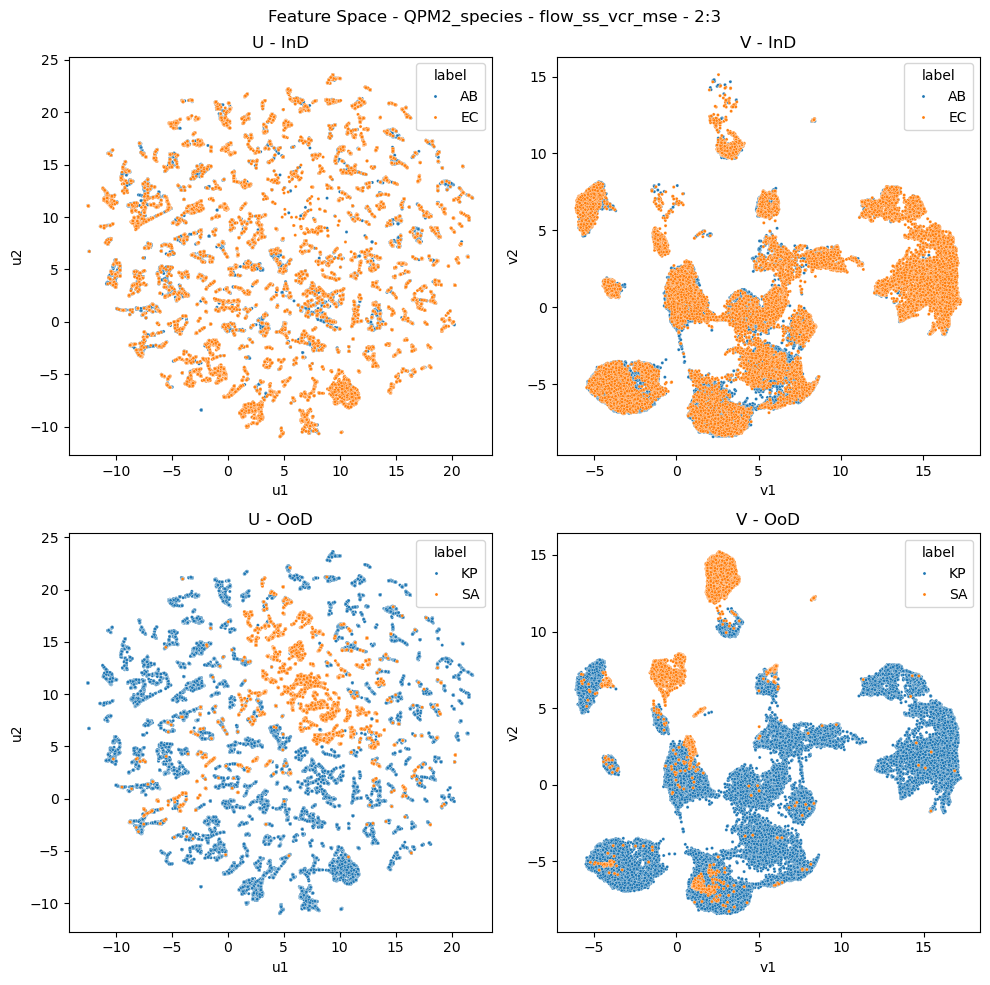

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

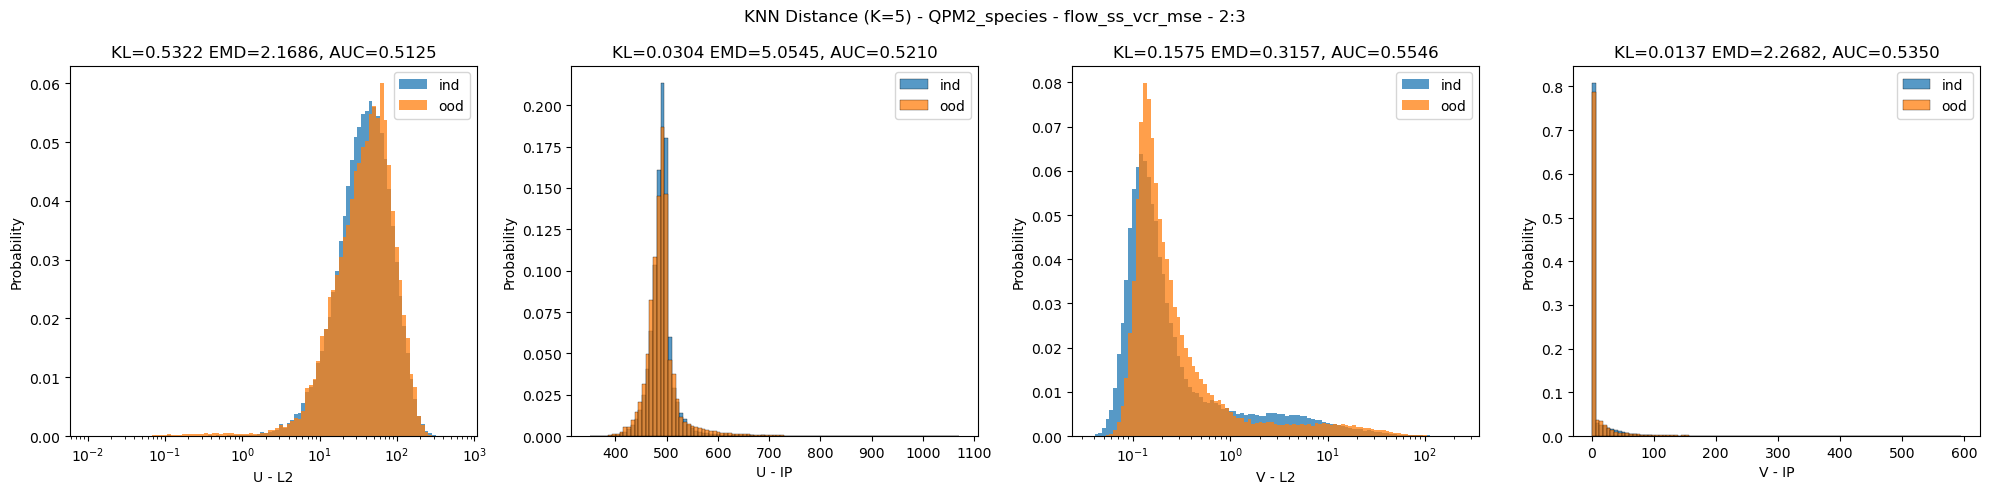

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

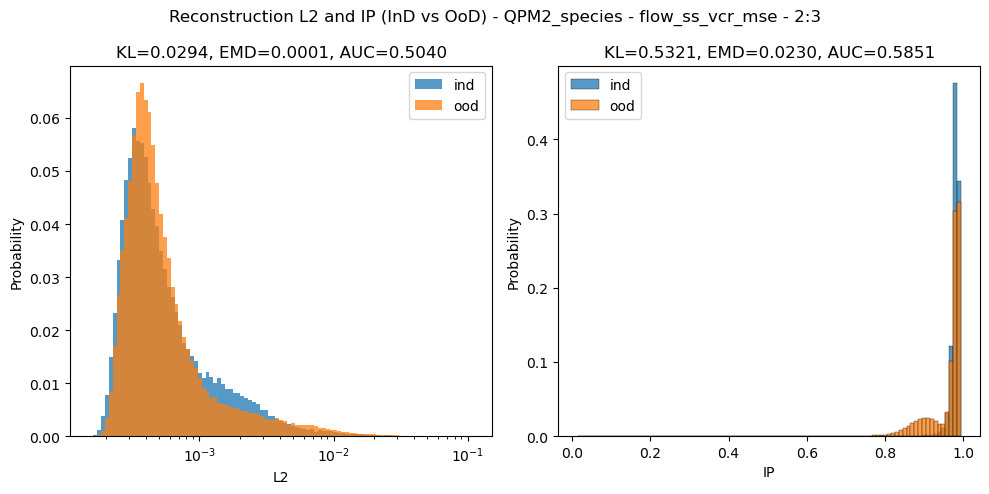

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.655027 0.46211573 1.4340844 1.6919682
22.6474 0.4609246 1.3971637 1.6640407
22.679438 0.54831046 1.3850476 1.8149779
22.68933 0.6612102 1.4786389 2.100192
32.845875 0.8779764 55.629044 0.7508357


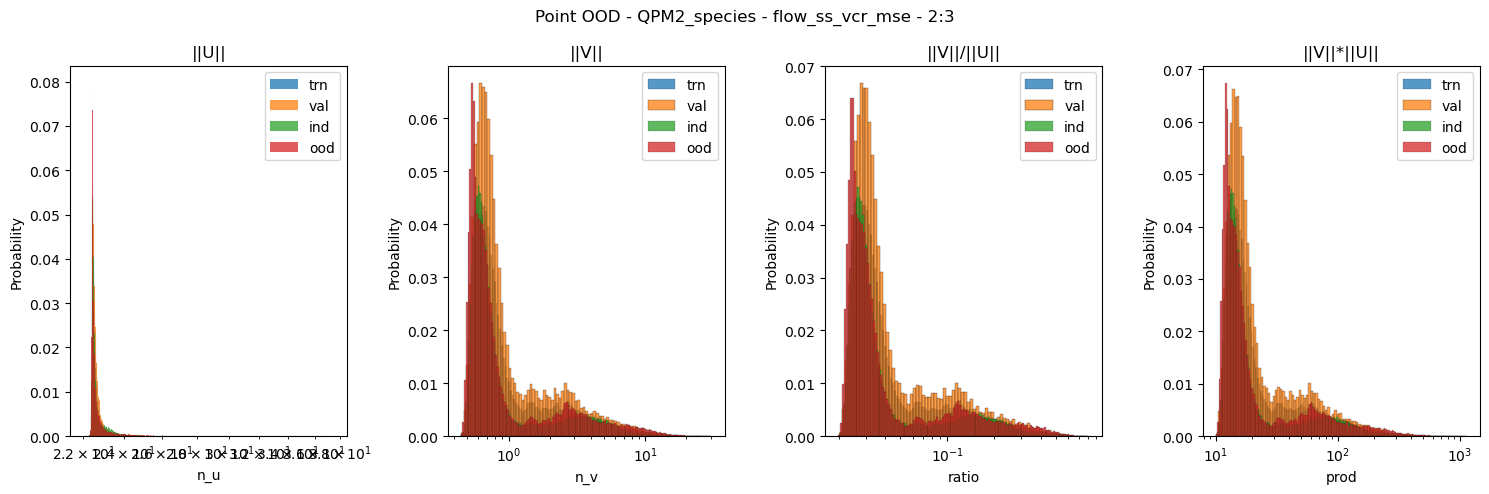

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


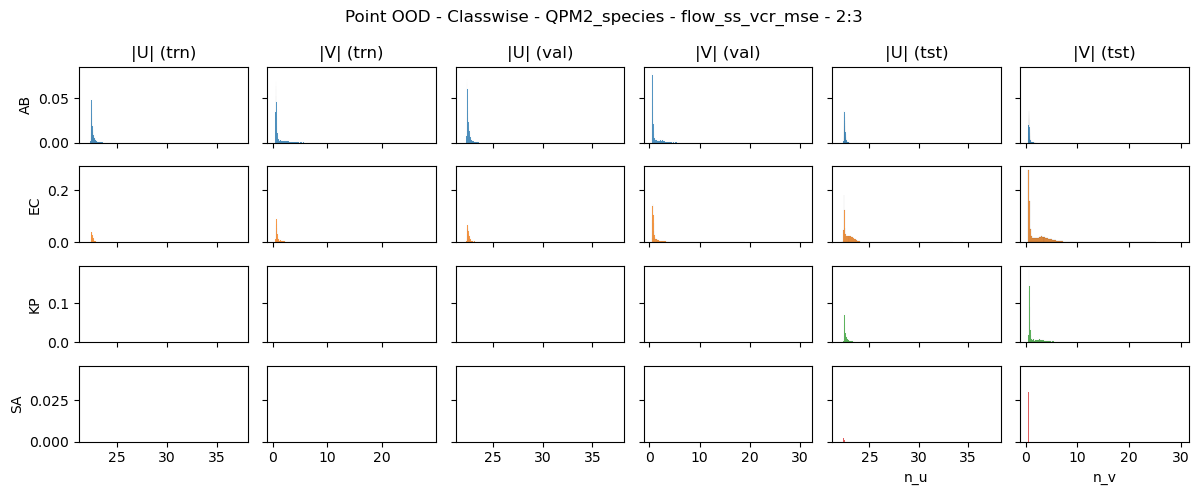

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

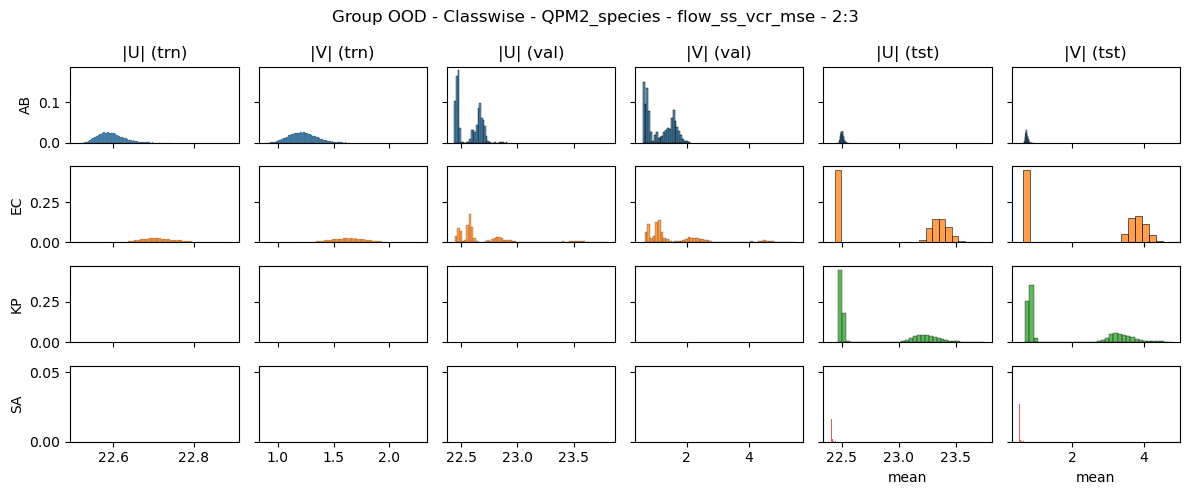

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()